In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

TARGET = "Critical Cooling Rate"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
FEATURES = {
    "PI": ['size_diff', 'size_ratio', 'size_range', 'DeltaH', 'CrystalMismatch0', 'Tmean', 'CrystalMismatch1'],
    "EP": ['Composition', 'CompositionA',
        'Atomic Number', 'Mendeleev Number', 'Atomic Weight',
        'Melting Temperature (K)', 'Column', 'Row', 'Covalent Radius',
        'Electronegativity', '# s Valence Electrons', '# p Valence Electrons',
        '# d Valence Electrons', '# f Valence Electrons',
        'Total # Valence Electrons', '# Unfilled s States',
        '# Unfilled p States', '# Unfilled d States', '# Unfilled f States',
        'Total # Unfilled States', 'Specific Volume of 0K Ground State',
        'Band Gap Energy of 0K Ground State',
        'Magnetic Moment of 0K Gound State', 'Space Goup # of 0K Ground State',
        'Radius by Miracle (Atomic size)', 'Boiling Temperature', 'Density',
        '1st Ioniztion Energy', 'Mass Heat Capacity', 'Molar Heat Capacity',
        'Heat of Fusion', 'Phi', 'n_ws 3rd', 'Cohesive E', 'Atomic NumberB',
        'Mendeleev NumberB', 'Atomic WeightB', 'Melting Temperature (K)B',
        'ColumnB', 'RowB', 'Covalent RadiusB', 'ElectronegativityB',
        '# s Valence ElectronsB', '# p Valence ElectronsB',
        '# d Valence ElectronsB', '# f Valence ElectronsB',
        'Total # Valence ElectronsB', '# Unfilled s StatesB',
        '# Unfilled p StatesB', '# Unfilled d StatesB', '# Unfilled f StatesB',
        'Total # Unfilled StatesB', 'Specific Volume of 0K Ground StateB',
        'Band Gap Energy of 0K Ground StateB',
        'Magnetic Moment of 0K Gound StateB',
        'Space Goup # of 0K Ground StateB', 'Radius by Miracle (Atomic size)B',
        'Boiling TemperatureB', 'DensityB', '1st Ioniztion EnergyB',
        'Mass Heat CapacityB', 'Molar Heat CapacityB', 'Heat of FusionB',
        'PhiB', 'n_ws 3rdB', 'Cohesive EB'],
    "Comp": ['W', 'Ni', 'Fe', 'Mg', 'Pd', 'Al', 'Ta', 'Sn', 'Cu', 'Hf', 'Nb', 'Ag','Pt', 'Ti', 'Mo', 
            'V', 'Zr', 'Mn', 'Au', 'Co', 'Si', 'Y', 'Cr', 'Ge'],
    "Random": ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7']
}

In [5]:
def prepare_dataset(df: pd.DataFrame, dataset_name: str, device=None):
    selected = FEATURES[dataset_name]
    X = torch.tensor(df[selected].values, dtype=torch.float32)
    y = torch.tensor(df[TARGET].values, dtype=torch.float32)
    if device is not None:
        X = X.to(device)
        y = y.to(device)
    
    return X, y

In [6]:
df_pi   = pd.read_csv("rc_PI_binary_new.csv")
df_ep   = pd.read_csv("rc_EP_binary.csv")
df_comp = pd.read_csv("rc_Comp_binary.csv")
df_rand = pd.read_csv("rc_Random_binary.csv")

In [7]:
class NN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [8]:
class BetterNN(nn.Module):
    def __init__(self, input_dim, widths=(128, 64, 32), p=0.15):
        super().__init__()
        layers = []
        prev = input_dim
        for w in widths:
            layers += [nn.Linear(prev, w), nn.BatchNorm1d(w), nn.LeakyReLU(), nn.Dropout(p)]
            prev = w
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [9]:
def plot_pred_vs_actual(per_system_results, n=6, rng_seed=0):
    rng = np.random.default_rng(rng_seed)
    choices = rng.choice(len(per_system_results), size=min(n, len(per_system_results)), replace=False)
    figs = []
    for idx in choices:
        system, y_true, y_pred = per_system_results[idx]
        plt.figure()
        plt.scatter(y_true, y_pred, s=10)
        m = max(np.max(y_true), np.max(y_pred))
        plt.plot([0, m], [0, m], lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(system)
        plt.show()

def plot_error_hist(per_system_results):
    errors = np.concatenate([pred - true for _, true, pred in per_system_results])
    plt.figure()
    plt.hist(errors, bins=50)
    plt.xlabel("Prediction - Actual"); plt.ylabel("Count"); plt.title("Error Histogram")
    plt.show()

In [10]:
def run_loop_gpu_cached(df: pd.DataFrame, feature: str, epochs: int = 50, batch_size: int = 1024, lr: float = 1e-3, device=None):

    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")

    X_all, y_all = prepare_dataset(df, feature, device=device)
    y_all = y_all.view(-1)  # ensure 1D

    sys_cats = pd.Categorical(df["Alloy System"])
    systems = sys_cats.categories.tolist()
    sys_ids_cpu = torch.from_numpy(sys_cats.codes)
    sys_ids = sys_ids_cpu.to(device, non_blocking=True)

    mapes, res = [], []

    for k, sys_name in enumerate(systems):
        test_mask  = (sys_ids == k)
        train_mask = ~test_mask

        X_train = X_all[train_mask]
        y_train = y_all[train_mask]
        X_test  = X_all[test_mask]
        y_test  = y_all[test_mask]

        mean = X_train.mean(dim=0, keepdim=True)
        std  = X_train.std(dim=0, unbiased=False, keepdim=True).clamp_min(1e-8)
        X_train = (X_train - mean) / std
        X_test  = (X_test  - mean) / std

        model = BetterNN(X_train.shape[1]).to(device)
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        N = X_train.size(0)
        bs = min(batch_size, N)

        for epoch in range(epochs):
            model.train()
            perm = torch.randperm(N, device=device)
            epoch_loss = 0.0

            for i in range(0, N, bs):
                idx = perm[i:i+bs]
                xb  = X_train[idx]
                yb  = y_train[idx].view(-1, 1)

                optimizer.zero_grad(set_to_none=True)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.detach().item() * xb.size(0)

            if (epoch + 1) % 10 == 0:
                print(f"[{feature}] {sys_name} | Epoch {epoch+1}/{epochs} Loss: {epoch_loss / N:.4f}")

        model.eval()
        with torch.no_grad():
            y_pred = model(X_test).squeeze(1)

        eps = 1e-8
        mape = float(((y_pred - y_test).abs() / y_test.abs().clamp_min(eps)).mean().item())
        mapes.append(mape)
        # move small arrays to CPU for plotting/storage
        y_test_cpu = y_test.detach().cpu().numpy()
        y_pred_cpu = y_pred.detach().cpu().numpy()
        res.append((sys_name, y_test_cpu, y_pred_cpu))

        plt.figure(figsize=(5,5))
        plt.scatter(y_test_cpu, y_pred_cpu, s=10, alpha=0.7)
        m = max(y_test_cpu.max(), y_pred_cpu.max())
        plt.plot([0, m], [0, m], 'r--', lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted")
        plt.title(f"{feature} | {sys_name} (MAPE {mape:.2f})")
        plt.show()

        print(f"[{feature}] Left-out: {sys_name} | Test MAPE: {mape:.4f}")

    return float(np.mean(mapes)), mapes, res


test


/tmp/ipykernel_6028/1816829483.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  sys_ids_cpu = torch.from_numpy(sys_cats.codes)


[PI] AgAl | Epoch 10/100 Loss: 65.3274
[PI] AgAl | Epoch 20/100 Loss: 28.8719
[PI] AgAl | Epoch 30/100 Loss: 8.3886
[PI] AgAl | Epoch 40/100 Loss: 3.6012
[PI] AgAl | Epoch 50/100 Loss: 2.8571
[PI] AgAl | Epoch 60/100 Loss: 2.5888
[PI] AgAl | Epoch 70/100 Loss: 2.4604
[PI] AgAl | Epoch 80/100 Loss: 2.3297
[PI] AgAl | Epoch 90/100 Loss: 2.2911
[PI] AgAl | Epoch 100/100 Loss: 2.1596


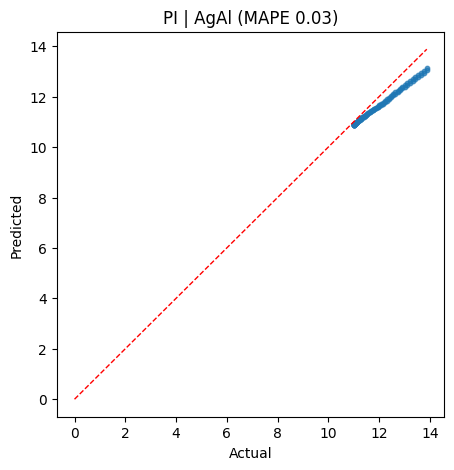

[PI] Left-out: AgAl | Test MAPE: 0.0273
[PI] AlMg | Epoch 10/100 Loss: 78.2056
[PI] AlMg | Epoch 20/100 Loss: 40.7438
[PI] AlMg | Epoch 30/100 Loss: 12.9224
[PI] AlMg | Epoch 40/100 Loss: 4.1664
[PI] AlMg | Epoch 50/100 Loss: 2.9757
[PI] AlMg | Epoch 60/100 Loss: 2.6012
[PI] AlMg | Epoch 70/100 Loss: 2.3669
[PI] AlMg | Epoch 80/100 Loss: 2.1032
[PI] AlMg | Epoch 90/100 Loss: 2.0549
[PI] AlMg | Epoch 100/100 Loss: 1.9604


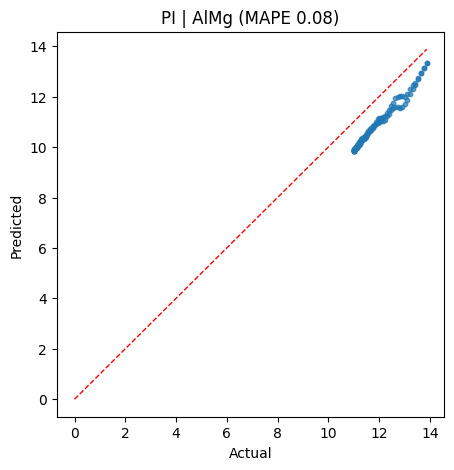

[PI] Left-out: AlMg | Test MAPE: 0.0847
[PI] AlNi | Epoch 10/100 Loss: 70.9153
[PI] AlNi | Epoch 20/100 Loss: 33.5473
[PI] AlNi | Epoch 30/100 Loss: 10.2639
[PI] AlNi | Epoch 40/100 Loss: 3.8217
[PI] AlNi | Epoch 50/100 Loss: 2.9143
[PI] AlNi | Epoch 60/100 Loss: 2.5313
[PI] AlNi | Epoch 70/100 Loss: 2.4006
[PI] AlNi | Epoch 80/100 Loss: 2.2770
[PI] AlNi | Epoch 90/100 Loss: 2.1120
[PI] AlNi | Epoch 100/100 Loss: 2.0504


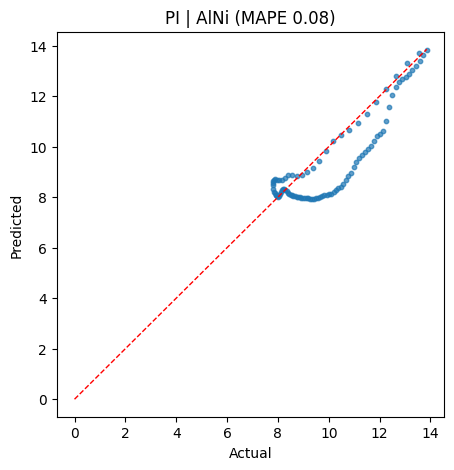

[PI] Left-out: AlNi | Test MAPE: 0.0787
[PI] AlTi | Epoch 10/100 Loss: 75.3474
[PI] AlTi | Epoch 20/100 Loss: 35.6736
[PI] AlTi | Epoch 30/100 Loss: 10.3246
[PI] AlTi | Epoch 40/100 Loss: 3.6537
[PI] AlTi | Epoch 50/100 Loss: 2.8965
[PI] AlTi | Epoch 60/100 Loss: 2.6235
[PI] AlTi | Epoch 70/100 Loss: 2.4041
[PI] AlTi | Epoch 80/100 Loss: 2.3091
[PI] AlTi | Epoch 90/100 Loss: 2.2357
[PI] AlTi | Epoch 100/100 Loss: 2.0802


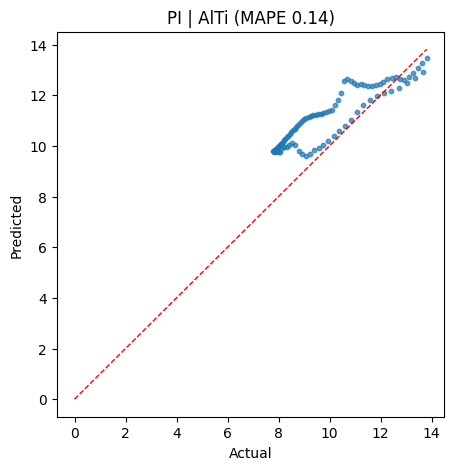

[PI] Left-out: AlTi | Test MAPE: 0.1445
[PI] AlV | Epoch 10/100 Loss: 71.7727
[PI] AlV | Epoch 20/100 Loss: 34.2401
[PI] AlV | Epoch 30/100 Loss: 10.4685
[PI] AlV | Epoch 40/100 Loss: 3.9083
[PI] AlV | Epoch 50/100 Loss: 2.8423
[PI] AlV | Epoch 60/100 Loss: 2.6324
[PI] AlV | Epoch 70/100 Loss: 2.5030
[PI] AlV | Epoch 80/100 Loss: 2.3601
[PI] AlV | Epoch 90/100 Loss: 2.2294
[PI] AlV | Epoch 100/100 Loss: 2.2017


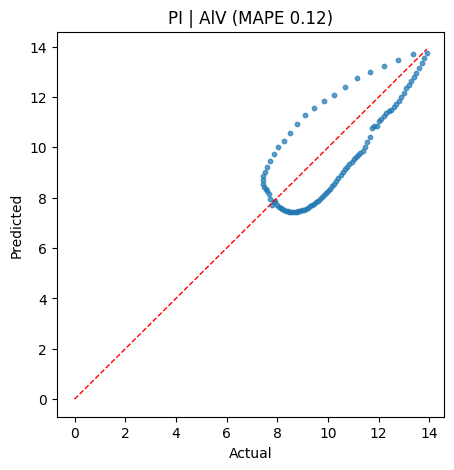

[PI] Left-out: AlV | Test MAPE: 0.1247
[PI] AuAl | Epoch 10/100 Loss: 66.2388
[PI] AuAl | Epoch 20/100 Loss: 30.3596
[PI] AuAl | Epoch 30/100 Loss: 9.1584
[PI] AuAl | Epoch 40/100 Loss: 3.6990
[PI] AuAl | Epoch 50/100 Loss: 2.8878
[PI] AuAl | Epoch 60/100 Loss: 2.5772
[PI] AuAl | Epoch 70/100 Loss: 2.4543
[PI] AuAl | Epoch 80/100 Loss: 2.1873
[PI] AuAl | Epoch 90/100 Loss: 2.1423
[PI] AuAl | Epoch 100/100 Loss: 2.0019


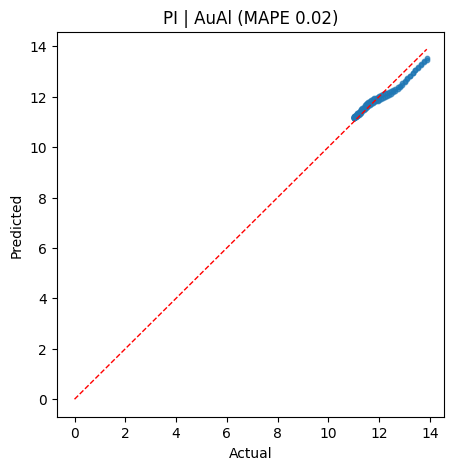

[PI] Left-out: AuAl | Test MAPE: 0.0174
[PI] AuCr | Epoch 10/100 Loss: 79.0951
[PI] AuCr | Epoch 20/100 Loss: 43.0215
[PI] AuCr | Epoch 30/100 Loss: 14.3452
[PI] AuCr | Epoch 40/100 Loss: 4.5034
[PI] AuCr | Epoch 50/100 Loss: 3.1872
[PI] AuCr | Epoch 60/100 Loss: 2.6475
[PI] AuCr | Epoch 70/100 Loss: 2.4826
[PI] AuCr | Epoch 80/100 Loss: 2.2055
[PI] AuCr | Epoch 90/100 Loss: 2.1425
[PI] AuCr | Epoch 100/100 Loss: 2.1809


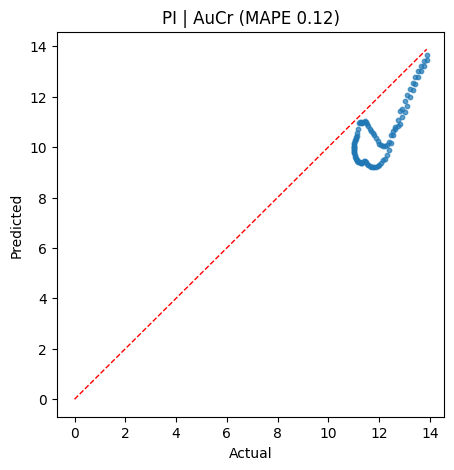

[PI] Left-out: AuCr | Test MAPE: 0.1185
[PI] AuHf | Epoch 10/100 Loss: 72.8683
[PI] AuHf | Epoch 20/100 Loss: 34.8863
[PI] AuHf | Epoch 30/100 Loss: 10.1632
[PI] AuHf | Epoch 40/100 Loss: 3.5735
[PI] AuHf | Epoch 50/100 Loss: 2.8042
[PI] AuHf | Epoch 60/100 Loss: 2.4934
[PI] AuHf | Epoch 70/100 Loss: 2.3006
[PI] AuHf | Epoch 80/100 Loss: 2.1400
[PI] AuHf | Epoch 90/100 Loss: 2.1317
[PI] AuHf | Epoch 100/100 Loss: 2.0056


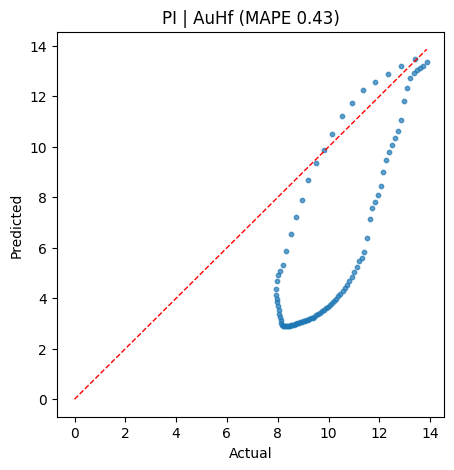

[PI] Left-out: AuHf | Test MAPE: 0.4323
[PI] AuMg | Epoch 10/100 Loss: 73.8919
[PI] AuMg | Epoch 20/100 Loss: 36.0582
[PI] AuMg | Epoch 30/100 Loss: 10.9698
[PI] AuMg | Epoch 40/100 Loss: 4.0858
[PI] AuMg | Epoch 50/100 Loss: 2.9305
[PI] AuMg | Epoch 60/100 Loss: 2.5641
[PI] AuMg | Epoch 70/100 Loss: 2.3248
[PI] AuMg | Epoch 80/100 Loss: 2.3251
[PI] AuMg | Epoch 90/100 Loss: 2.1210
[PI] AuMg | Epoch 100/100 Loss: 1.8876


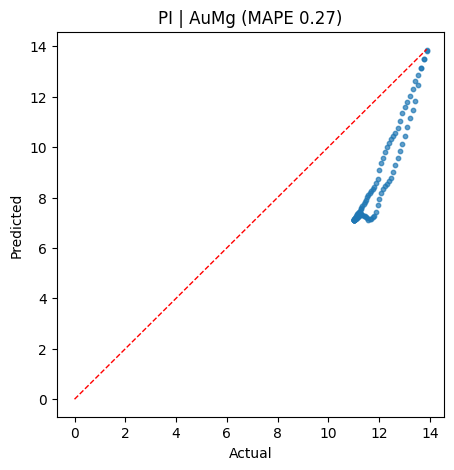

[PI] Left-out: AuMg | Test MAPE: 0.2694
[PI] CoMg | Epoch 10/100 Loss: 64.9080
[PI] CoMg | Epoch 20/100 Loss: 26.2739
[PI] CoMg | Epoch 30/100 Loss: 7.3588
[PI] CoMg | Epoch 40/100 Loss: 3.3526
[PI] CoMg | Epoch 50/100 Loss: 2.8169
[PI] CoMg | Epoch 60/100 Loss: 2.5299
[PI] CoMg | Epoch 70/100 Loss: 2.3575
[PI] CoMg | Epoch 80/100 Loss: 2.3704
[PI] CoMg | Epoch 90/100 Loss: 2.1632
[PI] CoMg | Epoch 100/100 Loss: 2.0075


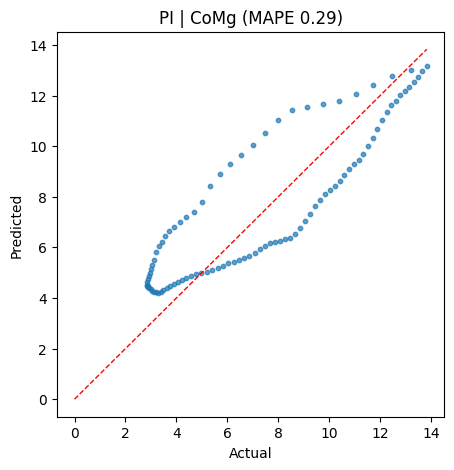

[PI] Left-out: CoMg | Test MAPE: 0.2942
[PI] CrAl | Epoch 10/100 Loss: 63.9010
[PI] CrAl | Epoch 20/100 Loss: 28.2125
[PI] CrAl | Epoch 30/100 Loss: 8.0579
[PI] CrAl | Epoch 40/100 Loss: 3.4647
[PI] CrAl | Epoch 50/100 Loss: 2.8380
[PI] CrAl | Epoch 60/100 Loss: 2.5823
[PI] CrAl | Epoch 70/100 Loss: 2.3623
[PI] CrAl | Epoch 80/100 Loss: 2.2370
[PI] CrAl | Epoch 90/100 Loss: 2.2307
[PI] CrAl | Epoch 100/100 Loss: 2.1286


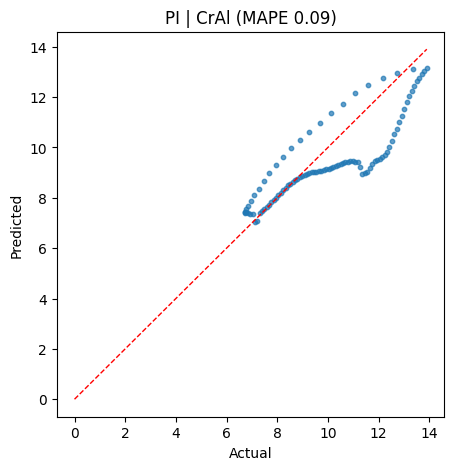

[PI] Left-out: CrAl | Test MAPE: 0.0950
[PI] CrCo | Epoch 10/100 Loss: 67.9992
[PI] CrCo | Epoch 20/100 Loss: 31.0423
[PI] CrCo | Epoch 30/100 Loss: 8.8279
[PI] CrCo | Epoch 40/100 Loss: 3.6055
[PI] CrCo | Epoch 50/100 Loss: 2.7378
[PI] CrCo | Epoch 60/100 Loss: 2.5467
[PI] CrCo | Epoch 70/100 Loss: 2.3555
[PI] CrCo | Epoch 80/100 Loss: 2.1947
[PI] CrCo | Epoch 90/100 Loss: 2.0987
[PI] CrCo | Epoch 100/100 Loss: 2.1006


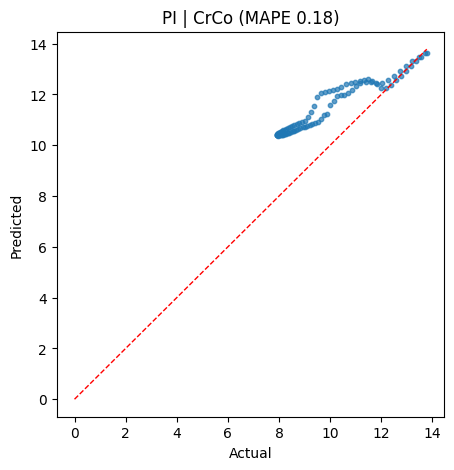

[PI] Left-out: CrCo | Test MAPE: 0.1789
[PI] CrMg | Epoch 10/100 Loss: 72.2559
[PI] CrMg | Epoch 20/100 Loss: 38.4632
[PI] CrMg | Epoch 30/100 Loss: 13.4567
[PI] CrMg | Epoch 40/100 Loss: 4.4094
[PI] CrMg | Epoch 50/100 Loss: 3.0071
[PI] CrMg | Epoch 60/100 Loss: 2.7347
[PI] CrMg | Epoch 70/100 Loss: 2.4560
[PI] CrMg | Epoch 80/100 Loss: 2.3487
[PI] CrMg | Epoch 90/100 Loss: 2.2779
[PI] CrMg | Epoch 100/100 Loss: 2.1848


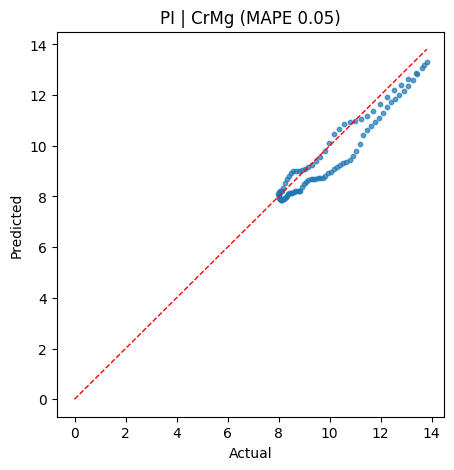

[PI] Left-out: CrMg | Test MAPE: 0.0469
[PI] CrNi | Epoch 10/100 Loss: 71.8133
[PI] CrNi | Epoch 20/100 Loss: 36.7909
[PI] CrNi | Epoch 30/100 Loss: 11.9042
[PI] CrNi | Epoch 40/100 Loss: 4.0550
[PI] CrNi | Epoch 50/100 Loss: 2.8985
[PI] CrNi | Epoch 60/100 Loss: 2.6168
[PI] CrNi | Epoch 70/100 Loss: 2.4424
[PI] CrNi | Epoch 80/100 Loss: 2.2476
[PI] CrNi | Epoch 90/100 Loss: 2.2353
[PI] CrNi | Epoch 100/100 Loss: 1.9929


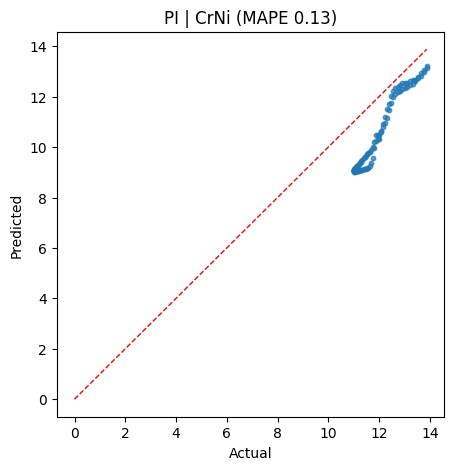

[PI] Left-out: CrNi | Test MAPE: 0.1263
[PI] CrV | Epoch 10/100 Loss: 74.8235
[PI] CrV | Epoch 20/100 Loss: 35.3230
[PI] CrV | Epoch 30/100 Loss: 10.3871
[PI] CrV | Epoch 40/100 Loss: 3.6821
[PI] CrV | Epoch 50/100 Loss: 2.8640
[PI] CrV | Epoch 60/100 Loss: 2.5467
[PI] CrV | Epoch 70/100 Loss: 2.4645
[PI] CrV | Epoch 80/100 Loss: 2.2825
[PI] CrV | Epoch 90/100 Loss: 2.2628
[PI] CrV | Epoch 100/100 Loss: 2.1823


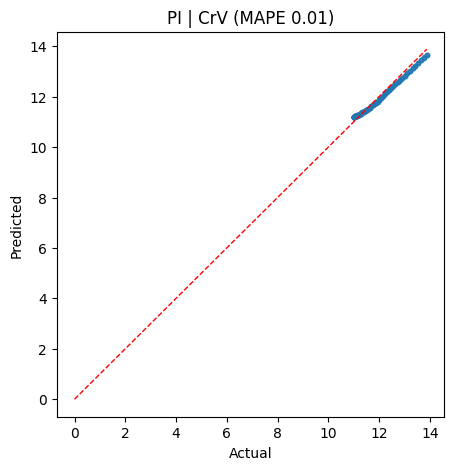

[PI] Left-out: CrV | Test MAPE: 0.0107
[PI] CuAl | Epoch 10/100 Loss: 87.9471
[PI] CuAl | Epoch 20/100 Loss: 50.8681
[PI] CuAl | Epoch 30/100 Loss: 18.5224
[PI] CuAl | Epoch 40/100 Loss: 5.8208
[PI] CuAl | Epoch 50/100 Loss: 3.4042
[PI] CuAl | Epoch 60/100 Loss: 2.9392
[PI] CuAl | Epoch 70/100 Loss: 2.5401
[PI] CuAl | Epoch 80/100 Loss: 2.4557
[PI] CuAl | Epoch 90/100 Loss: 2.3003
[PI] CuAl | Epoch 100/100 Loss: 2.1890


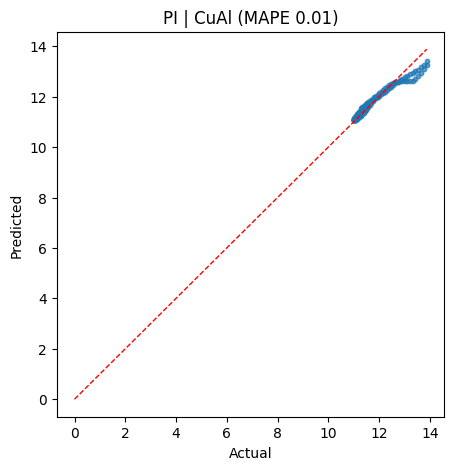

[PI] Left-out: CuAl | Test MAPE: 0.0139
[PI] CuMg | Epoch 10/100 Loss: 66.5040
[PI] CuMg | Epoch 20/100 Loss: 30.8905
[PI] CuMg | Epoch 30/100 Loss: 9.4983
[PI] CuMg | Epoch 40/100 Loss: 3.6826
[PI] CuMg | Epoch 50/100 Loss: 2.9022
[PI] CuMg | Epoch 60/100 Loss: 2.5565
[PI] CuMg | Epoch 70/100 Loss: 2.3890
[PI] CuMg | Epoch 80/100 Loss: 2.2916
[PI] CuMg | Epoch 90/100 Loss: 2.2099
[PI] CuMg | Epoch 100/100 Loss: 2.0807


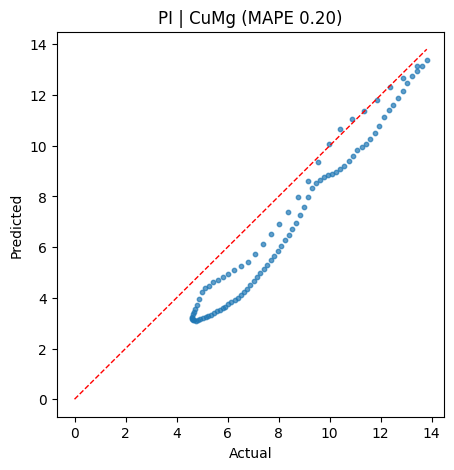

[PI] Left-out: CuMg | Test MAPE: 0.1958
[PI] CuNi | Epoch 10/100 Loss: 73.4798
[PI] CuNi | Epoch 20/100 Loss: 35.9498
[PI] CuNi | Epoch 30/100 Loss: 11.2122
[PI] CuNi | Epoch 40/100 Loss: 3.8593
[PI] CuNi | Epoch 50/100 Loss: 3.0131
[PI] CuNi | Epoch 60/100 Loss: 2.6733
[PI] CuNi | Epoch 70/100 Loss: 2.5220
[PI] CuNi | Epoch 80/100 Loss: 2.2950
[PI] CuNi | Epoch 90/100 Loss: 2.0906
[PI] CuNi | Epoch 100/100 Loss: 2.0214


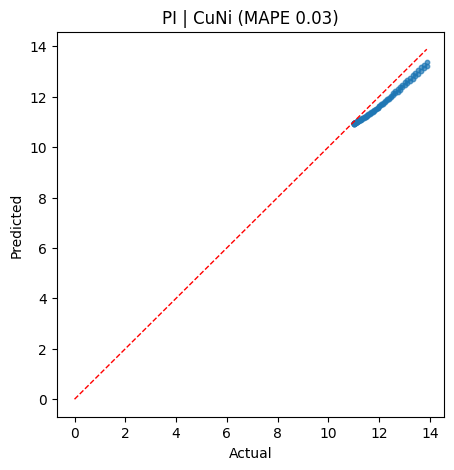

[PI] Left-out: CuNi | Test MAPE: 0.0256
[PI] CuSi | Epoch 10/100 Loss: 69.4777
[PI] CuSi | Epoch 20/100 Loss: 31.5464
[PI] CuSi | Epoch 30/100 Loss: 8.7455
[PI] CuSi | Epoch 40/100 Loss: 3.4167
[PI] CuSi | Epoch 50/100 Loss: 2.8492
[PI] CuSi | Epoch 60/100 Loss: 2.5062
[PI] CuSi | Epoch 70/100 Loss: 2.3900
[PI] CuSi | Epoch 80/100 Loss: 2.2410
[PI] CuSi | Epoch 90/100 Loss: 2.1143
[PI] CuSi | Epoch 100/100 Loss: 2.1224


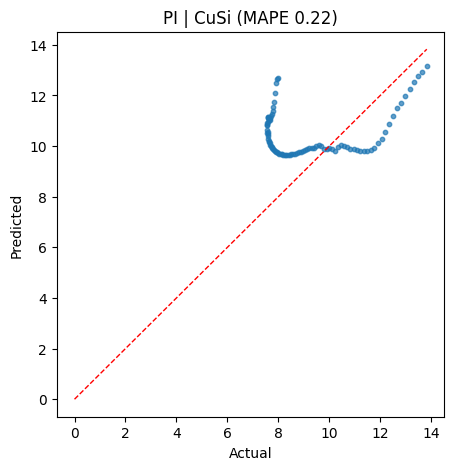

[PI] Left-out: CuSi | Test MAPE: 0.2246
[PI] CuZr | Epoch 10/100 Loss: 74.7933
[PI] CuZr | Epoch 20/100 Loss: 38.5788
[PI] CuZr | Epoch 30/100 Loss: 12.4633
[PI] CuZr | Epoch 40/100 Loss: 4.3701
[PI] CuZr | Epoch 50/100 Loss: 3.0826
[PI] CuZr | Epoch 60/100 Loss: 2.8715
[PI] CuZr | Epoch 70/100 Loss: 2.6437
[PI] CuZr | Epoch 80/100 Loss: 2.4612
[PI] CuZr | Epoch 90/100 Loss: 2.3035
[PI] CuZr | Epoch 100/100 Loss: 2.2256


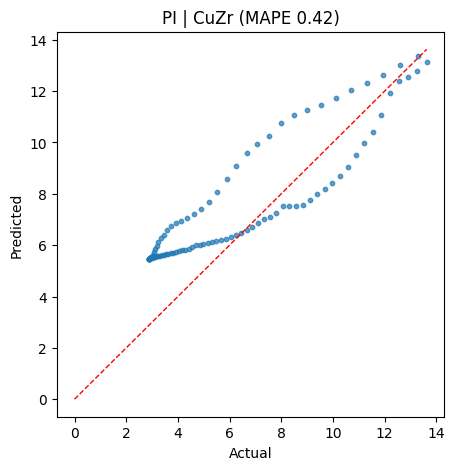

[PI] Left-out: CuZr | Test MAPE: 0.4214
[PI] FeAl | Epoch 10/100 Loss: 69.7301
[PI] FeAl | Epoch 20/100 Loss: 34.8113
[PI] FeAl | Epoch 30/100 Loss: 11.3307
[PI] FeAl | Epoch 40/100 Loss: 3.8812
[PI] FeAl | Epoch 50/100 Loss: 2.7499
[PI] FeAl | Epoch 60/100 Loss: 2.5491
[PI] FeAl | Epoch 70/100 Loss: 2.3619
[PI] FeAl | Epoch 80/100 Loss: 2.2295
[PI] FeAl | Epoch 90/100 Loss: 2.1455
[PI] FeAl | Epoch 100/100 Loss: 2.0662


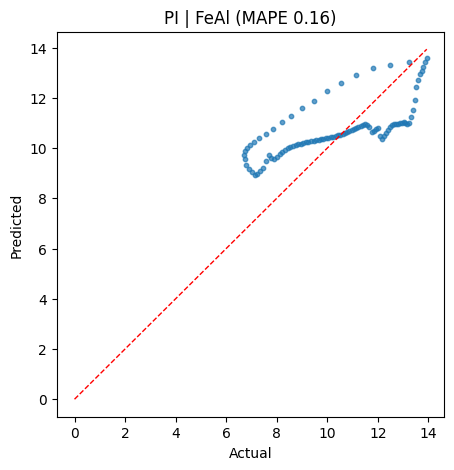

[PI] Left-out: FeAl | Test MAPE: 0.1554
[PI] FeMg | Epoch 10/100 Loss: 73.2794
[PI] FeMg | Epoch 20/100 Loss: 37.2249
[PI] FeMg | Epoch 30/100 Loss: 11.5076
[PI] FeMg | Epoch 40/100 Loss: 3.8632
[PI] FeMg | Epoch 50/100 Loss: 2.8751
[PI] FeMg | Epoch 60/100 Loss: 2.6022
[PI] FeMg | Epoch 70/100 Loss: 2.4360
[PI] FeMg | Epoch 80/100 Loss: 2.2637
[PI] FeMg | Epoch 90/100 Loss: 2.2154
[PI] FeMg | Epoch 100/100 Loss: 2.1127


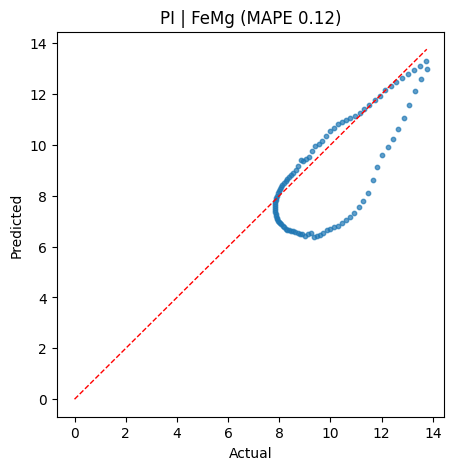

[PI] Left-out: FeMg | Test MAPE: 0.1246
[PI] GeMg | Epoch 10/100 Loss: 70.8609
[PI] GeMg | Epoch 20/100 Loss: 33.6103
[PI] GeMg | Epoch 30/100 Loss: 10.2453
[PI] GeMg | Epoch 40/100 Loss: 3.7017
[PI] GeMg | Epoch 50/100 Loss: 2.7431
[PI] GeMg | Epoch 60/100 Loss: 2.5755
[PI] GeMg | Epoch 70/100 Loss: 2.2912
[PI] GeMg | Epoch 80/100 Loss: 2.2300
[PI] GeMg | Epoch 90/100 Loss: 2.1112
[PI] GeMg | Epoch 100/100 Loss: 2.0521


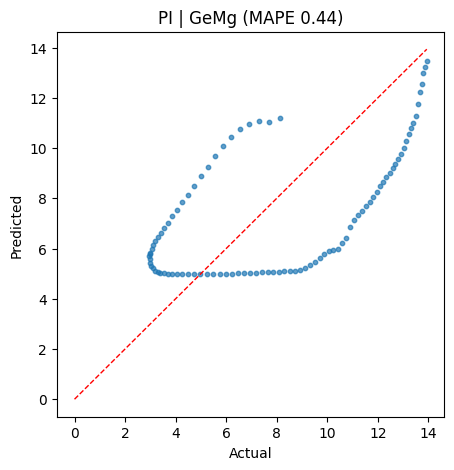

[PI] Left-out: GeMg | Test MAPE: 0.4383
[PI] HfAl | Epoch 10/100 Loss: 75.8936
[PI] HfAl | Epoch 20/100 Loss: 39.1417
[PI] HfAl | Epoch 30/100 Loss: 14.1900
[PI] HfAl | Epoch 40/100 Loss: 4.6545
[PI] HfAl | Epoch 50/100 Loss: 3.0665
[PI] HfAl | Epoch 60/100 Loss: 2.6520
[PI] HfAl | Epoch 70/100 Loss: 2.4698
[PI] HfAl | Epoch 80/100 Loss: 2.3922
[PI] HfAl | Epoch 90/100 Loss: 2.1241
[PI] HfAl | Epoch 100/100 Loss: 2.1829


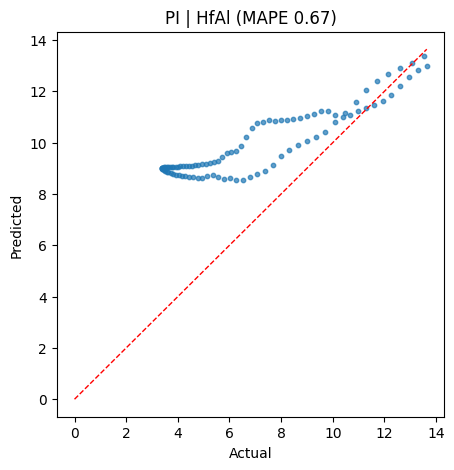

[PI] Left-out: HfAl | Test MAPE: 0.6699
[PI] HfFe | Epoch 10/100 Loss: 75.3802
[PI] HfFe | Epoch 20/100 Loss: 38.0804
[PI] HfFe | Epoch 30/100 Loss: 12.1931
[PI] HfFe | Epoch 40/100 Loss: 4.2279
[PI] HfFe | Epoch 50/100 Loss: 2.8784
[PI] HfFe | Epoch 60/100 Loss: 2.6693
[PI] HfFe | Epoch 70/100 Loss: 2.5076
[PI] HfFe | Epoch 80/100 Loss: 2.3335
[PI] HfFe | Epoch 90/100 Loss: 2.2283
[PI] HfFe | Epoch 100/100 Loss: 2.0876


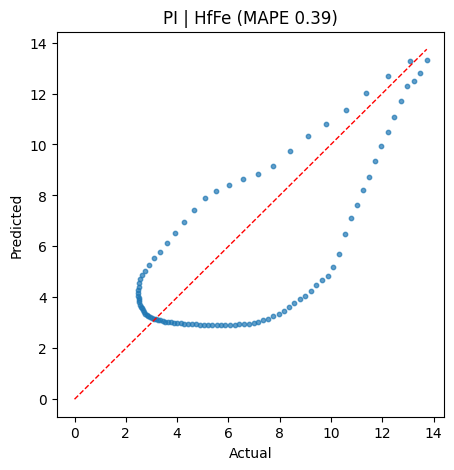

[PI] Left-out: HfFe | Test MAPE: 0.3876
[PI] HfMg | Epoch 10/100 Loss: 78.0321
[PI] HfMg | Epoch 20/100 Loss: 40.9187
[PI] HfMg | Epoch 30/100 Loss: 13.3711
[PI] HfMg | Epoch 40/100 Loss: 4.4036
[PI] HfMg | Epoch 50/100 Loss: 3.1627
[PI] HfMg | Epoch 60/100 Loss: 2.8553
[PI] HfMg | Epoch 70/100 Loss: 2.6469
[PI] HfMg | Epoch 80/100 Loss: 2.5783
[PI] HfMg | Epoch 90/100 Loss: 2.3894
[PI] HfMg | Epoch 100/100 Loss: 2.2410


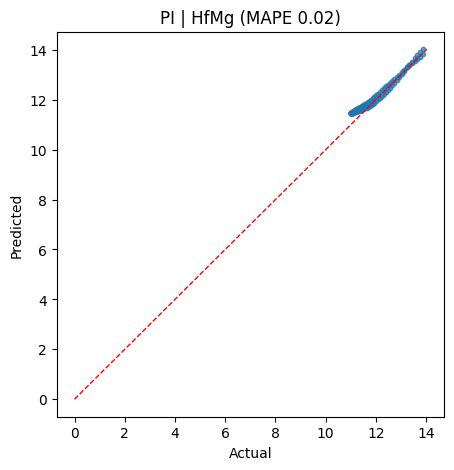

[PI] Left-out: HfMg | Test MAPE: 0.0188
[PI] HfTi | Epoch 10/100 Loss: 86.1505
[PI] HfTi | Epoch 20/100 Loss: 48.8193
[PI] HfTi | Epoch 30/100 Loss: 16.4255
[PI] HfTi | Epoch 40/100 Loss: 4.7994
[PI] HfTi | Epoch 50/100 Loss: 3.0624
[PI] HfTi | Epoch 60/100 Loss: 2.7006
[PI] HfTi | Epoch 70/100 Loss: 2.5867
[PI] HfTi | Epoch 80/100 Loss: 2.3017
[PI] HfTi | Epoch 90/100 Loss: 2.2016
[PI] HfTi | Epoch 100/100 Loss: 2.1259


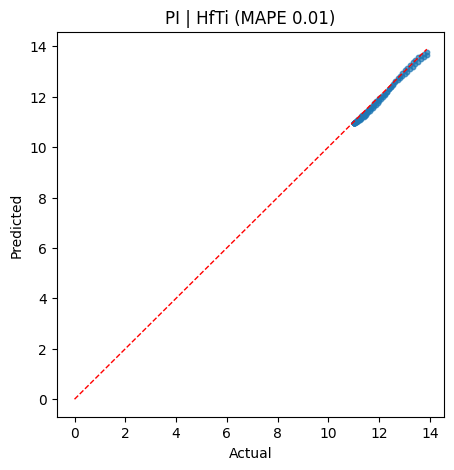

[PI] Left-out: HfTi | Test MAPE: 0.0086
[PI] HfY | Epoch 10/100 Loss: 70.7878
[PI] HfY | Epoch 20/100 Loss: 33.6316
[PI] HfY | Epoch 30/100 Loss: 9.8006
[PI] HfY | Epoch 40/100 Loss: 3.7146
[PI] HfY | Epoch 50/100 Loss: 2.9194
[PI] HfY | Epoch 60/100 Loss: 2.6057
[PI] HfY | Epoch 70/100 Loss: 2.4299
[PI] HfY | Epoch 80/100 Loss: 2.2815
[PI] HfY | Epoch 90/100 Loss: 2.2045
[PI] HfY | Epoch 100/100 Loss: 2.1193


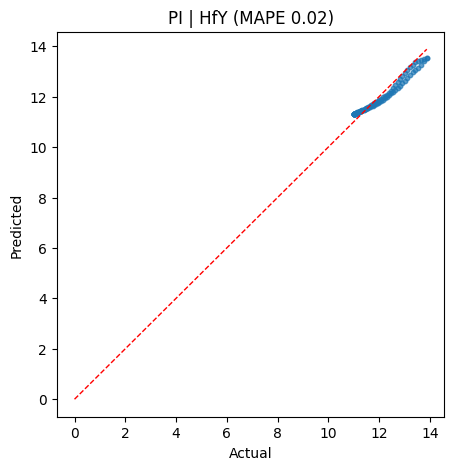

[PI] Left-out: HfY | Test MAPE: 0.0173
[PI] HfZr | Epoch 10/100 Loss: 75.0044
[PI] HfZr | Epoch 20/100 Loss: 36.7953
[PI] HfZr | Epoch 30/100 Loss: 11.3930
[PI] HfZr | Epoch 40/100 Loss: 4.0336
[PI] HfZr | Epoch 50/100 Loss: 2.8296
[PI] HfZr | Epoch 60/100 Loss: 2.4767
[PI] HfZr | Epoch 70/100 Loss: 2.4365
[PI] HfZr | Epoch 80/100 Loss: 2.2880
[PI] HfZr | Epoch 90/100 Loss: 2.1239
[PI] HfZr | Epoch 100/100 Loss: 2.0607


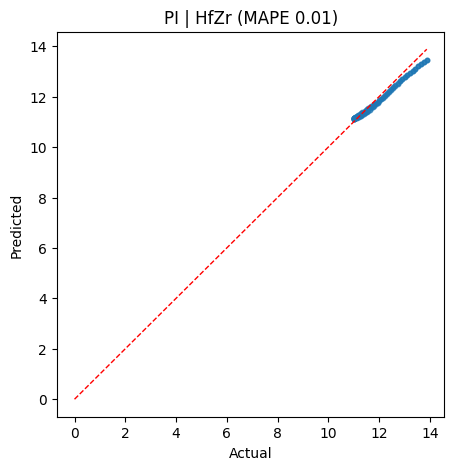

[PI] Left-out: HfZr | Test MAPE: 0.0129
[PI] MnAg | Epoch 10/100 Loss: 72.0691
[PI] MnAg | Epoch 20/100 Loss: 36.0382
[PI] MnAg | Epoch 30/100 Loss: 12.0926
[PI] MnAg | Epoch 40/100 Loss: 4.0965
[PI] MnAg | Epoch 50/100 Loss: 2.8527
[PI] MnAg | Epoch 60/100 Loss: 2.5777
[PI] MnAg | Epoch 70/100 Loss: 2.3938
[PI] MnAg | Epoch 80/100 Loss: 2.2751
[PI] MnAg | Epoch 90/100 Loss: 2.1483
[PI] MnAg | Epoch 100/100 Loss: 2.0935


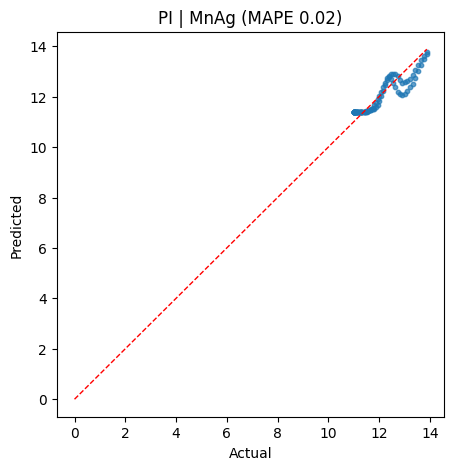

[PI] Left-out: MnAg | Test MAPE: 0.0232
[PI] MnAl | Epoch 10/100 Loss: 75.0874
[PI] MnAl | Epoch 20/100 Loss: 37.8140
[PI] MnAl | Epoch 30/100 Loss: 11.5049
[PI] MnAl | Epoch 40/100 Loss: 3.7568
[PI] MnAl | Epoch 50/100 Loss: 2.8065
[PI] MnAl | Epoch 60/100 Loss: 2.4957
[PI] MnAl | Epoch 70/100 Loss: 2.3334
[PI] MnAl | Epoch 80/100 Loss: 2.2217
[PI] MnAl | Epoch 90/100 Loss: 2.1682
[PI] MnAl | Epoch 100/100 Loss: 1.9876


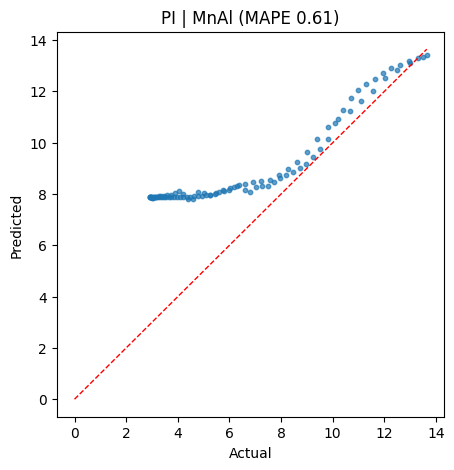

[PI] Left-out: MnAl | Test MAPE: 0.6081
[PI] MnMg | Epoch 10/100 Loss: 64.4712
[PI] MnMg | Epoch 20/100 Loss: 30.4309
[PI] MnMg | Epoch 30/100 Loss: 9.0386
[PI] MnMg | Epoch 40/100 Loss: 3.4493
[PI] MnMg | Epoch 50/100 Loss: 2.7739
[PI] MnMg | Epoch 60/100 Loss: 2.5021
[PI] MnMg | Epoch 70/100 Loss: 2.2712
[PI] MnMg | Epoch 80/100 Loss: 2.2409
[PI] MnMg | Epoch 90/100 Loss: 2.0492
[PI] MnMg | Epoch 100/100 Loss: 1.9520


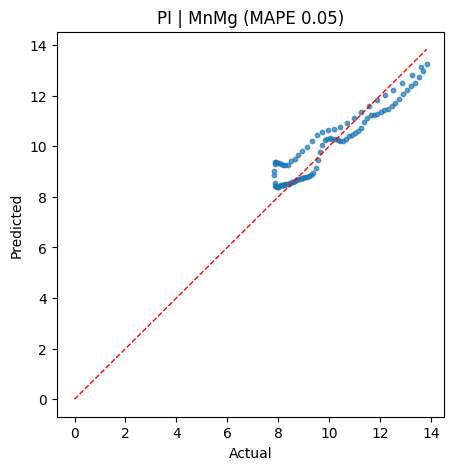

[PI] Left-out: MnMg | Test MAPE: 0.0541
[PI] MoCu | Epoch 10/100 Loss: 79.2868
[PI] MoCu | Epoch 20/100 Loss: 42.6362
[PI] MoCu | Epoch 30/100 Loss: 14.7870
[PI] MoCu | Epoch 40/100 Loss: 4.5597
[PI] MoCu | Epoch 50/100 Loss: 2.9071
[PI] MoCu | Epoch 60/100 Loss: 2.6320
[PI] MoCu | Epoch 70/100 Loss: 2.4562
[PI] MoCu | Epoch 80/100 Loss: 2.3074
[PI] MoCu | Epoch 90/100 Loss: 2.1426
[PI] MoCu | Epoch 100/100 Loss: 2.1374


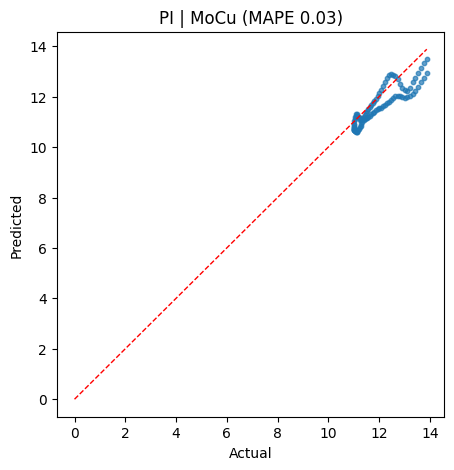

[PI] Left-out: MoCu | Test MAPE: 0.0341
[PI] MoMg | Epoch 10/100 Loss: 73.3579
[PI] MoMg | Epoch 20/100 Loss: 36.8061
[PI] MoMg | Epoch 30/100 Loss: 11.5852
[PI] MoMg | Epoch 40/100 Loss: 3.8517
[PI] MoMg | Epoch 50/100 Loss: 2.9019
[PI] MoMg | Epoch 60/100 Loss: 2.7032
[PI] MoMg | Epoch 70/100 Loss: 2.3860
[PI] MoMg | Epoch 80/100 Loss: 2.3302
[PI] MoMg | Epoch 90/100 Loss: 2.1489
[PI] MoMg | Epoch 100/100 Loss: 2.0948


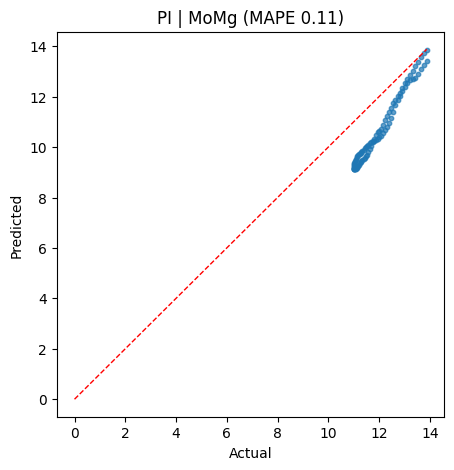

[PI] Left-out: MoMg | Test MAPE: 0.1133
[PI] MoTi | Epoch 10/100 Loss: 68.8656
[PI] MoTi | Epoch 20/100 Loss: 34.1467
[PI] MoTi | Epoch 30/100 Loss: 10.9182
[PI] MoTi | Epoch 40/100 Loss: 3.9294
[PI] MoTi | Epoch 50/100 Loss: 2.9405
[PI] MoTi | Epoch 60/100 Loss: 2.5628
[PI] MoTi | Epoch 70/100 Loss: 2.3737
[PI] MoTi | Epoch 80/100 Loss: 2.2753
[PI] MoTi | Epoch 90/100 Loss: 2.1838
[PI] MoTi | Epoch 100/100 Loss: 2.1693


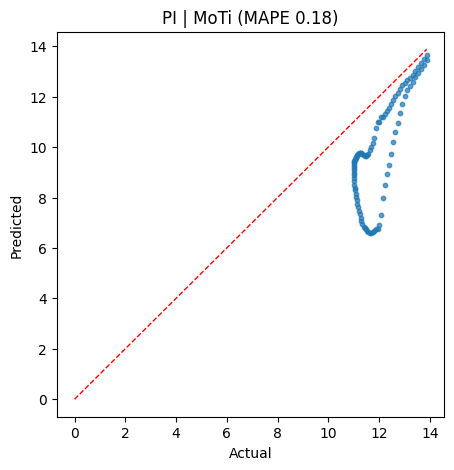

[PI] Left-out: MoTi | Test MAPE: 0.1805
[PI] MoZr | Epoch 10/100 Loss: 71.8408
[PI] MoZr | Epoch 20/100 Loss: 34.6557
[PI] MoZr | Epoch 30/100 Loss: 10.7796
[PI] MoZr | Epoch 40/100 Loss: 3.7352
[PI] MoZr | Epoch 50/100 Loss: 2.8142
[PI] MoZr | Epoch 60/100 Loss: 2.5909
[PI] MoZr | Epoch 70/100 Loss: 2.4074
[PI] MoZr | Epoch 80/100 Loss: 2.1995
[PI] MoZr | Epoch 90/100 Loss: 2.1634
[PI] MoZr | Epoch 100/100 Loss: 2.1110


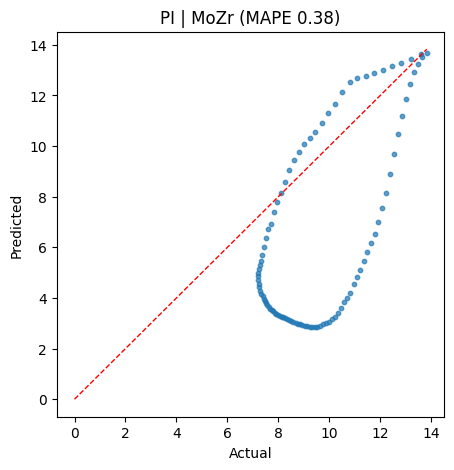

[PI] Left-out: MoZr | Test MAPE: 0.3769
[PI] NbMg | Epoch 10/100 Loss: 67.6389
[PI] NbMg | Epoch 20/100 Loss: 30.3324
[PI] NbMg | Epoch 30/100 Loss: 8.9261
[PI] NbMg | Epoch 40/100 Loss: 3.6259
[PI] NbMg | Epoch 50/100 Loss: 2.8510
[PI] NbMg | Epoch 60/100 Loss: 2.5367
[PI] NbMg | Epoch 70/100 Loss: 2.3153
[PI] NbMg | Epoch 80/100 Loss: 2.1555
[PI] NbMg | Epoch 90/100 Loss: 2.0431
[PI] NbMg | Epoch 100/100 Loss: 1.9284


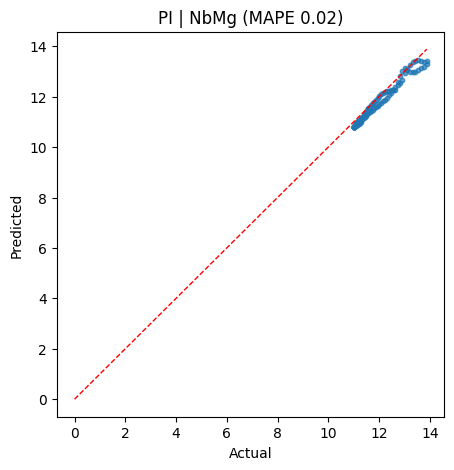

[PI] Left-out: NbMg | Test MAPE: 0.0170
[PI] NiMg | Epoch 10/100 Loss: 66.7793
[PI] NiMg | Epoch 20/100 Loss: 31.1289
[PI] NiMg | Epoch 30/100 Loss: 9.0290
[PI] NiMg | Epoch 40/100 Loss: 3.5055
[PI] NiMg | Epoch 50/100 Loss: 2.7514
[PI] NiMg | Epoch 60/100 Loss: 2.5155
[PI] NiMg | Epoch 70/100 Loss: 2.2501
[PI] NiMg | Epoch 80/100 Loss: 2.1325
[PI] NiMg | Epoch 90/100 Loss: 2.1059
[PI] NiMg | Epoch 100/100 Loss: 1.9767


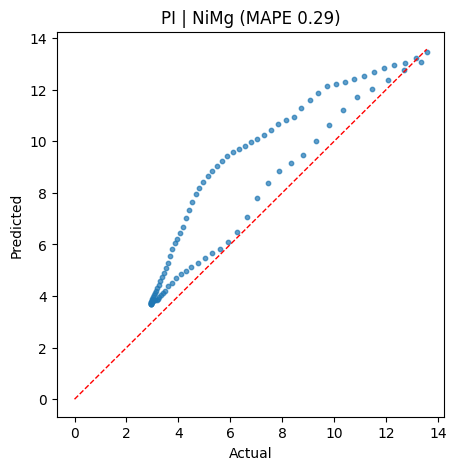

[PI] Left-out: NiMg | Test MAPE: 0.2925
[PI] PdFe | Epoch 10/100 Loss: 80.0706
[PI] PdFe | Epoch 20/100 Loss: 43.8491
[PI] PdFe | Epoch 30/100 Loss: 14.7580
[PI] PdFe | Epoch 40/100 Loss: 4.5302
[PI] PdFe | Epoch 50/100 Loss: 2.9933
[PI] PdFe | Epoch 60/100 Loss: 2.7279
[PI] PdFe | Epoch 70/100 Loss: 2.5120
[PI] PdFe | Epoch 80/100 Loss: 2.4153
[PI] PdFe | Epoch 90/100 Loss: 2.2155
[PI] PdFe | Epoch 100/100 Loss: 2.2076


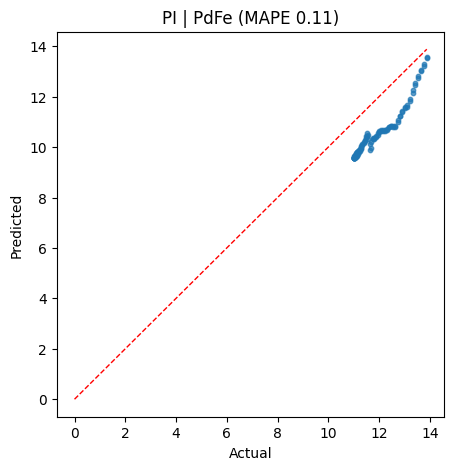

[PI] Left-out: PdFe | Test MAPE: 0.1133
[PI] PdMg | Epoch 10/100 Loss: 76.5040
[PI] PdMg | Epoch 20/100 Loss: 36.7729
[PI] PdMg | Epoch 30/100 Loss: 10.8543
[PI] PdMg | Epoch 40/100 Loss: 3.7579
[PI] PdMg | Epoch 50/100 Loss: 2.8872
[PI] PdMg | Epoch 60/100 Loss: 2.7069
[PI] PdMg | Epoch 70/100 Loss: 2.4791
[PI] PdMg | Epoch 80/100 Loss: 2.3123
[PI] PdMg | Epoch 90/100 Loss: 2.2508
[PI] PdMg | Epoch 100/100 Loss: 2.1798


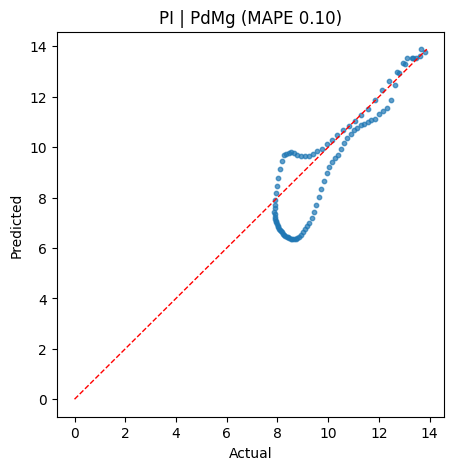

[PI] Left-out: PdMg | Test MAPE: 0.1009
[PI] PdSi | Epoch 10/100 Loss: 69.4074
[PI] PdSi | Epoch 20/100 Loss: 30.0918
[PI] PdSi | Epoch 30/100 Loss: 8.7175
[PI] PdSi | Epoch 40/100 Loss: 3.4158
[PI] PdSi | Epoch 50/100 Loss: 2.8185
[PI] PdSi | Epoch 60/100 Loss: 2.5960
[PI] PdSi | Epoch 70/100 Loss: 2.3270
[PI] PdSi | Epoch 80/100 Loss: 2.3299
[PI] PdSi | Epoch 90/100 Loss: 2.0807
[PI] PdSi | Epoch 100/100 Loss: 1.9966


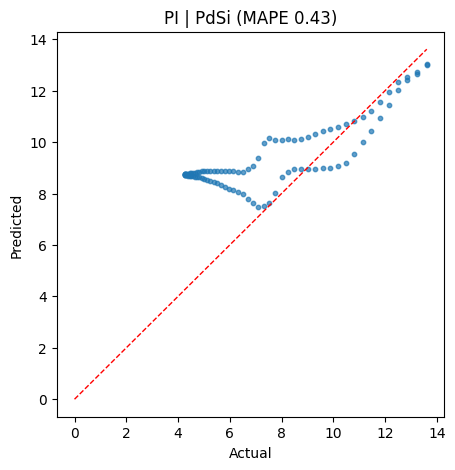

[PI] Left-out: PdSi | Test MAPE: 0.4263
[PI] PtGe | Epoch 10/100 Loss: 73.5147
[PI] PtGe | Epoch 20/100 Loss: 39.7187
[PI] PtGe | Epoch 30/100 Loss: 13.9645
[PI] PtGe | Epoch 40/100 Loss: 4.5971
[PI] PtGe | Epoch 50/100 Loss: 3.0862
[PI] PtGe | Epoch 60/100 Loss: 2.8076
[PI] PtGe | Epoch 70/100 Loss: 2.5681
[PI] PtGe | Epoch 80/100 Loss: 2.3790
[PI] PtGe | Epoch 90/100 Loss: 2.3578
[PI] PtGe | Epoch 100/100 Loss: 2.2063


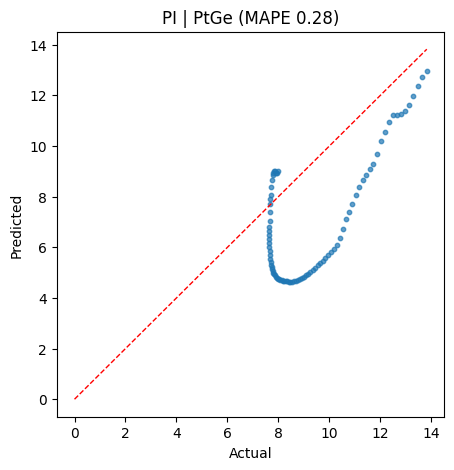

[PI] Left-out: PtGe | Test MAPE: 0.2804
[PI] PtMg | Epoch 10/100 Loss: 79.8365
[PI] PtMg | Epoch 20/100 Loss: 43.2703
[PI] PtMg | Epoch 30/100 Loss: 15.6021
[PI] PtMg | Epoch 40/100 Loss: 5.3965
[PI] PtMg | Epoch 50/100 Loss: 3.1331
[PI] PtMg | Epoch 60/100 Loss: 2.5522
[PI] PtMg | Epoch 70/100 Loss: 2.2401
[PI] PtMg | Epoch 80/100 Loss: 2.1965
[PI] PtMg | Epoch 90/100 Loss: 2.1401
[PI] PtMg | Epoch 100/100 Loss: 2.0056


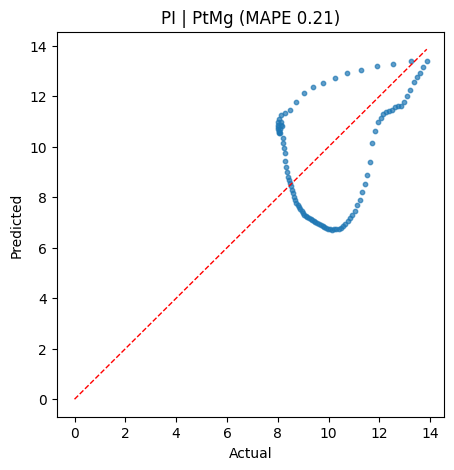

[PI] Left-out: PtMg | Test MAPE: 0.2118
[PI] SnMg | Epoch 10/100 Loss: 72.9306
[PI] SnMg | Epoch 20/100 Loss: 35.5171
[PI] SnMg | Epoch 30/100 Loss: 10.5098
[PI] SnMg | Epoch 40/100 Loss: 3.6300
[PI] SnMg | Epoch 50/100 Loss: 2.7433
[PI] SnMg | Epoch 60/100 Loss: 2.4941
[PI] SnMg | Epoch 70/100 Loss: 2.4189
[PI] SnMg | Epoch 80/100 Loss: 2.2918
[PI] SnMg | Epoch 90/100 Loss: 2.1403
[PI] SnMg | Epoch 100/100 Loss: 2.1489


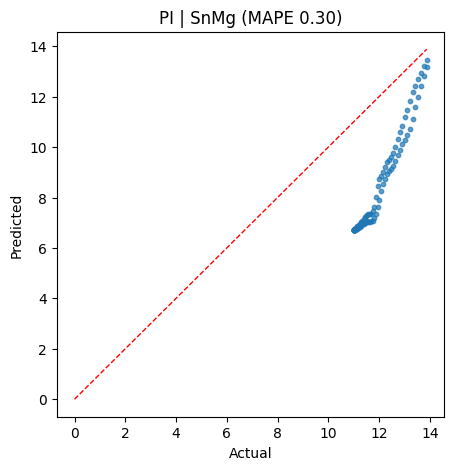

[PI] Left-out: SnMg | Test MAPE: 0.2997
[PI] TaMg | Epoch 10/100 Loss: 64.6445
[PI] TaMg | Epoch 20/100 Loss: 31.1845
[PI] TaMg | Epoch 30/100 Loss: 9.3294
[PI] TaMg | Epoch 40/100 Loss: 3.6492
[PI] TaMg | Epoch 50/100 Loss: 2.8558
[PI] TaMg | Epoch 60/100 Loss: 2.5403
[PI] TaMg | Epoch 70/100 Loss: 2.4702
[PI] TaMg | Epoch 80/100 Loss: 2.1635
[PI] TaMg | Epoch 90/100 Loss: 2.0657
[PI] TaMg | Epoch 100/100 Loss: 2.0237


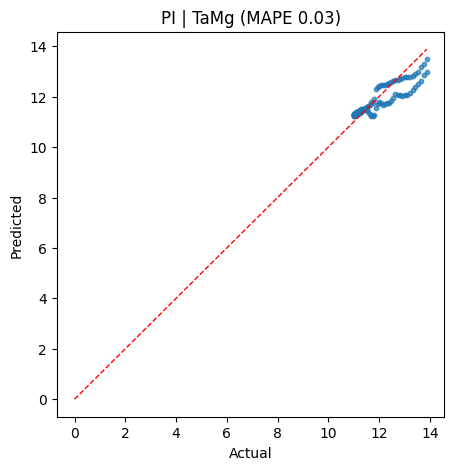

[PI] Left-out: TaMg | Test MAPE: 0.0279
[PI] TaMn | Epoch 10/100 Loss: 79.5888
[PI] TaMn | Epoch 20/100 Loss: 41.5164
[PI] TaMn | Epoch 30/100 Loss: 13.1451
[PI] TaMn | Epoch 40/100 Loss: 4.0151
[PI] TaMn | Epoch 50/100 Loss: 2.6902
[PI] TaMn | Epoch 60/100 Loss: 2.4190
[PI] TaMn | Epoch 70/100 Loss: 2.3109
[PI] TaMn | Epoch 80/100 Loss: 2.0698
[PI] TaMn | Epoch 90/100 Loss: 1.9551
[PI] TaMn | Epoch 100/100 Loss: 1.9085


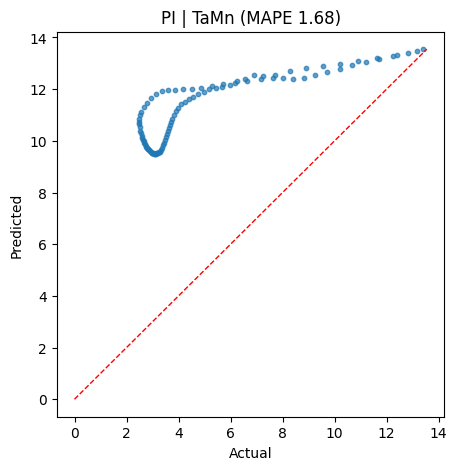

[PI] Left-out: TaMn | Test MAPE: 1.6787
[PI] TiMg | Epoch 10/100 Loss: 75.7119
[PI] TiMg | Epoch 20/100 Loss: 38.0494
[PI] TiMg | Epoch 30/100 Loss: 11.7016
[PI] TiMg | Epoch 40/100 Loss: 3.9608
[PI] TiMg | Epoch 50/100 Loss: 2.9342
[PI] TiMg | Epoch 60/100 Loss: 2.6464
[PI] TiMg | Epoch 70/100 Loss: 2.4676
[PI] TiMg | Epoch 80/100 Loss: 2.3582
[PI] TiMg | Epoch 90/100 Loss: 2.2184
[PI] TiMg | Epoch 100/100 Loss: 2.0936


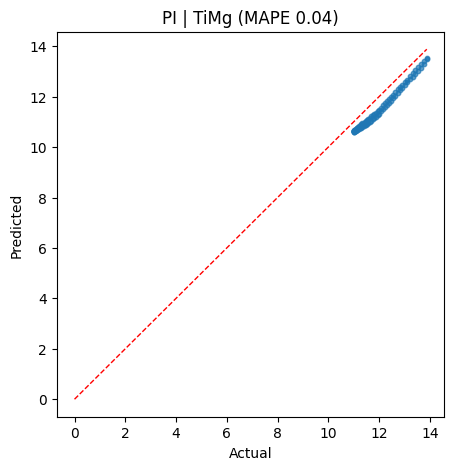

[PI] Left-out: TiMg | Test MAPE: 0.0403
[PI] TiZr | Epoch 10/100 Loss: 76.3501
[PI] TiZr | Epoch 20/100 Loss: 37.4626
[PI] TiZr | Epoch 30/100 Loss: 11.5145
[PI] TiZr | Epoch 40/100 Loss: 4.1165
[PI] TiZr | Epoch 50/100 Loss: 3.0642
[PI] TiZr | Epoch 60/100 Loss: 2.8467
[PI] TiZr | Epoch 70/100 Loss: 2.6932
[PI] TiZr | Epoch 80/100 Loss: 2.3898
[PI] TiZr | Epoch 90/100 Loss: 2.2561
[PI] TiZr | Epoch 100/100 Loss: 2.1609


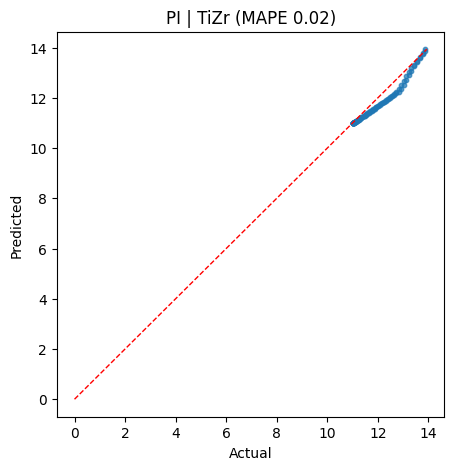

[PI] Left-out: TiZr | Test MAPE: 0.0172
[PI] VCu | Epoch 10/100 Loss: 80.5282
[PI] VCu | Epoch 20/100 Loss: 41.1374
[PI] VCu | Epoch 30/100 Loss: 13.1966
[PI] VCu | Epoch 40/100 Loss: 4.5151
[PI] VCu | Epoch 50/100 Loss: 3.1731
[PI] VCu | Epoch 60/100 Loss: 2.8640
[PI] VCu | Epoch 70/100 Loss: 2.5763
[PI] VCu | Epoch 80/100 Loss: 2.5530
[PI] VCu | Epoch 90/100 Loss: 2.3276
[PI] VCu | Epoch 100/100 Loss: 2.2545


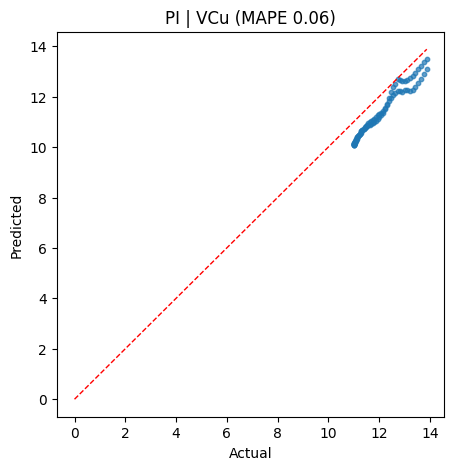

[PI] Left-out: VCu | Test MAPE: 0.0585
[PI] VHf | Epoch 10/100 Loss: 75.9137
[PI] VHf | Epoch 20/100 Loss: 39.1715
[PI] VHf | Epoch 30/100 Loss: 12.1257
[PI] VHf | Epoch 40/100 Loss: 3.9473
[PI] VHf | Epoch 50/100 Loss: 2.9043
[PI] VHf | Epoch 60/100 Loss: 2.6229
[PI] VHf | Epoch 70/100 Loss: 2.3655
[PI] VHf | Epoch 80/100 Loss: 2.2749
[PI] VHf | Epoch 90/100 Loss: 2.1445
[PI] VHf | Epoch 100/100 Loss: 2.0722


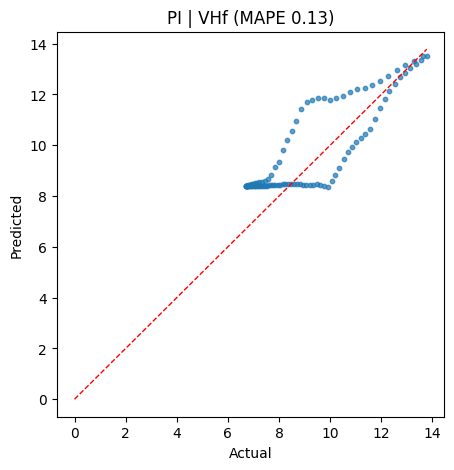

[PI] Left-out: VHf | Test MAPE: 0.1303
[PI] VMg | Epoch 10/100 Loss: 76.2236
[PI] VMg | Epoch 20/100 Loss: 38.5763
[PI] VMg | Epoch 30/100 Loss: 12.0270
[PI] VMg | Epoch 40/100 Loss: 3.9871
[PI] VMg | Epoch 50/100 Loss: 2.8157
[PI] VMg | Epoch 60/100 Loss: 2.5658
[PI] VMg | Epoch 70/100 Loss: 2.5018
[PI] VMg | Epoch 80/100 Loss: 2.3250
[PI] VMg | Epoch 90/100 Loss: 2.2143
[PI] VMg | Epoch 100/100 Loss: 2.1585


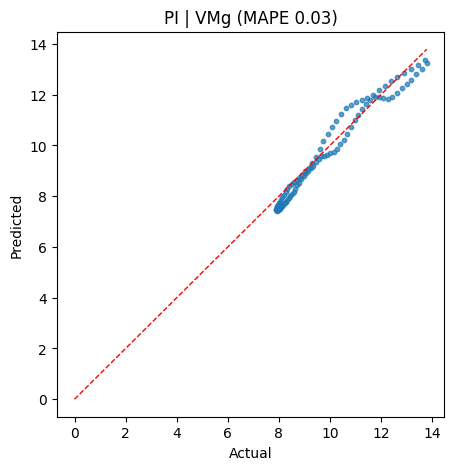

[PI] Left-out: VMg | Test MAPE: 0.0335
[PI] VNi | Epoch 10/100 Loss: 75.2667
[PI] VNi | Epoch 20/100 Loss: 38.7379
[PI] VNi | Epoch 30/100 Loss: 12.2758
[PI] VNi | Epoch 40/100 Loss: 4.1879
[PI] VNi | Epoch 50/100 Loss: 2.9935
[PI] VNi | Epoch 60/100 Loss: 2.6081
[PI] VNi | Epoch 70/100 Loss: 2.4150
[PI] VNi | Epoch 80/100 Loss: 2.4257
[PI] VNi | Epoch 90/100 Loss: 2.2705
[PI] VNi | Epoch 100/100 Loss: 2.1156


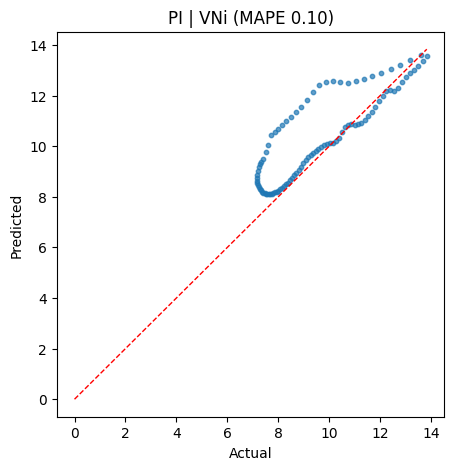

[PI] Left-out: VNi | Test MAPE: 0.1031
[PI] VSi | Epoch 10/100 Loss: 64.5420
[PI] VSi | Epoch 20/100 Loss: 28.2805
[PI] VSi | Epoch 30/100 Loss: 8.2992
[PI] VSi | Epoch 40/100 Loss: 3.3628
[PI] VSi | Epoch 50/100 Loss: 2.6924
[PI] VSi | Epoch 60/100 Loss: 2.4662
[PI] VSi | Epoch 70/100 Loss: 2.3108
[PI] VSi | Epoch 80/100 Loss: 2.1874
[PI] VSi | Epoch 90/100 Loss: 2.1026
[PI] VSi | Epoch 100/100 Loss: 1.9935


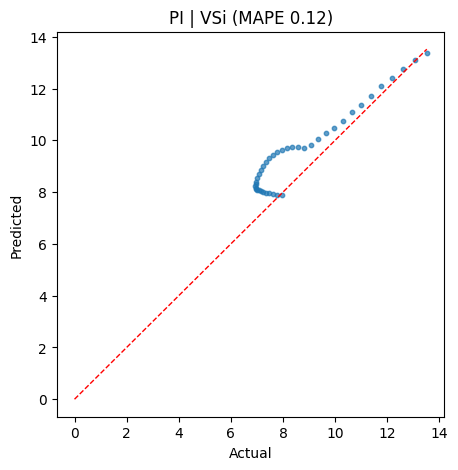

[PI] Left-out: VSi | Test MAPE: 0.1212
[PI] VSn | Epoch 10/100 Loss: 73.0805
[PI] VSn | Epoch 20/100 Loss: 36.2662
[PI] VSn | Epoch 30/100 Loss: 11.7067
[PI] VSn | Epoch 40/100 Loss: 4.1546
[PI] VSn | Epoch 50/100 Loss: 2.8977
[PI] VSn | Epoch 60/100 Loss: 2.7142
[PI] VSn | Epoch 70/100 Loss: 2.3607
[PI] VSn | Epoch 80/100 Loss: 2.2600
[PI] VSn | Epoch 90/100 Loss: 2.1440
[PI] VSn | Epoch 100/100 Loss: 2.0657


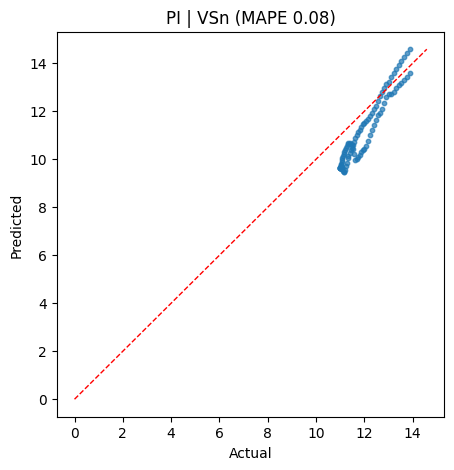

[PI] Left-out: VSn | Test MAPE: 0.0774
[PI] VTi | Epoch 10/100 Loss: 69.2970
[PI] VTi | Epoch 20/100 Loss: 33.5157
[PI] VTi | Epoch 30/100 Loss: 10.7245
[PI] VTi | Epoch 40/100 Loss: 3.9383
[PI] VTi | Epoch 50/100 Loss: 2.8904
[PI] VTi | Epoch 60/100 Loss: 2.4792
[PI] VTi | Epoch 70/100 Loss: 2.3902
[PI] VTi | Epoch 80/100 Loss: 2.2143
[PI] VTi | Epoch 90/100 Loss: 2.0935
[PI] VTi | Epoch 100/100 Loss: 2.0248


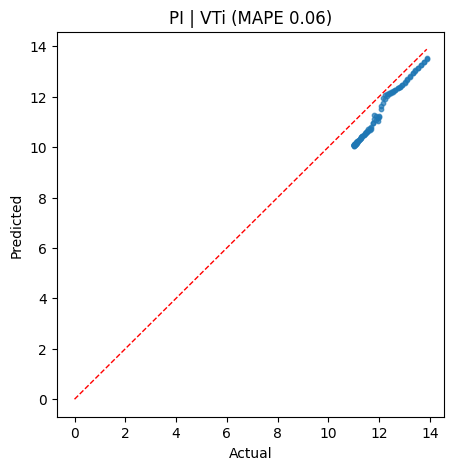

[PI] Left-out: VTi | Test MAPE: 0.0589
[PI] VY | Epoch 10/100 Loss: 73.2087
[PI] VY | Epoch 20/100 Loss: 37.1590
[PI] VY | Epoch 30/100 Loss: 11.9765
[PI] VY | Epoch 40/100 Loss: 3.8554
[PI] VY | Epoch 50/100 Loss: 2.8418
[PI] VY | Epoch 60/100 Loss: 2.5111
[PI] VY | Epoch 70/100 Loss: 2.4199
[PI] VY | Epoch 80/100 Loss: 2.3579
[PI] VY | Epoch 90/100 Loss: 2.1783
[PI] VY | Epoch 100/100 Loss: 2.0930


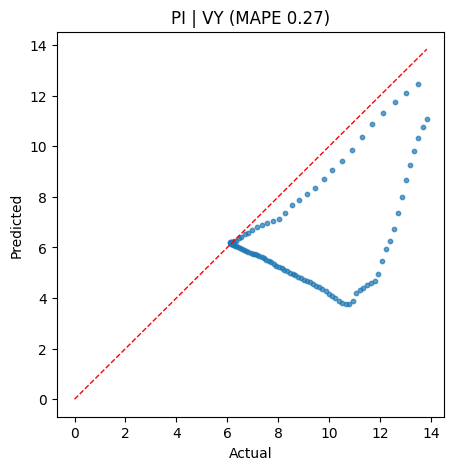

[PI] Left-out: VY | Test MAPE: 0.2739
[PI] WMg | Epoch 10/100 Loss: 80.0436
[PI] WMg | Epoch 20/100 Loss: 43.3592
[PI] WMg | Epoch 30/100 Loss: 14.2013
[PI] WMg | Epoch 40/100 Loss: 4.4916
[PI] WMg | Epoch 50/100 Loss: 3.1083
[PI] WMg | Epoch 60/100 Loss: 2.6894
[PI] WMg | Epoch 70/100 Loss: 2.5185
[PI] WMg | Epoch 80/100 Loss: 2.3849
[PI] WMg | Epoch 90/100 Loss: 2.2069
[PI] WMg | Epoch 100/100 Loss: 2.0730


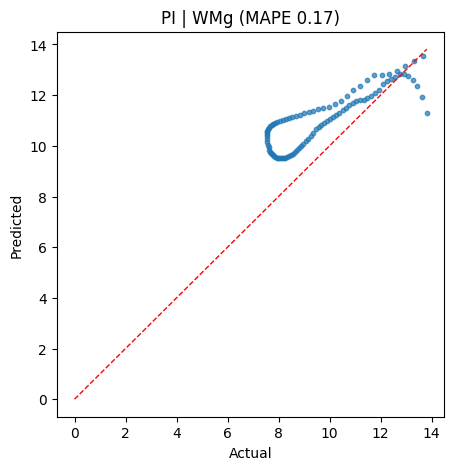

[PI] Left-out: WMg | Test MAPE: 0.1703
[PI] WNb | Epoch 10/100 Loss: 73.0254
[PI] WNb | Epoch 20/100 Loss: 36.1992
[PI] WNb | Epoch 30/100 Loss: 10.7590
[PI] WNb | Epoch 40/100 Loss: 3.6511
[PI] WNb | Epoch 50/100 Loss: 2.8048
[PI] WNb | Epoch 60/100 Loss: 2.5277
[PI] WNb | Epoch 70/100 Loss: 2.3044
[PI] WNb | Epoch 80/100 Loss: 2.1292
[PI] WNb | Epoch 90/100 Loss: 2.0292
[PI] WNb | Epoch 100/100 Loss: 1.9983


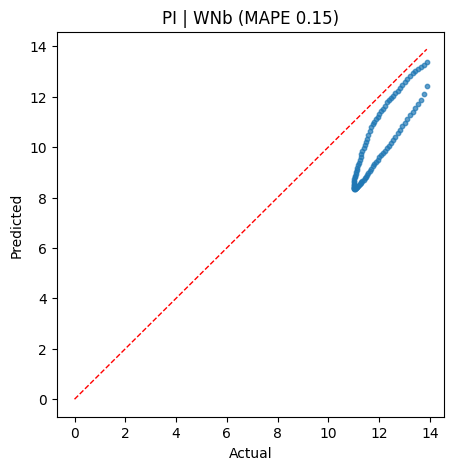

[PI] Left-out: WNb | Test MAPE: 0.1531
PI mean MAPE: 0.1869
test
[EP] AgAl | Epoch 10/100 Loss: 76.6163
[EP] AgAl | Epoch 20/100 Loss: 41.1764
[EP] AgAl | Epoch 30/100 Loss: 14.3129
[EP] AgAl | Epoch 40/100 Loss: 3.8515
[EP] AgAl | Epoch 50/100 Loss: 2.2623
[EP] AgAl | Epoch 60/100 Loss: 2.0144
[EP] AgAl | Epoch 70/100 Loss: 1.9086
[EP] AgAl | Epoch 80/100 Loss: 1.8398
[EP] AgAl | Epoch 90/100 Loss: 1.7475
[EP] AgAl | Epoch 100/100 Loss: 1.7345


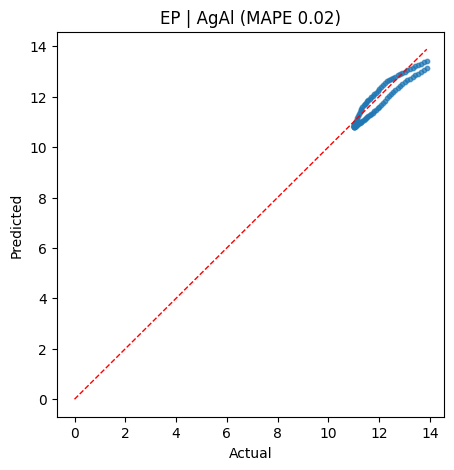

[EP] Left-out: AgAl | Test MAPE: 0.0234
[EP] AlMg | Epoch 10/100 Loss: 77.9834
[EP] AlMg | Epoch 20/100 Loss: 40.2644
[EP] AlMg | Epoch 30/100 Loss: 12.9151
[EP] AlMg | Epoch 40/100 Loss: 3.4484
[EP] AlMg | Epoch 50/100 Loss: 2.0869
[EP] AlMg | Epoch 60/100 Loss: 1.9746
[EP] AlMg | Epoch 70/100 Loss: 1.7971
[EP] AlMg | Epoch 80/100 Loss: 1.7278
[EP] AlMg | Epoch 90/100 Loss: 1.6789
[EP] AlMg | Epoch 100/100 Loss: 1.6134


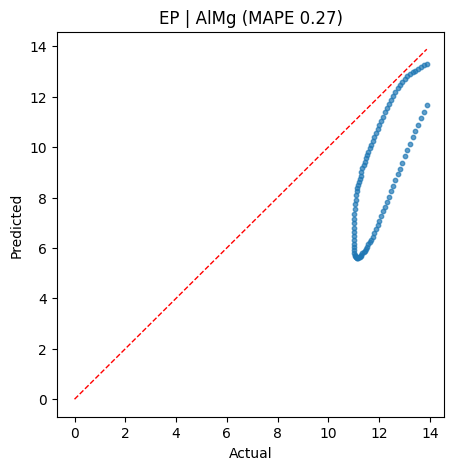

[EP] Left-out: AlMg | Test MAPE: 0.2726
[EP] AlNi | Epoch 10/100 Loss: 69.8577
[EP] AlNi | Epoch 20/100 Loss: 34.3583
[EP] AlNi | Epoch 30/100 Loss: 10.2488
[EP] AlNi | Epoch 40/100 Loss: 2.9885
[EP] AlNi | Epoch 50/100 Loss: 2.0623
[EP] AlNi | Epoch 60/100 Loss: 1.8704
[EP] AlNi | Epoch 70/100 Loss: 1.7323
[EP] AlNi | Epoch 80/100 Loss: 1.6387
[EP] AlNi | Epoch 90/100 Loss: 1.5667
[EP] AlNi | Epoch 100/100 Loss: 1.5765


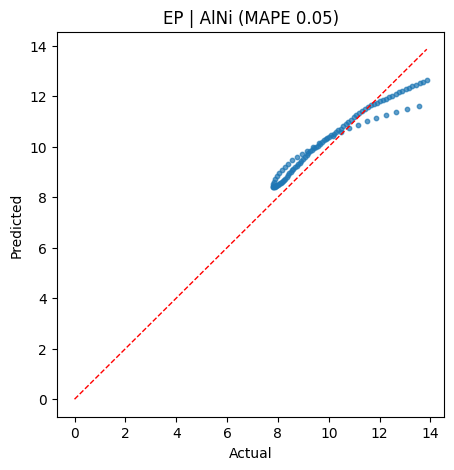

[EP] Left-out: AlNi | Test MAPE: 0.0550
[EP] AlTi | Epoch 10/100 Loss: 75.2644
[EP] AlTi | Epoch 20/100 Loss: 37.3390
[EP] AlTi | Epoch 30/100 Loss: 10.3951
[EP] AlTi | Epoch 40/100 Loss: 2.9336
[EP] AlTi | Epoch 50/100 Loss: 2.0417
[EP] AlTi | Epoch 60/100 Loss: 1.8319
[EP] AlTi | Epoch 70/100 Loss: 1.8104
[EP] AlTi | Epoch 80/100 Loss: 1.5831
[EP] AlTi | Epoch 90/100 Loss: 1.5384
[EP] AlTi | Epoch 100/100 Loss: 1.5790


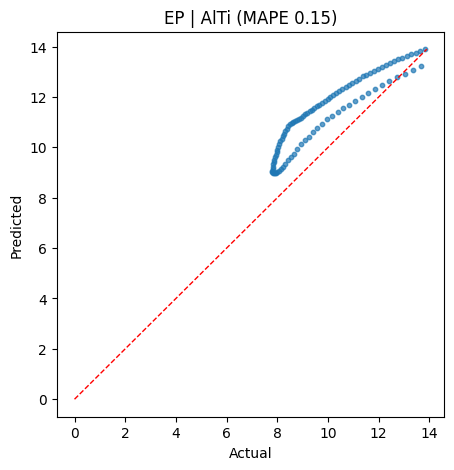

[EP] Left-out: AlTi | Test MAPE: 0.1520
[EP] AlV | Epoch 10/100 Loss: 71.7959
[EP] AlV | Epoch 20/100 Loss: 31.8428
[EP] AlV | Epoch 30/100 Loss: 7.9336
[EP] AlV | Epoch 40/100 Loss: 2.5418
[EP] AlV | Epoch 50/100 Loss: 1.9198
[EP] AlV | Epoch 60/100 Loss: 1.7795
[EP] AlV | Epoch 70/100 Loss: 1.7844
[EP] AlV | Epoch 80/100 Loss: 1.6073
[EP] AlV | Epoch 90/100 Loss: 1.5039
[EP] AlV | Epoch 100/100 Loss: 1.4572


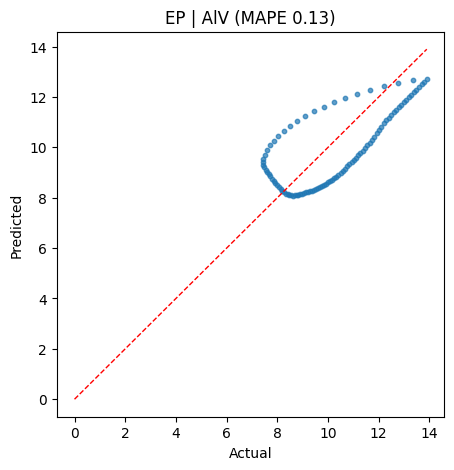

[EP] Left-out: AlV | Test MAPE: 0.1282
[EP] AuAl | Epoch 10/100 Loss: 67.1576
[EP] AuAl | Epoch 20/100 Loss: 30.5566
[EP] AuAl | Epoch 30/100 Loss: 7.9683
[EP] AuAl | Epoch 40/100 Loss: 2.4882
[EP] AuAl | Epoch 50/100 Loss: 1.9060
[EP] AuAl | Epoch 60/100 Loss: 1.8545
[EP] AuAl | Epoch 70/100 Loss: 1.7211
[EP] AuAl | Epoch 80/100 Loss: 1.6969
[EP] AuAl | Epoch 90/100 Loss: 1.6155
[EP] AuAl | Epoch 100/100 Loss: 1.5824


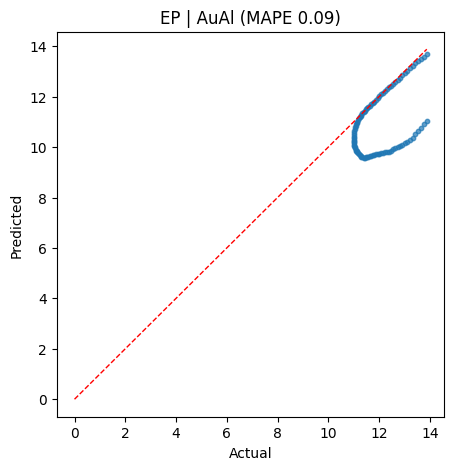

[EP] Left-out: AuAl | Test MAPE: 0.0886
[EP] AuCr | Epoch 10/100 Loss: 74.1053
[EP] AuCr | Epoch 20/100 Loss: 37.0399
[EP] AuCr | Epoch 30/100 Loss: 10.7545
[EP] AuCr | Epoch 40/100 Loss: 2.8227
[EP] AuCr | Epoch 50/100 Loss: 1.9720
[EP] AuCr | Epoch 60/100 Loss: 1.7810
[EP] AuCr | Epoch 70/100 Loss: 1.7585
[EP] AuCr | Epoch 80/100 Loss: 1.5286
[EP] AuCr | Epoch 90/100 Loss: 1.5570
[EP] AuCr | Epoch 100/100 Loss: 1.4582


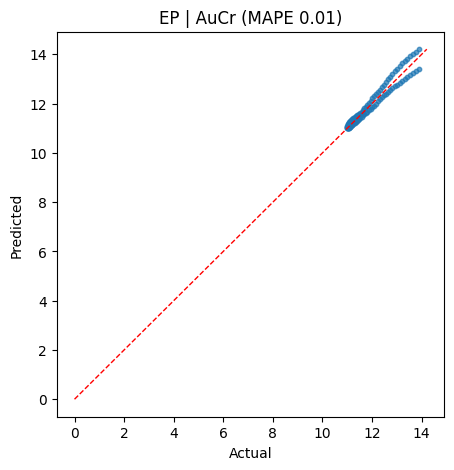

[EP] Left-out: AuCr | Test MAPE: 0.0148
[EP] AuHf | Epoch 10/100 Loss: 82.4472
[EP] AuHf | Epoch 20/100 Loss: 45.7450
[EP] AuHf | Epoch 30/100 Loss: 15.0606
[EP] AuHf | Epoch 40/100 Loss: 3.7110
[EP] AuHf | Epoch 50/100 Loss: 2.1964
[EP] AuHf | Epoch 60/100 Loss: 2.0046
[EP] AuHf | Epoch 70/100 Loss: 2.0300
[EP] AuHf | Epoch 80/100 Loss: 1.7826
[EP] AuHf | Epoch 90/100 Loss: 1.7924
[EP] AuHf | Epoch 100/100 Loss: 1.7284


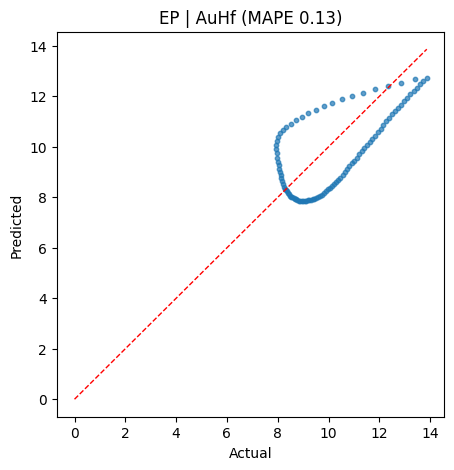

[EP] Left-out: AuHf | Test MAPE: 0.1319
[EP] AuMg | Epoch 10/100 Loss: 76.9989
[EP] AuMg | Epoch 20/100 Loss: 39.8539
[EP] AuMg | Epoch 30/100 Loss: 12.3345
[EP] AuMg | Epoch 40/100 Loss: 3.2721
[EP] AuMg | Epoch 50/100 Loss: 2.1121
[EP] AuMg | Epoch 60/100 Loss: 2.0083
[EP] AuMg | Epoch 70/100 Loss: 1.7846
[EP] AuMg | Epoch 80/100 Loss: 1.6880
[EP] AuMg | Epoch 90/100 Loss: 1.6171
[EP] AuMg | Epoch 100/100 Loss: 1.4764


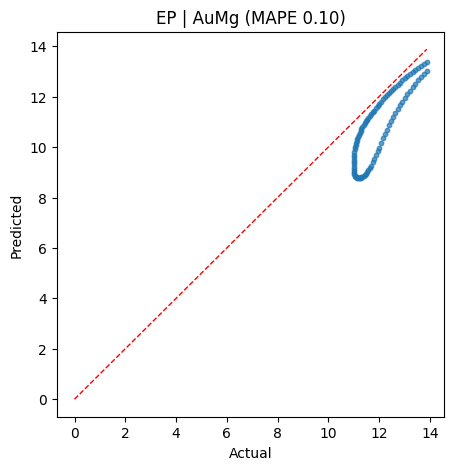

[EP] Left-out: AuMg | Test MAPE: 0.1048
[EP] CoMg | Epoch 10/100 Loss: 74.7371
[EP] CoMg | Epoch 20/100 Loss: 33.8481
[EP] CoMg | Epoch 30/100 Loss: 8.5635
[EP] CoMg | Epoch 40/100 Loss: 2.4410
[EP] CoMg | Epoch 50/100 Loss: 1.9939
[EP] CoMg | Epoch 60/100 Loss: 1.8094
[EP] CoMg | Epoch 70/100 Loss: 1.6229
[EP] CoMg | Epoch 80/100 Loss: 1.5922
[EP] CoMg | Epoch 90/100 Loss: 1.5557
[EP] CoMg | Epoch 100/100 Loss: 1.4852


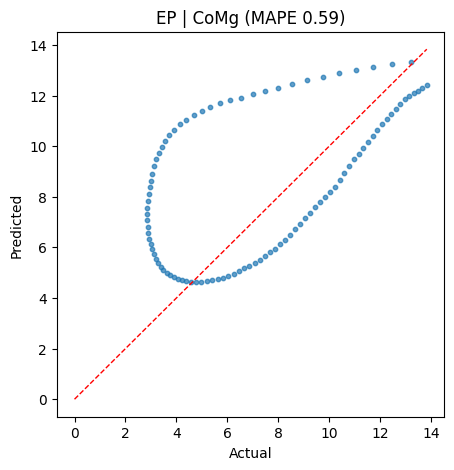

[EP] Left-out: CoMg | Test MAPE: 0.5901
[EP] CrAl | Epoch 10/100 Loss: 73.0827
[EP] CrAl | Epoch 20/100 Loss: 37.5636
[EP] CrAl | Epoch 30/100 Loss: 12.1355
[EP] CrAl | Epoch 40/100 Loss: 3.3868
[EP] CrAl | Epoch 50/100 Loss: 2.2353
[EP] CrAl | Epoch 60/100 Loss: 2.0207
[EP] CrAl | Epoch 70/100 Loss: 1.8607
[EP] CrAl | Epoch 80/100 Loss: 1.6936
[EP] CrAl | Epoch 90/100 Loss: 1.7610
[EP] CrAl | Epoch 100/100 Loss: 1.6048


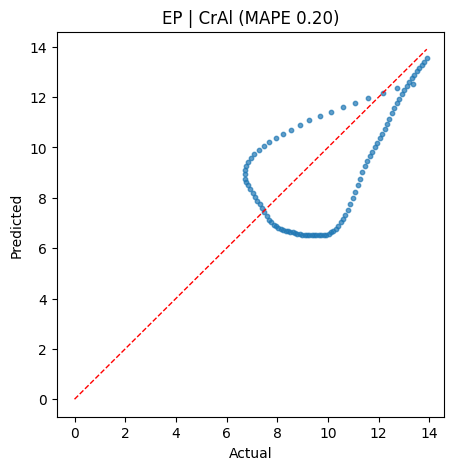

[EP] Left-out: CrAl | Test MAPE: 0.1959
[EP] CrCo | Epoch 10/100 Loss: 70.1855
[EP] CrCo | Epoch 20/100 Loss: 35.1271
[EP] CrCo | Epoch 30/100 Loss: 10.7029
[EP] CrCo | Epoch 40/100 Loss: 2.9725
[EP] CrCo | Epoch 50/100 Loss: 2.1077
[EP] CrCo | Epoch 60/100 Loss: 1.9177
[EP] CrCo | Epoch 70/100 Loss: 1.7941
[EP] CrCo | Epoch 80/100 Loss: 1.7291
[EP] CrCo | Epoch 90/100 Loss: 1.5843
[EP] CrCo | Epoch 100/100 Loss: 1.4945


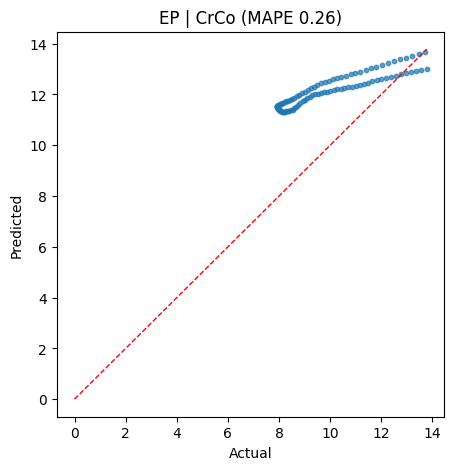

[EP] Left-out: CrCo | Test MAPE: 0.2571
[EP] CrMg | Epoch 10/100 Loss: 66.2487
[EP] CrMg | Epoch 20/100 Loss: 30.5942
[EP] CrMg | Epoch 30/100 Loss: 8.8953
[EP] CrMg | Epoch 40/100 Loss: 2.7750
[EP] CrMg | Epoch 50/100 Loss: 1.9967
[EP] CrMg | Epoch 60/100 Loss: 1.8976
[EP] CrMg | Epoch 70/100 Loss: 1.6913
[EP] CrMg | Epoch 80/100 Loss: 1.7553
[EP] CrMg | Epoch 90/100 Loss: 1.6735
[EP] CrMg | Epoch 100/100 Loss: 1.5626


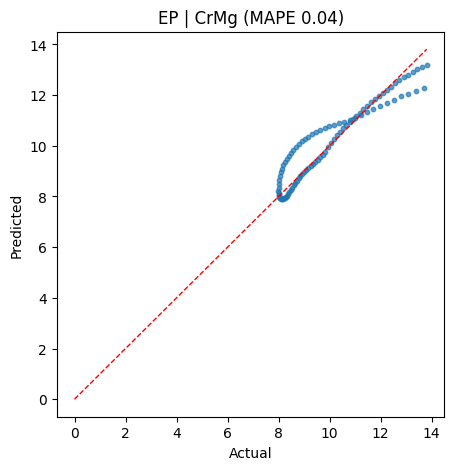

[EP] Left-out: CrMg | Test MAPE: 0.0421
[EP] CrNi | Epoch 10/100 Loss: 83.7720
[EP] CrNi | Epoch 20/100 Loss: 46.6317
[EP] CrNi | Epoch 30/100 Loss: 16.1562
[EP] CrNi | Epoch 40/100 Loss: 4.1961
[EP] CrNi | Epoch 50/100 Loss: 2.2258
[EP] CrNi | Epoch 60/100 Loss: 2.0332
[EP] CrNi | Epoch 70/100 Loss: 1.8667
[EP] CrNi | Epoch 80/100 Loss: 1.8137
[EP] CrNi | Epoch 90/100 Loss: 1.6924
[EP] CrNi | Epoch 100/100 Loss: 1.6672


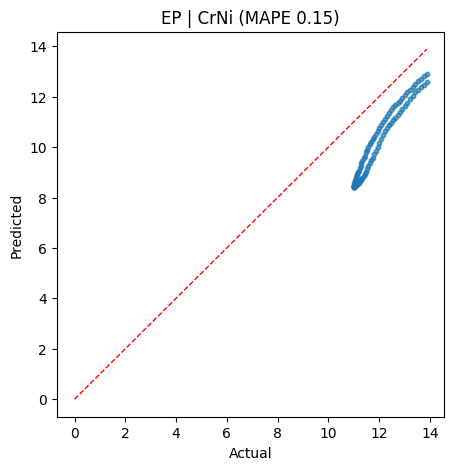

[EP] Left-out: CrNi | Test MAPE: 0.1548
[EP] CrV | Epoch 10/100 Loss: 70.8726
[EP] CrV | Epoch 20/100 Loss: 34.2196
[EP] CrV | Epoch 30/100 Loss: 9.4585
[EP] CrV | Epoch 40/100 Loss: 2.5936
[EP] CrV | Epoch 50/100 Loss: 1.9774
[EP] CrV | Epoch 60/100 Loss: 1.8047
[EP] CrV | Epoch 70/100 Loss: 1.6798
[EP] CrV | Epoch 80/100 Loss: 1.6194
[EP] CrV | Epoch 90/100 Loss: 1.5576
[EP] CrV | Epoch 100/100 Loss: 1.5308


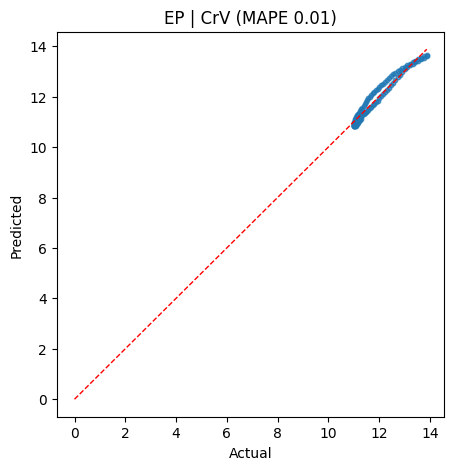

[EP] Left-out: CrV | Test MAPE: 0.0137
[EP] CuAl | Epoch 10/100 Loss: 77.7067
[EP] CuAl | Epoch 20/100 Loss: 40.8898
[EP] CuAl | Epoch 30/100 Loss: 11.4805
[EP] CuAl | Epoch 40/100 Loss: 2.9186
[EP] CuAl | Epoch 50/100 Loss: 2.0333
[EP] CuAl | Epoch 60/100 Loss: 1.8442
[EP] CuAl | Epoch 70/100 Loss: 1.6342
[EP] CuAl | Epoch 80/100 Loss: 1.6342
[EP] CuAl | Epoch 90/100 Loss: 1.5289
[EP] CuAl | Epoch 100/100 Loss: 1.4770


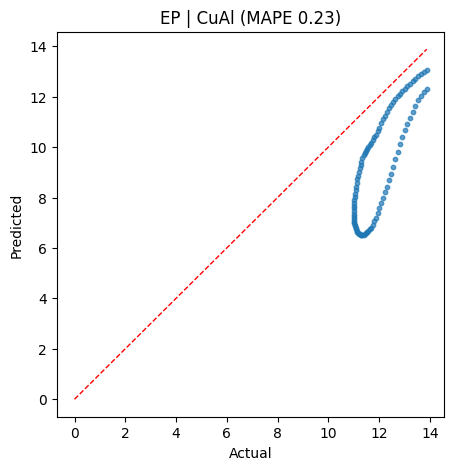

[EP] Left-out: CuAl | Test MAPE: 0.2331
[EP] CuMg | Epoch 10/100 Loss: 69.8318
[EP] CuMg | Epoch 20/100 Loss: 34.5930
[EP] CuMg | Epoch 30/100 Loss: 9.6084
[EP] CuMg | Epoch 40/100 Loss: 2.8072
[EP] CuMg | Epoch 50/100 Loss: 2.1042
[EP] CuMg | Epoch 60/100 Loss: 1.8305
[EP] CuMg | Epoch 70/100 Loss: 1.7578
[EP] CuMg | Epoch 80/100 Loss: 1.6723
[EP] CuMg | Epoch 90/100 Loss: 1.6114
[EP] CuMg | Epoch 100/100 Loss: 1.5151


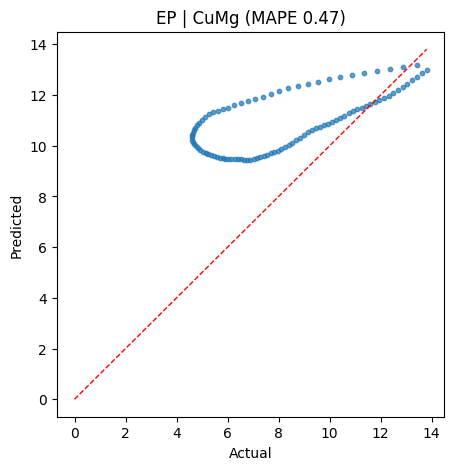

[EP] Left-out: CuMg | Test MAPE: 0.4657
[EP] CuNi | Epoch 10/100 Loss: 72.8572
[EP] CuNi | Epoch 20/100 Loss: 37.7059
[EP] CuNi | Epoch 30/100 Loss: 12.1557
[EP] CuNi | Epoch 40/100 Loss: 3.1463
[EP] CuNi | Epoch 50/100 Loss: 2.1320
[EP] CuNi | Epoch 60/100 Loss: 1.9005
[EP] CuNi | Epoch 70/100 Loss: 1.8312
[EP] CuNi | Epoch 80/100 Loss: 1.6888
[EP] CuNi | Epoch 90/100 Loss: 1.6753
[EP] CuNi | Epoch 100/100 Loss: 1.5963


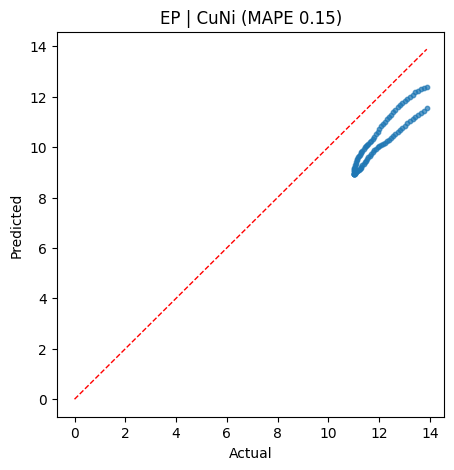

[EP] Left-out: CuNi | Test MAPE: 0.1491
[EP] CuSi | Epoch 10/100 Loss: 78.5327
[EP] CuSi | Epoch 20/100 Loss: 38.1665
[EP] CuSi | Epoch 30/100 Loss: 10.4548
[EP] CuSi | Epoch 40/100 Loss: 2.8865
[EP] CuSi | Epoch 50/100 Loss: 1.9483
[EP] CuSi | Epoch 60/100 Loss: 1.8974
[EP] CuSi | Epoch 70/100 Loss: 1.8221
[EP] CuSi | Epoch 80/100 Loss: 1.7775
[EP] CuSi | Epoch 90/100 Loss: 1.6379
[EP] CuSi | Epoch 100/100 Loss: 1.5810


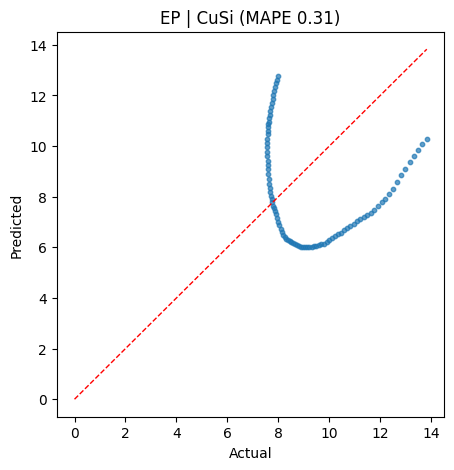

[EP] Left-out: CuSi | Test MAPE: 0.3112
[EP] CuZr | Epoch 10/100 Loss: 67.5495
[EP] CuZr | Epoch 20/100 Loss: 29.7792
[EP] CuZr | Epoch 30/100 Loss: 7.3389
[EP] CuZr | Epoch 40/100 Loss: 2.4789
[EP] CuZr | Epoch 50/100 Loss: 1.8950
[EP] CuZr | Epoch 60/100 Loss: 1.8214
[EP] CuZr | Epoch 70/100 Loss: 1.6966
[EP] CuZr | Epoch 80/100 Loss: 1.6308
[EP] CuZr | Epoch 90/100 Loss: 1.5833
[EP] CuZr | Epoch 100/100 Loss: 1.5088


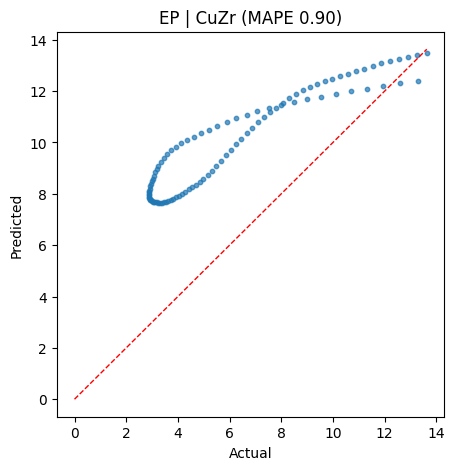

[EP] Left-out: CuZr | Test MAPE: 0.9016
[EP] FeAl | Epoch 10/100 Loss: 75.6749
[EP] FeAl | Epoch 20/100 Loss: 38.7604
[EP] FeAl | Epoch 30/100 Loss: 11.5906
[EP] FeAl | Epoch 40/100 Loss: 3.0050
[EP] FeAl | Epoch 50/100 Loss: 2.0624
[EP] FeAl | Epoch 60/100 Loss: 1.8534
[EP] FeAl | Epoch 70/100 Loss: 1.6766
[EP] FeAl | Epoch 80/100 Loss: 1.5764
[EP] FeAl | Epoch 90/100 Loss: 1.5666
[EP] FeAl | Epoch 100/100 Loss: 1.5445


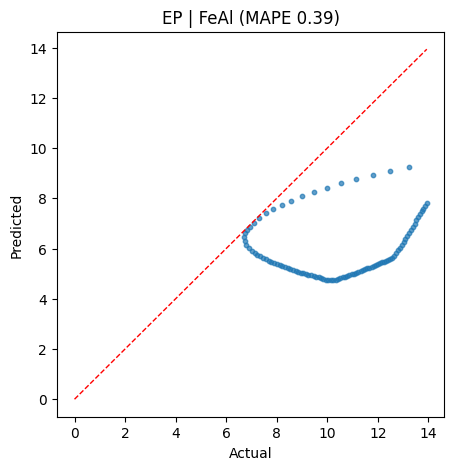

[EP] Left-out: FeAl | Test MAPE: 0.3924
[EP] GeMg | Epoch 10/100 Loss: 65.5936
[EP] GeMg | Epoch 20/100 Loss: 30.8992
[EP] GeMg | Epoch 30/100 Loss: 9.1602
[EP] GeMg | Epoch 40/100 Loss: 2.7093
[EP] GeMg | Epoch 50/100 Loss: 1.9010
[EP] GeMg | Epoch 60/100 Loss: 1.7884
[EP] GeMg | Epoch 70/100 Loss: 1.7726
[EP] GeMg | Epoch 80/100 Loss: 1.5822
[EP] GeMg | Epoch 90/100 Loss: 1.6006
[EP] GeMg | Epoch 100/100 Loss: 1.4990


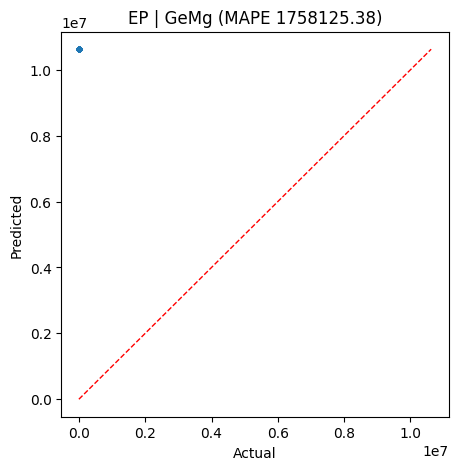

[EP] Left-out: GeMg | Test MAPE: 1758125.3750
[EP] HfAl | Epoch 10/100 Loss: 77.9482
[EP] HfAl | Epoch 20/100 Loss: 41.9978
[EP] HfAl | Epoch 30/100 Loss: 13.8667
[EP] HfAl | Epoch 40/100 Loss: 3.6289
[EP] HfAl | Epoch 50/100 Loss: 2.2115
[EP] HfAl | Epoch 60/100 Loss: 1.9845
[EP] HfAl | Epoch 70/100 Loss: 1.7918
[EP] HfAl | Epoch 80/100 Loss: 1.8120
[EP] HfAl | Epoch 90/100 Loss: 1.7217
[EP] HfAl | Epoch 100/100 Loss: 1.6812


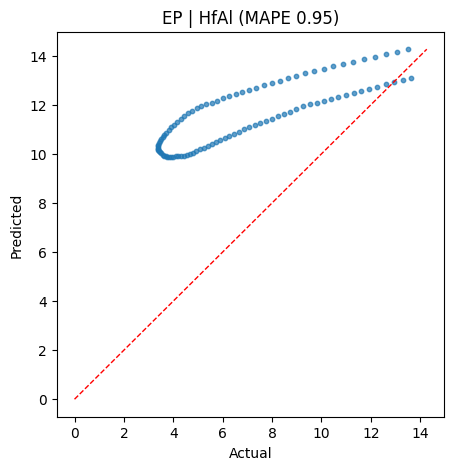

[EP] Left-out: HfAl | Test MAPE: 0.9481
[EP] HfFe | Epoch 10/100 Loss: 71.2477
[EP] HfFe | Epoch 20/100 Loss: 35.7130
[EP] HfFe | Epoch 30/100 Loss: 10.8196
[EP] HfFe | Epoch 40/100 Loss: 3.0779
[EP] HfFe | Epoch 50/100 Loss: 2.1023
[EP] HfFe | Epoch 60/100 Loss: 1.8314
[EP] HfFe | Epoch 70/100 Loss: 1.7673
[EP] HfFe | Epoch 80/100 Loss: 1.6882
[EP] HfFe | Epoch 90/100 Loss: 1.5826
[EP] HfFe | Epoch 100/100 Loss: 1.6145


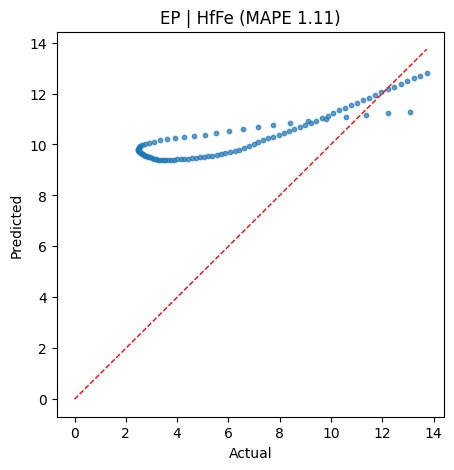

[EP] Left-out: HfFe | Test MAPE: 1.1104
[EP] HfMg | Epoch 10/100 Loss: 76.9593
[EP] HfMg | Epoch 20/100 Loss: 37.1175
[EP] HfMg | Epoch 30/100 Loss: 10.2777
[EP] HfMg | Epoch 40/100 Loss: 2.9428
[EP] HfMg | Epoch 50/100 Loss: 2.0453
[EP] HfMg | Epoch 60/100 Loss: 1.8485
[EP] HfMg | Epoch 70/100 Loss: 1.6573
[EP] HfMg | Epoch 80/100 Loss: 1.6641
[EP] HfMg | Epoch 90/100 Loss: 1.5674
[EP] HfMg | Epoch 100/100 Loss: 1.5214


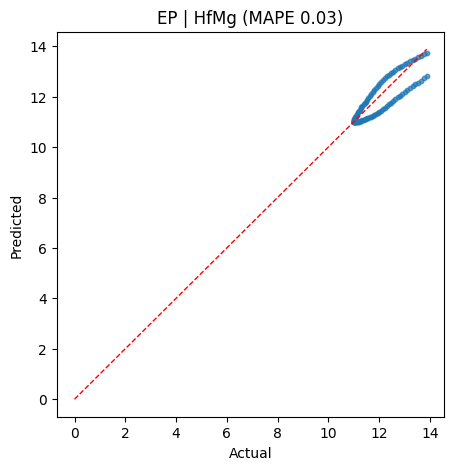

[EP] Left-out: HfMg | Test MAPE: 0.0309
[EP] HfTi | Epoch 10/100 Loss: 76.4642
[EP] HfTi | Epoch 20/100 Loss: 37.6460
[EP] HfTi | Epoch 30/100 Loss: 10.8883
[EP] HfTi | Epoch 40/100 Loss: 3.0061
[EP] HfTi | Epoch 50/100 Loss: 2.1127
[EP] HfTi | Epoch 60/100 Loss: 1.8480
[EP] HfTi | Epoch 70/100 Loss: 1.7374
[EP] HfTi | Epoch 80/100 Loss: 1.6938
[EP] HfTi | Epoch 90/100 Loss: 1.5676
[EP] HfTi | Epoch 100/100 Loss: 1.6210


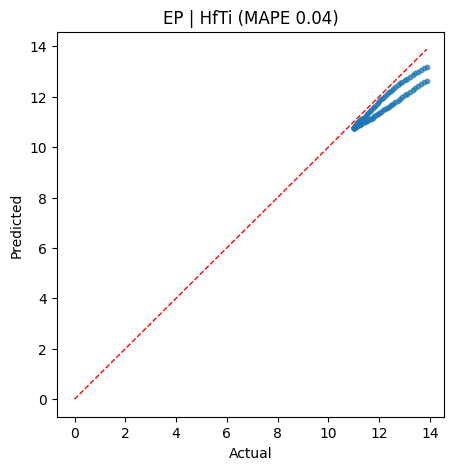

[EP] Left-out: HfTi | Test MAPE: 0.0361
[EP] HfY | Epoch 10/100 Loss: 82.2822
[EP] HfY | Epoch 20/100 Loss: 49.0784
[EP] HfY | Epoch 30/100 Loss: 19.6713
[EP] HfY | Epoch 40/100 Loss: 4.8237
[EP] HfY | Epoch 50/100 Loss: 2.4587
[EP] HfY | Epoch 60/100 Loss: 2.1019
[EP] HfY | Epoch 70/100 Loss: 1.9672
[EP] HfY | Epoch 80/100 Loss: 1.7995
[EP] HfY | Epoch 90/100 Loss: 1.8382
[EP] HfY | Epoch 100/100 Loss: 1.7376


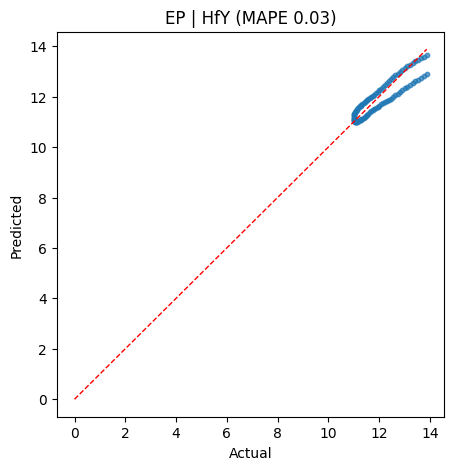

[EP] Left-out: HfY | Test MAPE: 0.0257
[EP] HfZr | Epoch 10/100 Loss: 71.5564
[EP] HfZr | Epoch 20/100 Loss: 34.7593
[EP] HfZr | Epoch 30/100 Loss: 10.3485
[EP] HfZr | Epoch 40/100 Loss: 2.7309
[EP] HfZr | Epoch 50/100 Loss: 1.9908
[EP] HfZr | Epoch 60/100 Loss: 1.8112
[EP] HfZr | Epoch 70/100 Loss: 1.7695
[EP] HfZr | Epoch 80/100 Loss: 1.6273
[EP] HfZr | Epoch 90/100 Loss: 1.6159
[EP] HfZr | Epoch 100/100 Loss: 1.5065


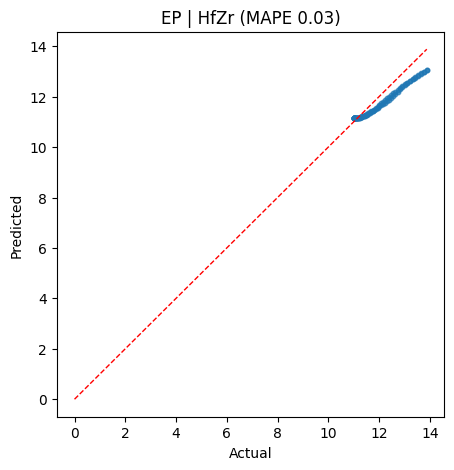

[EP] Left-out: HfZr | Test MAPE: 0.0257
[EP] MnAg | Epoch 10/100 Loss: 74.3671
[EP] MnAg | Epoch 20/100 Loss: 38.4321
[EP] MnAg | Epoch 30/100 Loss: 11.6348
[EP] MnAg | Epoch 40/100 Loss: 3.0354
[EP] MnAg | Epoch 50/100 Loss: 2.1026
[EP] MnAg | Epoch 60/100 Loss: 1.8912
[EP] MnAg | Epoch 70/100 Loss: 1.8052
[EP] MnAg | Epoch 80/100 Loss: 1.7195
[EP] MnAg | Epoch 90/100 Loss: 1.6031
[EP] MnAg | Epoch 100/100 Loss: 1.5683


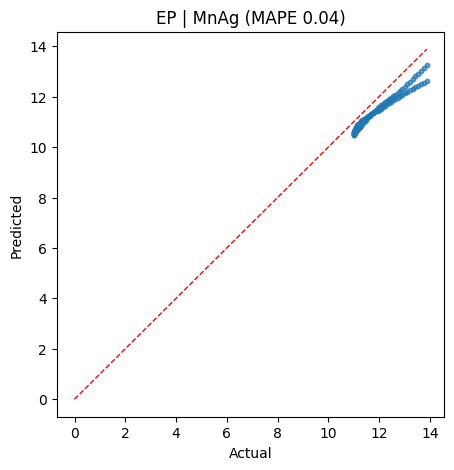

[EP] Left-out: MnAg | Test MAPE: 0.0431
[EP] MnAl | Epoch 10/100 Loss: 82.5060
[EP] MnAl | Epoch 20/100 Loss: 44.8898
[EP] MnAl | Epoch 30/100 Loss: 14.0460
[EP] MnAl | Epoch 40/100 Loss: 3.5146
[EP] MnAl | Epoch 50/100 Loss: 2.2082
[EP] MnAl | Epoch 60/100 Loss: 1.9253
[EP] MnAl | Epoch 70/100 Loss: 1.8076
[EP] MnAl | Epoch 80/100 Loss: 1.7225
[EP] MnAl | Epoch 90/100 Loss: 1.6032
[EP] MnAl | Epoch 100/100 Loss: 1.4956


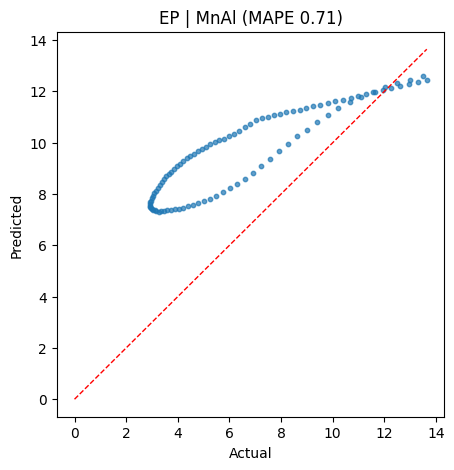

[EP] Left-out: MnAl | Test MAPE: 0.7059
[EP] MnMg | Epoch 10/100 Loss: 70.1440
[EP] MnMg | Epoch 20/100 Loss: 33.7038
[EP] MnMg | Epoch 30/100 Loss: 10.1599
[EP] MnMg | Epoch 40/100 Loss: 2.8462
[EP] MnMg | Epoch 50/100 Loss: 1.9806
[EP] MnMg | Epoch 60/100 Loss: 1.8049
[EP] MnMg | Epoch 70/100 Loss: 1.7928
[EP] MnMg | Epoch 80/100 Loss: 1.7008
[EP] MnMg | Epoch 90/100 Loss: 1.6057
[EP] MnMg | Epoch 100/100 Loss: 1.6099


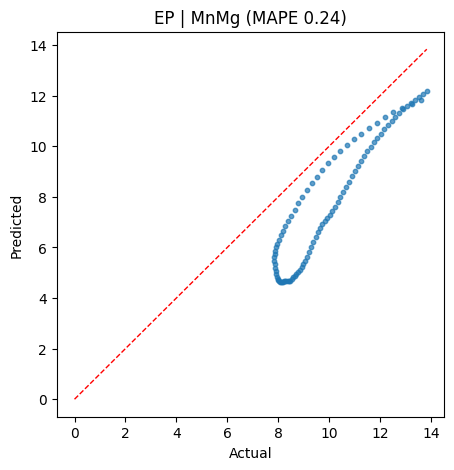

[EP] Left-out: MnMg | Test MAPE: 0.2391
[EP] MoCu | Epoch 10/100 Loss: 65.1756
[EP] MoCu | Epoch 20/100 Loss: 28.0200
[EP] MoCu | Epoch 30/100 Loss: 6.9115
[EP] MoCu | Epoch 40/100 Loss: 2.4279
[EP] MoCu | Epoch 50/100 Loss: 1.9667
[EP] MoCu | Epoch 60/100 Loss: 1.7449
[EP] MoCu | Epoch 70/100 Loss: 1.6170
[EP] MoCu | Epoch 80/100 Loss: 1.6540
[EP] MoCu | Epoch 90/100 Loss: 1.4910
[EP] MoCu | Epoch 100/100 Loss: 1.4731


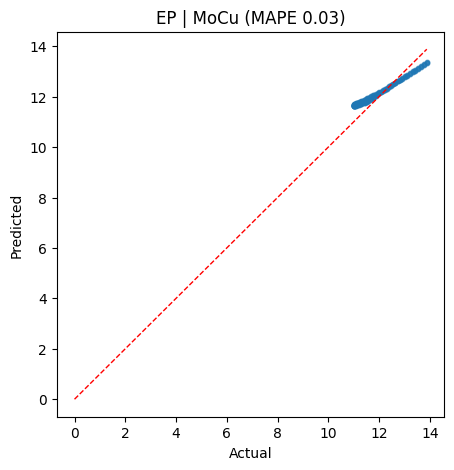

[EP] Left-out: MoCu | Test MAPE: 0.0307
[EP] MoMg | Epoch 10/100 Loss: 77.8499
[EP] MoMg | Epoch 20/100 Loss: 38.5138
[EP] MoMg | Epoch 30/100 Loss: 10.4417
[EP] MoMg | Epoch 40/100 Loss: 2.7729
[EP] MoMg | Epoch 50/100 Loss: 1.9689
[EP] MoMg | Epoch 60/100 Loss: 1.7794
[EP] MoMg | Epoch 70/100 Loss: 1.7671
[EP] MoMg | Epoch 80/100 Loss: 1.5909
[EP] MoMg | Epoch 90/100 Loss: 1.6168
[EP] MoMg | Epoch 100/100 Loss: 1.5562


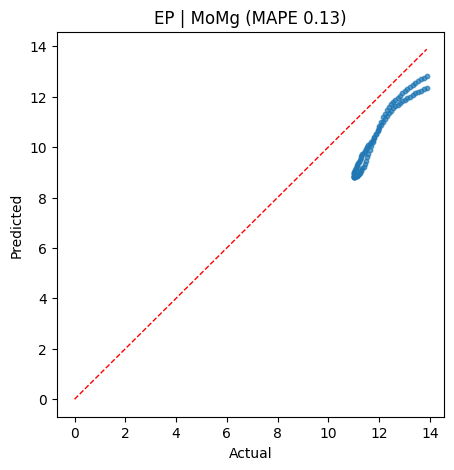

[EP] Left-out: MoMg | Test MAPE: 0.1306
[EP] MoTi | Epoch 10/100 Loss: 76.4912
[EP] MoTi | Epoch 20/100 Loss: 37.7131
[EP] MoTi | Epoch 30/100 Loss: 9.9519
[EP] MoTi | Epoch 40/100 Loss: 2.8870
[EP] MoTi | Epoch 50/100 Loss: 1.9681
[EP] MoTi | Epoch 60/100 Loss: 1.8146
[EP] MoTi | Epoch 70/100 Loss: 1.7872
[EP] MoTi | Epoch 80/100 Loss: 1.7067
[EP] MoTi | Epoch 90/100 Loss: 1.6086
[EP] MoTi | Epoch 100/100 Loss: 1.5761


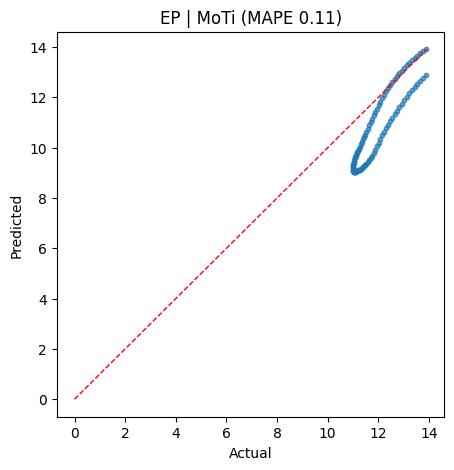

[EP] Left-out: MoTi | Test MAPE: 0.1061
[EP] MoZr | Epoch 10/100 Loss: 70.0456
[EP] MoZr | Epoch 20/100 Loss: 31.8552
[EP] MoZr | Epoch 30/100 Loss: 9.2190
[EP] MoZr | Epoch 40/100 Loss: 2.9664
[EP] MoZr | Epoch 50/100 Loss: 2.1128
[EP] MoZr | Epoch 60/100 Loss: 1.9466
[EP] MoZr | Epoch 70/100 Loss: 1.8166
[EP] MoZr | Epoch 80/100 Loss: 1.6531
[EP] MoZr | Epoch 90/100 Loss: 1.6163
[EP] MoZr | Epoch 100/100 Loss: 1.5802


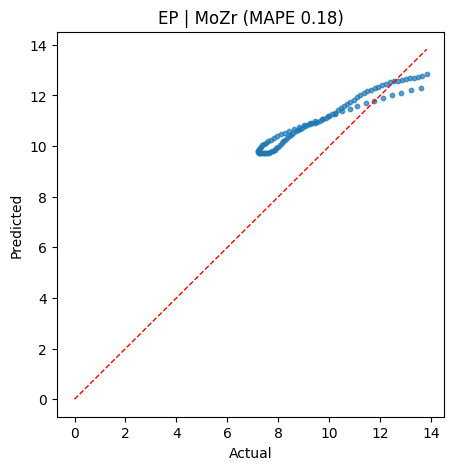

[EP] Left-out: MoZr | Test MAPE: 0.1795
[EP] NbMg | Epoch 10/100 Loss: 67.5573
[EP] NbMg | Epoch 20/100 Loss: 31.0598
[EP] NbMg | Epoch 30/100 Loss: 8.6547
[EP] NbMg | Epoch 40/100 Loss: 2.6912
[EP] NbMg | Epoch 50/100 Loss: 2.1045
[EP] NbMg | Epoch 60/100 Loss: 1.8978
[EP] NbMg | Epoch 70/100 Loss: 1.7480
[EP] NbMg | Epoch 80/100 Loss: 1.6039
[EP] NbMg | Epoch 90/100 Loss: 1.5862
[EP] NbMg | Epoch 100/100 Loss: 1.4472


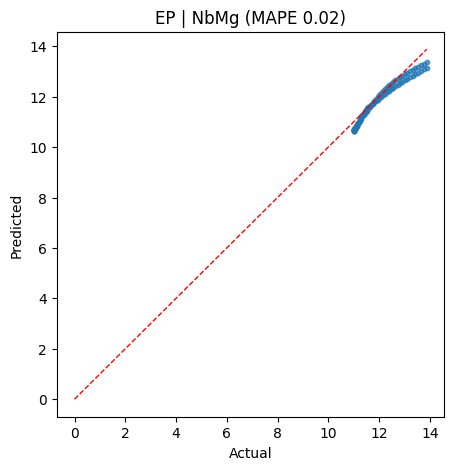

[EP] Left-out: NbMg | Test MAPE: 0.0171
[EP] NiMg | Epoch 10/100 Loss: 77.7749
[EP] NiMg | Epoch 20/100 Loss: 38.8714
[EP] NiMg | Epoch 30/100 Loss: 11.7686
[EP] NiMg | Epoch 40/100 Loss: 3.2720
[EP] NiMg | Epoch 50/100 Loss: 2.0528
[EP] NiMg | Epoch 60/100 Loss: 1.8367
[EP] NiMg | Epoch 70/100 Loss: 1.8716
[EP] NiMg | Epoch 80/100 Loss: 1.7220
[EP] NiMg | Epoch 90/100 Loss: 1.6588
[EP] NiMg | Epoch 100/100 Loss: 1.6171


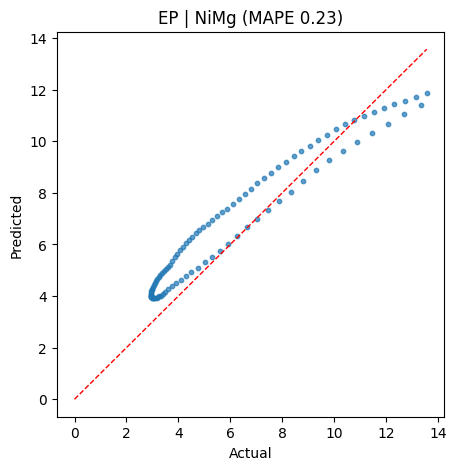

[EP] Left-out: NiMg | Test MAPE: 0.2261
[EP] PdFe | Epoch 10/100 Loss: 77.3279
[EP] PdFe | Epoch 20/100 Loss: 38.9174
[EP] PdFe | Epoch 30/100 Loss: 11.0095
[EP] PdFe | Epoch 40/100 Loss: 2.9519
[EP] PdFe | Epoch 50/100 Loss: 2.0773
[EP] PdFe | Epoch 60/100 Loss: 1.9241
[EP] PdFe | Epoch 70/100 Loss: 1.7704
[EP] PdFe | Epoch 80/100 Loss: 1.6607
[EP] PdFe | Epoch 90/100 Loss: 1.5981
[EP] PdFe | Epoch 100/100 Loss: 1.5680


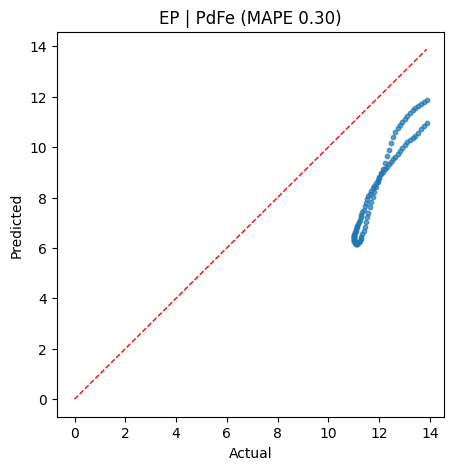

[EP] Left-out: PdFe | Test MAPE: 0.3049
[EP] PdMg | Epoch 10/100 Loss: 72.9816
[EP] PdMg | Epoch 20/100 Loss: 38.8535
[EP] PdMg | Epoch 30/100 Loss: 13.1899
[EP] PdMg | Epoch 40/100 Loss: 3.5549
[EP] PdMg | Epoch 50/100 Loss: 2.1156
[EP] PdMg | Epoch 60/100 Loss: 1.9358
[EP] PdMg | Epoch 70/100 Loss: 1.8726
[EP] PdMg | Epoch 80/100 Loss: 1.7422
[EP] PdMg | Epoch 90/100 Loss: 1.7109
[EP] PdMg | Epoch 100/100 Loss: 1.5865


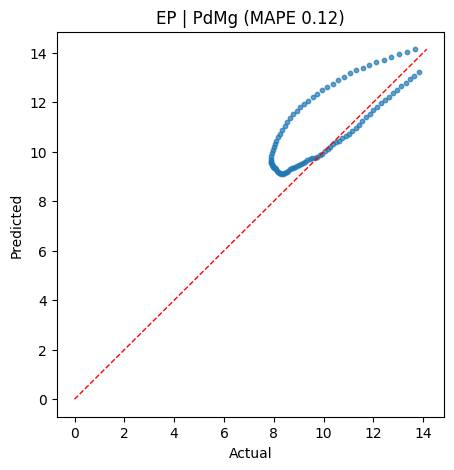

[EP] Left-out: PdMg | Test MAPE: 0.1244
[EP] PdSi | Epoch 10/100 Loss: 74.5580
[EP] PdSi | Epoch 20/100 Loss: 37.1345
[EP] PdSi | Epoch 30/100 Loss: 11.8065
[EP] PdSi | Epoch 40/100 Loss: 3.1435
[EP] PdSi | Epoch 50/100 Loss: 2.0612
[EP] PdSi | Epoch 60/100 Loss: 1.8851
[EP] PdSi | Epoch 70/100 Loss: 1.7792
[EP] PdSi | Epoch 80/100 Loss: 1.7545
[EP] PdSi | Epoch 90/100 Loss: 1.6778
[EP] PdSi | Epoch 100/100 Loss: 1.6262


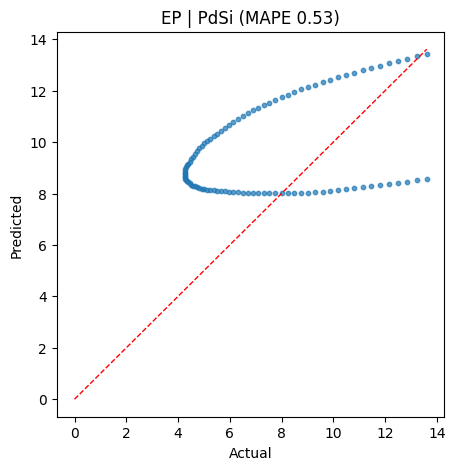

[EP] Left-out: PdSi | Test MAPE: 0.5299
[EP] PtGe | Epoch 10/100 Loss: 71.5518
[EP] PtGe | Epoch 20/100 Loss: 34.8446
[EP] PtGe | Epoch 30/100 Loss: 10.1981
[EP] PtGe | Epoch 40/100 Loss: 2.9069
[EP] PtGe | Epoch 50/100 Loss: 2.1366
[EP] PtGe | Epoch 60/100 Loss: 1.9682
[EP] PtGe | Epoch 70/100 Loss: 1.7816
[EP] PtGe | Epoch 80/100 Loss: 1.6539
[EP] PtGe | Epoch 90/100 Loss: 1.6358
[EP] PtGe | Epoch 100/100 Loss: 1.5844


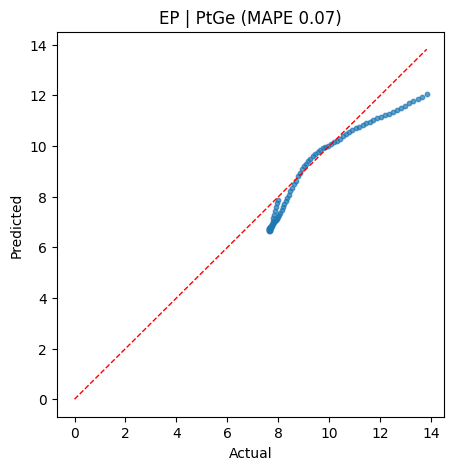

[EP] Left-out: PtGe | Test MAPE: 0.0699
[EP] PtMg | Epoch 10/100 Loss: 78.3106
[EP] PtMg | Epoch 20/100 Loss: 44.4719
[EP] PtMg | Epoch 30/100 Loss: 15.0574
[EP] PtMg | Epoch 40/100 Loss: 3.7095
[EP] PtMg | Epoch 50/100 Loss: 2.1823
[EP] PtMg | Epoch 60/100 Loss: 1.9185
[EP] PtMg | Epoch 70/100 Loss: 1.8569
[EP] PtMg | Epoch 80/100 Loss: 1.7785
[EP] PtMg | Epoch 90/100 Loss: 1.7010
[EP] PtMg | Epoch 100/100 Loss: 1.5880


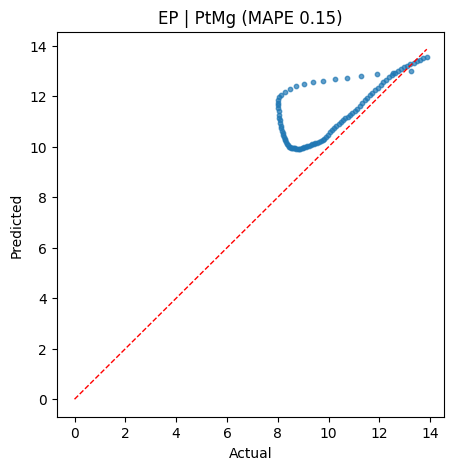

[EP] Left-out: PtMg | Test MAPE: 0.1492
[EP] SnMg | Epoch 10/100 Loss: 82.4136
[EP] SnMg | Epoch 20/100 Loss: 44.6621
[EP] SnMg | Epoch 30/100 Loss: 13.8900
[EP] SnMg | Epoch 40/100 Loss: 3.4106
[EP] SnMg | Epoch 50/100 Loss: 2.1686
[EP] SnMg | Epoch 60/100 Loss: 1.8982
[EP] SnMg | Epoch 70/100 Loss: 1.8256
[EP] SnMg | Epoch 80/100 Loss: 1.7209
[EP] SnMg | Epoch 90/100 Loss: 1.6946
[EP] SnMg | Epoch 100/100 Loss: 1.6698


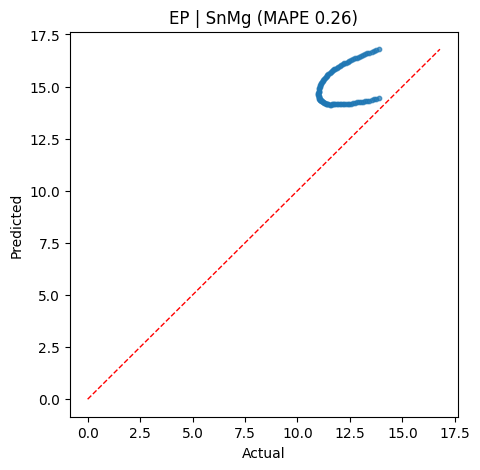

[EP] Left-out: SnMg | Test MAPE: 0.2588
[EP] TaMg | Epoch 10/100 Loss: 85.2725
[EP] TaMg | Epoch 20/100 Loss: 49.5035
[EP] TaMg | Epoch 30/100 Loss: 19.0778
[EP] TaMg | Epoch 40/100 Loss: 4.7927
[EP] TaMg | Epoch 50/100 Loss: 2.4026
[EP] TaMg | Epoch 60/100 Loss: 2.0877
[EP] TaMg | Epoch 70/100 Loss: 1.9238
[EP] TaMg | Epoch 80/100 Loss: 1.8467
[EP] TaMg | Epoch 90/100 Loss: 1.8002
[EP] TaMg | Epoch 100/100 Loss: 1.6800


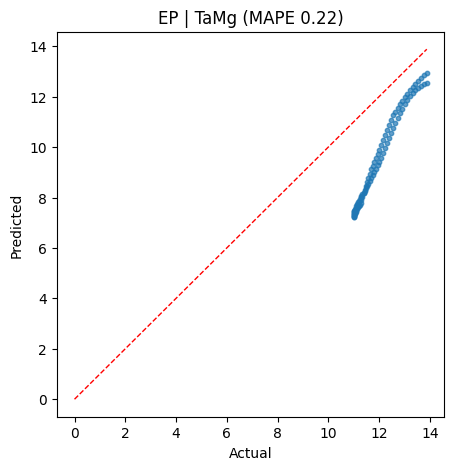

[EP] Left-out: TaMg | Test MAPE: 0.2154
[EP] TaMn | Epoch 10/100 Loss: 74.3705
[EP] TaMn | Epoch 20/100 Loss: 35.3027
[EP] TaMn | Epoch 30/100 Loss: 9.4300
[EP] TaMn | Epoch 40/100 Loss: 2.7720
[EP] TaMn | Epoch 50/100 Loss: 1.9739
[EP] TaMn | Epoch 60/100 Loss: 1.8585
[EP] TaMn | Epoch 70/100 Loss: 1.8303
[EP] TaMn | Epoch 80/100 Loss: 1.7188
[EP] TaMn | Epoch 90/100 Loss: 1.5857
[EP] TaMn | Epoch 100/100 Loss: 1.5522


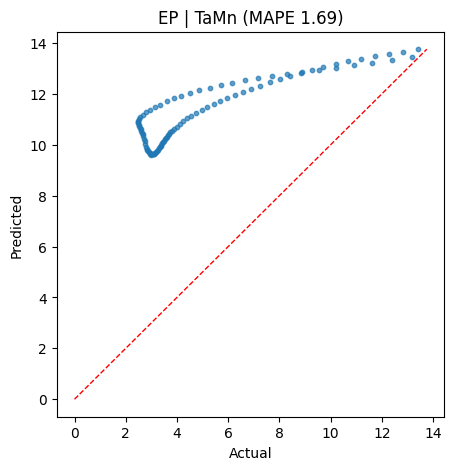

[EP] Left-out: TaMn | Test MAPE: 1.6871
[EP] TiMg | Epoch 10/100 Loss: 69.0558
[EP] TiMg | Epoch 20/100 Loss: 33.0352
[EP] TiMg | Epoch 30/100 Loss: 9.7251
[EP] TiMg | Epoch 40/100 Loss: 2.9112
[EP] TiMg | Epoch 50/100 Loss: 2.0958
[EP] TiMg | Epoch 60/100 Loss: 1.9489
[EP] TiMg | Epoch 70/100 Loss: 1.7529
[EP] TiMg | Epoch 80/100 Loss: 1.6333
[EP] TiMg | Epoch 90/100 Loss: 1.6205
[EP] TiMg | Epoch 100/100 Loss: 1.5309


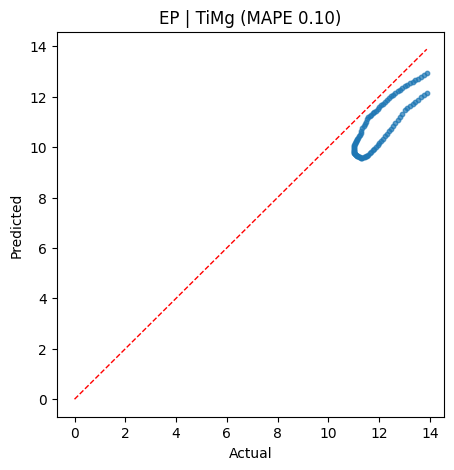

[EP] Left-out: TiMg | Test MAPE: 0.0964
[EP] TiZr | Epoch 10/100 Loss: 77.8749
[EP] TiZr | Epoch 20/100 Loss: 43.1086
[EP] TiZr | Epoch 30/100 Loss: 14.8561
[EP] TiZr | Epoch 40/100 Loss: 3.8765
[EP] TiZr | Epoch 50/100 Loss: 2.3299
[EP] TiZr | Epoch 60/100 Loss: 2.0220
[EP] TiZr | Epoch 70/100 Loss: 1.9629
[EP] TiZr | Epoch 80/100 Loss: 1.8455
[EP] TiZr | Epoch 90/100 Loss: 1.7124
[EP] TiZr | Epoch 100/100 Loss: 1.6898


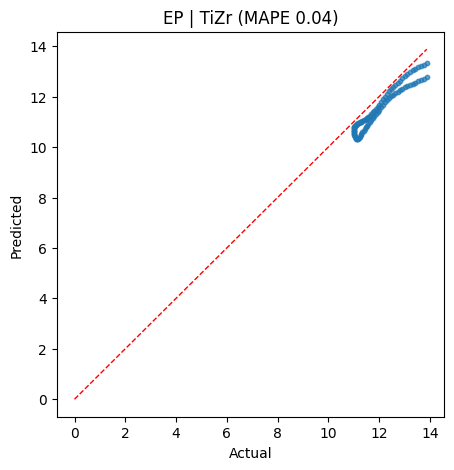

[EP] Left-out: TiZr | Test MAPE: 0.0393
[EP] VCu | Epoch 10/100 Loss: 66.4420
[EP] VCu | Epoch 20/100 Loss: 29.6844
[EP] VCu | Epoch 30/100 Loss: 7.8193
[EP] VCu | Epoch 40/100 Loss: 2.5297
[EP] VCu | Epoch 50/100 Loss: 1.9058
[EP] VCu | Epoch 60/100 Loss: 1.8311
[EP] VCu | Epoch 70/100 Loss: 1.7486
[EP] VCu | Epoch 80/100 Loss: 1.6733
[EP] VCu | Epoch 90/100 Loss: 1.5440
[EP] VCu | Epoch 100/100 Loss: 1.5781


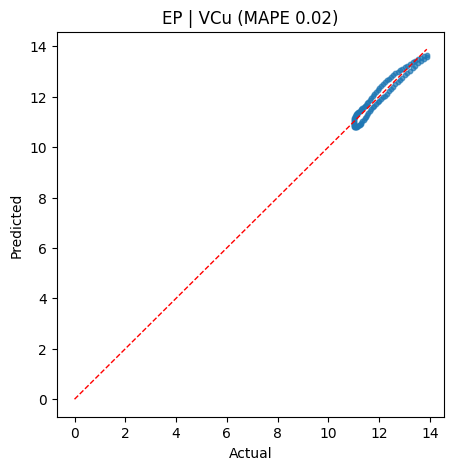

[EP] Left-out: VCu | Test MAPE: 0.0178
[EP] VHf | Epoch 10/100 Loss: 75.0270
[EP] VHf | Epoch 20/100 Loss: 35.8013
[EP] VHf | Epoch 30/100 Loss: 9.7350
[EP] VHf | Epoch 40/100 Loss: 2.7085
[EP] VHf | Epoch 50/100 Loss: 2.0566
[EP] VHf | Epoch 60/100 Loss: 1.9177
[EP] VHf | Epoch 70/100 Loss: 1.7804
[EP] VHf | Epoch 80/100 Loss: 1.6159
[EP] VHf | Epoch 90/100 Loss: 1.5671
[EP] VHf | Epoch 100/100 Loss: 1.5528


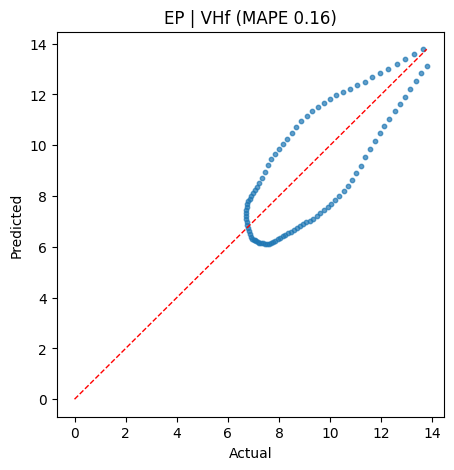

[EP] Left-out: VHf | Test MAPE: 0.1569
[EP] VMg | Epoch 10/100 Loss: 79.2491
[EP] VMg | Epoch 20/100 Loss: 41.9850
[EP] VMg | Epoch 30/100 Loss: 12.5455
[EP] VMg | Epoch 40/100 Loss: 3.2275
[EP] VMg | Epoch 50/100 Loss: 1.9767
[EP] VMg | Epoch 60/100 Loss: 1.8335
[EP] VMg | Epoch 70/100 Loss: 1.7093
[EP] VMg | Epoch 80/100 Loss: 1.6739
[EP] VMg | Epoch 90/100 Loss: 1.5911
[EP] VMg | Epoch 100/100 Loss: 1.5983


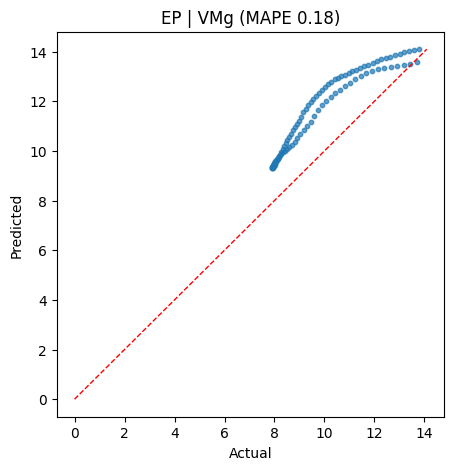

[EP] Left-out: VMg | Test MAPE: 0.1755
[EP] VNi | Epoch 10/100 Loss: 72.6447
[EP] VNi | Epoch 20/100 Loss: 37.1621
[EP] VNi | Epoch 30/100 Loss: 11.8194
[EP] VNi | Epoch 40/100 Loss: 3.3735
[EP] VNi | Epoch 50/100 Loss: 2.1912
[EP] VNi | Epoch 60/100 Loss: 1.8996
[EP] VNi | Epoch 70/100 Loss: 1.9145
[EP] VNi | Epoch 80/100 Loss: 1.7970
[EP] VNi | Epoch 90/100 Loss: 1.7245
[EP] VNi | Epoch 100/100 Loss: 1.6477


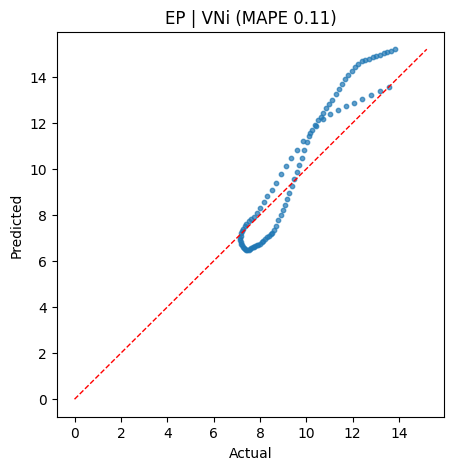

[EP] Left-out: VNi | Test MAPE: 0.1069
[EP] VSi | Epoch 10/100 Loss: 75.6769
[EP] VSi | Epoch 20/100 Loss: 40.2925
[EP] VSi | Epoch 30/100 Loss: 13.0129
[EP] VSi | Epoch 40/100 Loss: 3.3001
[EP] VSi | Epoch 50/100 Loss: 2.0679
[EP] VSi | Epoch 60/100 Loss: 1.8949
[EP] VSi | Epoch 70/100 Loss: 1.7913
[EP] VSi | Epoch 80/100 Loss: 1.7038
[EP] VSi | Epoch 90/100 Loss: 1.6553
[EP] VSi | Epoch 100/100 Loss: 1.5761


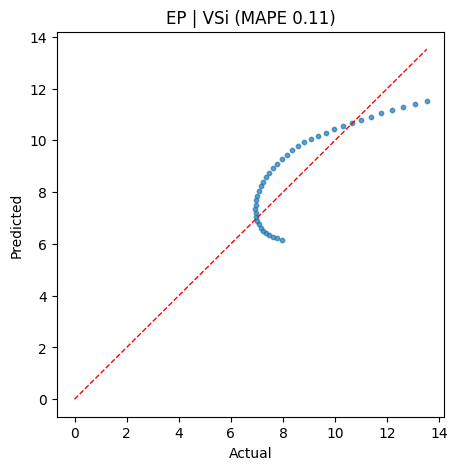

[EP] Left-out: VSi | Test MAPE: 0.1079
[EP] VSn | Epoch 10/100 Loss: 76.6006
[EP] VSn | Epoch 20/100 Loss: 35.3909
[EP] VSn | Epoch 30/100 Loss: 8.8804
[EP] VSn | Epoch 40/100 Loss: 2.4797
[EP] VSn | Epoch 50/100 Loss: 1.8929
[EP] VSn | Epoch 60/100 Loss: 1.7502
[EP] VSn | Epoch 70/100 Loss: 1.6609
[EP] VSn | Epoch 80/100 Loss: 1.5550
[EP] VSn | Epoch 90/100 Loss: 1.5330
[EP] VSn | Epoch 100/100 Loss: 1.4385


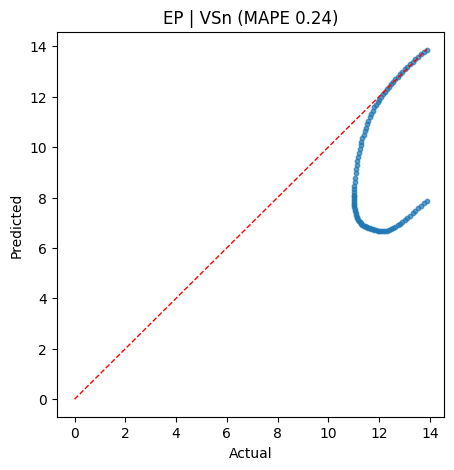

[EP] Left-out: VSn | Test MAPE: 0.2392
[EP] VTi | Epoch 10/100 Loss: 62.1678
[EP] VTi | Epoch 20/100 Loss: 26.1152
[EP] VTi | Epoch 30/100 Loss: 6.5836
[EP] VTi | Epoch 40/100 Loss: 2.4752
[EP] VTi | Epoch 50/100 Loss: 1.9367
[EP] VTi | Epoch 60/100 Loss: 1.7197
[EP] VTi | Epoch 70/100 Loss: 1.6171
[EP] VTi | Epoch 80/100 Loss: 1.5957
[EP] VTi | Epoch 90/100 Loss: 1.5392
[EP] VTi | Epoch 100/100 Loss: 1.4371


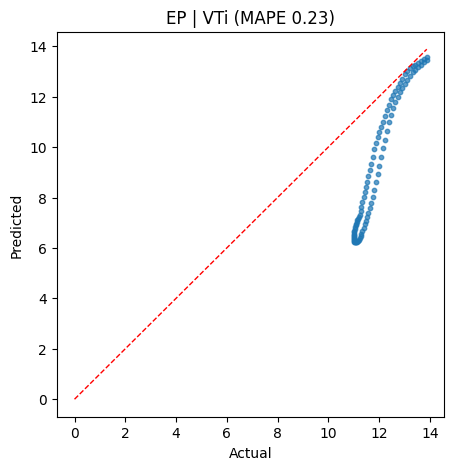

[EP] Left-out: VTi | Test MAPE: 0.2290
[EP] VY | Epoch 10/100 Loss: 68.9344
[EP] VY | Epoch 20/100 Loss: 34.9435
[EP] VY | Epoch 30/100 Loss: 11.1908
[EP] VY | Epoch 40/100 Loss: 3.1601
[EP] VY | Epoch 50/100 Loss: 2.1033
[EP] VY | Epoch 60/100 Loss: 2.0002
[EP] VY | Epoch 70/100 Loss: 1.8156
[EP] VY | Epoch 80/100 Loss: 1.7158
[EP] VY | Epoch 90/100 Loss: 1.7848
[EP] VY | Epoch 100/100 Loss: 1.6090


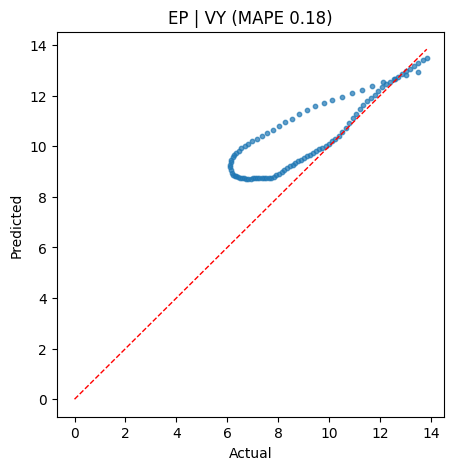

[EP] Left-out: VY | Test MAPE: 0.1826
[EP] WMg | Epoch 10/100 Loss: 82.7790
[EP] WMg | Epoch 20/100 Loss: 46.9457
[EP] WMg | Epoch 30/100 Loss: 16.2678
[EP] WMg | Epoch 40/100 Loss: 3.8568
[EP] WMg | Epoch 50/100 Loss: 2.1719
[EP] WMg | Epoch 60/100 Loss: 1.9595
[EP] WMg | Epoch 70/100 Loss: 1.7804
[EP] WMg | Epoch 80/100 Loss: 1.7345
[EP] WMg | Epoch 90/100 Loss: 1.7464
[EP] WMg | Epoch 100/100 Loss: 1.6108


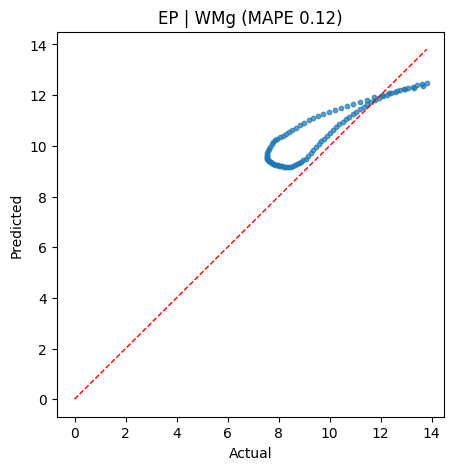

[EP] Left-out: WMg | Test MAPE: 0.1238
[EP] WNb | Epoch 10/100 Loss: 69.4073
[EP] WNb | Epoch 20/100 Loss: 31.7935
[EP] WNb | Epoch 30/100 Loss: 8.6687
[EP] WNb | Epoch 40/100 Loss: 2.7574
[EP] WNb | Epoch 50/100 Loss: 2.0098
[EP] WNb | Epoch 60/100 Loss: 1.7329
[EP] WNb | Epoch 70/100 Loss: 1.6776
[EP] WNb | Epoch 80/100 Loss: 1.6147
[EP] WNb | Epoch 90/100 Loss: 1.6414
[EP] WNb | Epoch 100/100 Loss: 1.6082


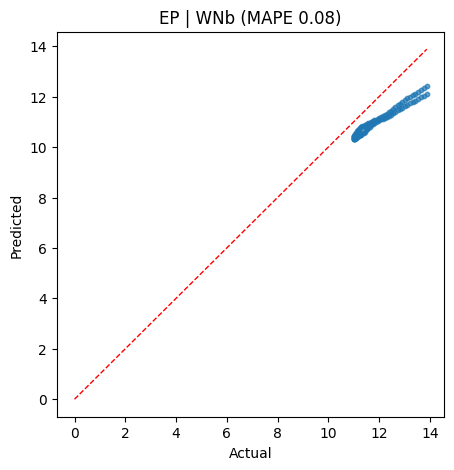

[EP] Left-out: WNb | Test MAPE: 0.0750
EP mean MAPE: 30844.5403
test
[Comp] AgAl | Epoch 10/100 Loss: 73.1404
[Comp] AgAl | Epoch 20/100 Loss: 35.5402
[Comp] AgAl | Epoch 30/100 Loss: 10.1829
[Comp] AgAl | Epoch 40/100 Loss: 3.0338
[Comp] AgAl | Epoch 50/100 Loss: 2.1429
[Comp] AgAl | Epoch 60/100 Loss: 1.9861
[Comp] AgAl | Epoch 70/100 Loss: 1.8520
[Comp] AgAl | Epoch 80/100 Loss: 1.7649
[Comp] AgAl | Epoch 90/100 Loss: 1.6417
[Comp] AgAl | Epoch 100/100 Loss: 1.5182


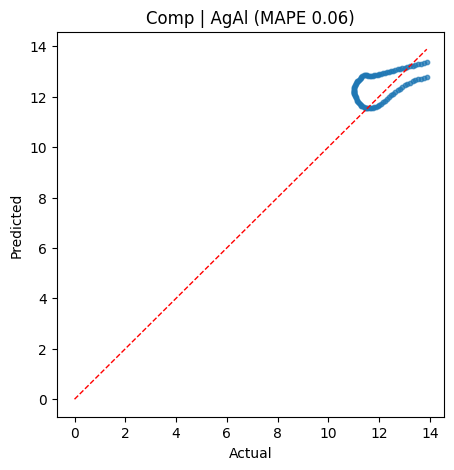

[Comp] Left-out: AgAl | Test MAPE: 0.0645
[Comp] AlMg | Epoch 10/100 Loss: 73.8534
[Comp] AlMg | Epoch 20/100 Loss: 38.9307
[Comp] AlMg | Epoch 30/100 Loss: 13.9429
[Comp] AlMg | Epoch 40/100 Loss: 4.1807
[Comp] AlMg | Epoch 50/100 Loss: 2.4421
[Comp] AlMg | Epoch 60/100 Loss: 2.0579
[Comp] AlMg | Epoch 70/100 Loss: 1.9737
[Comp] AlMg | Epoch 80/100 Loss: 1.9296
[Comp] AlMg | Epoch 90/100 Loss: 1.8295
[Comp] AlMg | Epoch 100/100 Loss: 1.7683


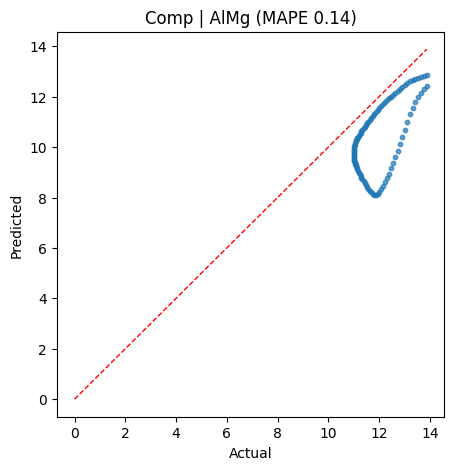

[Comp] Left-out: AlMg | Test MAPE: 0.1352
[Comp] AlNi | Epoch 10/100 Loss: 85.4975
[Comp] AlNi | Epoch 20/100 Loss: 48.8696
[Comp] AlNi | Epoch 30/100 Loss: 17.3816
[Comp] AlNi | Epoch 40/100 Loss: 4.2302
[Comp] AlNi | Epoch 50/100 Loss: 2.2618
[Comp] AlNi | Epoch 60/100 Loss: 1.9907
[Comp] AlNi | Epoch 70/100 Loss: 1.8895
[Comp] AlNi | Epoch 80/100 Loss: 1.7277
[Comp] AlNi | Epoch 90/100 Loss: 1.7334
[Comp] AlNi | Epoch 100/100 Loss: 1.6866


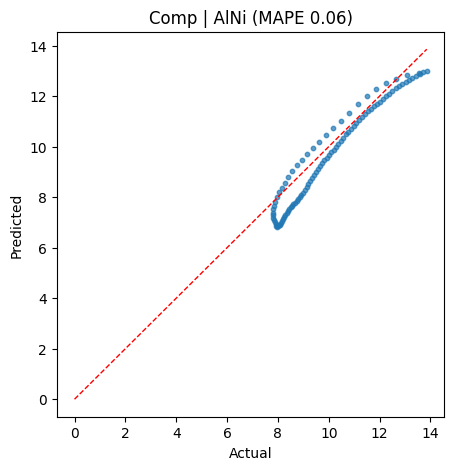

[Comp] Left-out: AlNi | Test MAPE: 0.0575
[Comp] AlTi | Epoch 10/100 Loss: 67.5706
[Comp] AlTi | Epoch 20/100 Loss: 30.8896
[Comp] AlTi | Epoch 30/100 Loss: 8.8148
[Comp] AlTi | Epoch 40/100 Loss: 2.7182
[Comp] AlTi | Epoch 50/100 Loss: 2.0668
[Comp] AlTi | Epoch 60/100 Loss: 1.8784
[Comp] AlTi | Epoch 70/100 Loss: 1.8037
[Comp] AlTi | Epoch 80/100 Loss: 1.6864
[Comp] AlTi | Epoch 90/100 Loss: 1.5916
[Comp] AlTi | Epoch 100/100 Loss: 1.5549


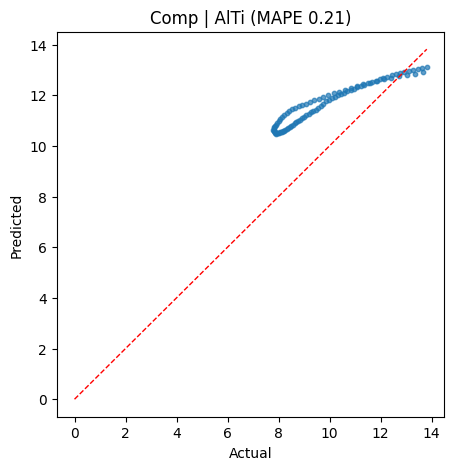

[Comp] Left-out: AlTi | Test MAPE: 0.2067
[Comp] AlV | Epoch 10/100 Loss: 72.5496
[Comp] AlV | Epoch 20/100 Loss: 36.6222
[Comp] AlV | Epoch 30/100 Loss: 11.4739
[Comp] AlV | Epoch 40/100 Loss: 3.3247
[Comp] AlV | Epoch 50/100 Loss: 2.2427
[Comp] AlV | Epoch 60/100 Loss: 1.9851
[Comp] AlV | Epoch 70/100 Loss: 1.8607
[Comp] AlV | Epoch 80/100 Loss: 1.7211
[Comp] AlV | Epoch 90/100 Loss: 1.6209
[Comp] AlV | Epoch 100/100 Loss: 1.5857


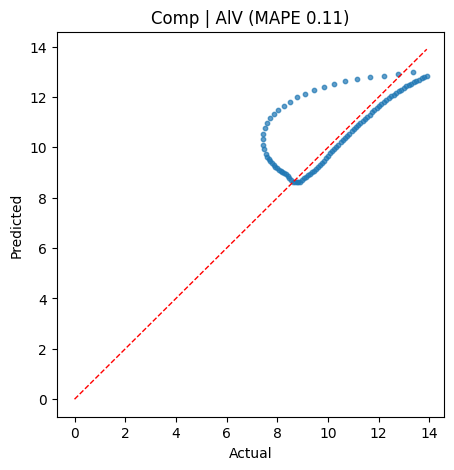

[Comp] Left-out: AlV | Test MAPE: 0.1113
[Comp] AuAl | Epoch 10/100 Loss: 68.1888
[Comp] AuAl | Epoch 20/100 Loss: 28.4624
[Comp] AuAl | Epoch 30/100 Loss: 7.2243
[Comp] AuAl | Epoch 40/100 Loss: 2.3375
[Comp] AuAl | Epoch 50/100 Loss: 1.8337
[Comp] AuAl | Epoch 60/100 Loss: 1.7014
[Comp] AuAl | Epoch 70/100 Loss: 1.6923
[Comp] AuAl | Epoch 80/100 Loss: 1.5857
[Comp] AuAl | Epoch 90/100 Loss: 1.4905
[Comp] AuAl | Epoch 100/100 Loss: 1.5779


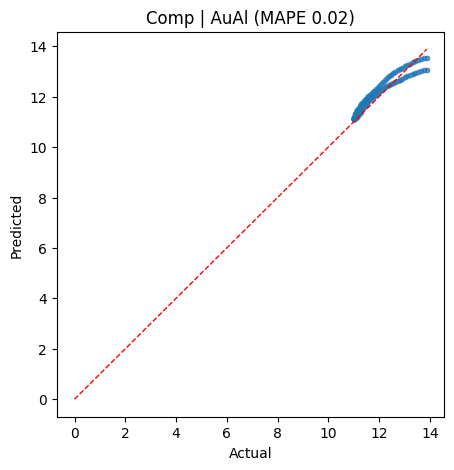

[Comp] Left-out: AuAl | Test MAPE: 0.0213
[Comp] AuCr | Epoch 10/100 Loss: 86.1974
[Comp] AuCr | Epoch 20/100 Loss: 54.3103
[Comp] AuCr | Epoch 30/100 Loss: 24.1127
[Comp] AuCr | Epoch 40/100 Loss: 7.3536
[Comp] AuCr | Epoch 50/100 Loss: 2.9566
[Comp] AuCr | Epoch 60/100 Loss: 2.3302
[Comp] AuCr | Epoch 70/100 Loss: 2.1029
[Comp] AuCr | Epoch 80/100 Loss: 2.0947
[Comp] AuCr | Epoch 90/100 Loss: 1.9388
[Comp] AuCr | Epoch 100/100 Loss: 1.8583


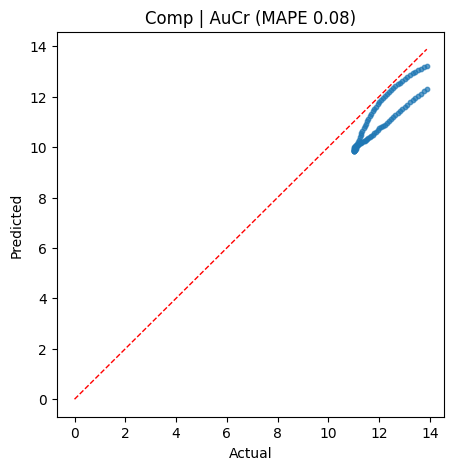

[Comp] Left-out: AuCr | Test MAPE: 0.0777
[Comp] AuHf | Epoch 10/100 Loss: 71.0721
[Comp] AuHf | Epoch 20/100 Loss: 31.1168
[Comp] AuHf | Epoch 30/100 Loss: 8.1587
[Comp] AuHf | Epoch 40/100 Loss: 2.6259
[Comp] AuHf | Epoch 50/100 Loss: 1.9952
[Comp] AuHf | Epoch 60/100 Loss: 1.7932
[Comp] AuHf | Epoch 70/100 Loss: 1.7668
[Comp] AuHf | Epoch 80/100 Loss: 1.7059
[Comp] AuHf | Epoch 90/100 Loss: 1.5729
[Comp] AuHf | Epoch 100/100 Loss: 1.5806


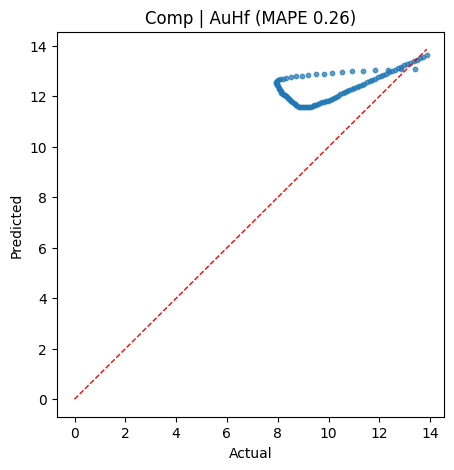

[Comp] Left-out: AuHf | Test MAPE: 0.2556
[Comp] AuMg | Epoch 10/100 Loss: 69.3026
[Comp] AuMg | Epoch 20/100 Loss: 32.8324
[Comp] AuMg | Epoch 30/100 Loss: 9.6774
[Comp] AuMg | Epoch 40/100 Loss: 2.9341
[Comp] AuMg | Epoch 50/100 Loss: 2.0984
[Comp] AuMg | Epoch 60/100 Loss: 1.8487
[Comp] AuMg | Epoch 70/100 Loss: 1.7168
[Comp] AuMg | Epoch 80/100 Loss: 1.7211
[Comp] AuMg | Epoch 90/100 Loss: 1.6038
[Comp] AuMg | Epoch 100/100 Loss: 1.5844


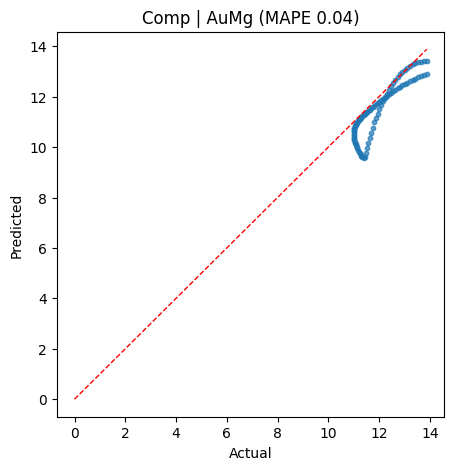

[Comp] Left-out: AuMg | Test MAPE: 0.0446
[Comp] CoMg | Epoch 10/100 Loss: 77.1855
[Comp] CoMg | Epoch 20/100 Loss: 39.0387
[Comp] CoMg | Epoch 30/100 Loss: 11.9351
[Comp] CoMg | Epoch 40/100 Loss: 3.3674
[Comp] CoMg | Epoch 50/100 Loss: 2.2360
[Comp] CoMg | Epoch 60/100 Loss: 1.9220
[Comp] CoMg | Epoch 70/100 Loss: 1.8204
[Comp] CoMg | Epoch 80/100 Loss: 1.7302
[Comp] CoMg | Epoch 90/100 Loss: 1.7155
[Comp] CoMg | Epoch 100/100 Loss: 1.5439


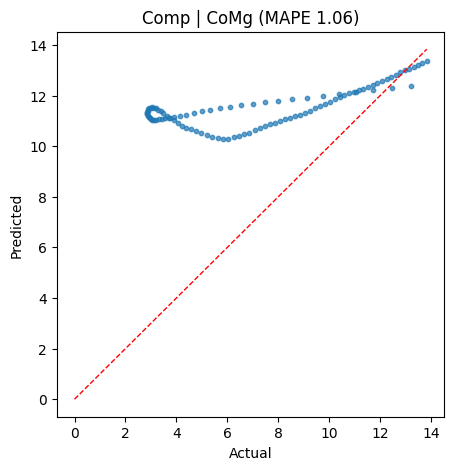

[Comp] Left-out: CoMg | Test MAPE: 1.0606
[Comp] CrAl | Epoch 10/100 Loss: 67.8352
[Comp] CrAl | Epoch 20/100 Loss: 28.7649
[Comp] CrAl | Epoch 30/100 Loss: 7.2519
[Comp] CrAl | Epoch 40/100 Loss: 2.5534
[Comp] CrAl | Epoch 50/100 Loss: 1.7984
[Comp] CrAl | Epoch 60/100 Loss: 1.8560
[Comp] CrAl | Epoch 70/100 Loss: 1.6026
[Comp] CrAl | Epoch 80/100 Loss: 1.5664
[Comp] CrAl | Epoch 90/100 Loss: 1.4711
[Comp] CrAl | Epoch 100/100 Loss: 1.5433


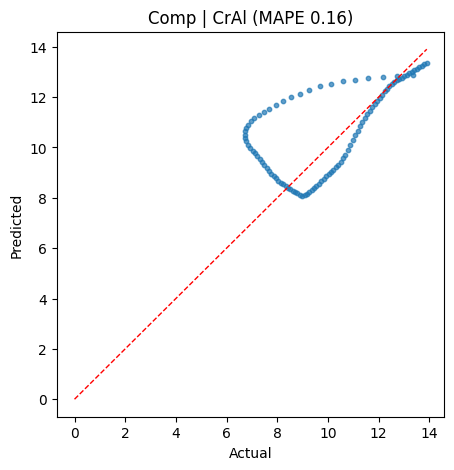

[Comp] Left-out: CrAl | Test MAPE: 0.1625
[Comp] CrCo | Epoch 10/100 Loss: 68.4690
[Comp] CrCo | Epoch 20/100 Loss: 31.9369
[Comp] CrCo | Epoch 30/100 Loss: 9.1603
[Comp] CrCo | Epoch 40/100 Loss: 2.7136
[Comp] CrCo | Epoch 50/100 Loss: 1.9465
[Comp] CrCo | Epoch 60/100 Loss: 1.8363
[Comp] CrCo | Epoch 70/100 Loss: 1.6832
[Comp] CrCo | Epoch 80/100 Loss: 1.6403
[Comp] CrCo | Epoch 90/100 Loss: 1.4662
[Comp] CrCo | Epoch 100/100 Loss: 1.5400


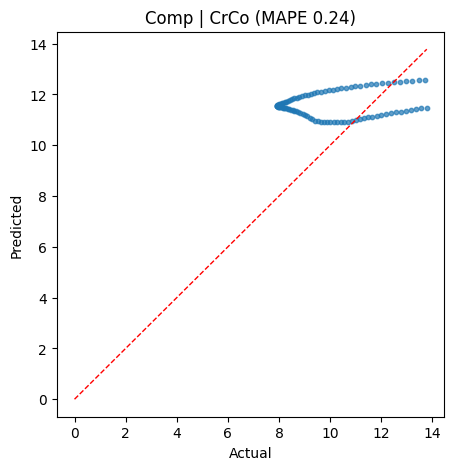

[Comp] Left-out: CrCo | Test MAPE: 0.2365
[Comp] CrMg | Epoch 10/100 Loss: 79.4868
[Comp] CrMg | Epoch 20/100 Loss: 41.8957
[Comp] CrMg | Epoch 30/100 Loss: 13.5278
[Comp] CrMg | Epoch 40/100 Loss: 3.6394
[Comp] CrMg | Epoch 50/100 Loss: 2.2300
[Comp] CrMg | Epoch 60/100 Loss: 2.0182
[Comp] CrMg | Epoch 70/100 Loss: 1.8373
[Comp] CrMg | Epoch 80/100 Loss: 1.7677
[Comp] CrMg | Epoch 90/100 Loss: 1.7454
[Comp] CrMg | Epoch 100/100 Loss: 1.6485


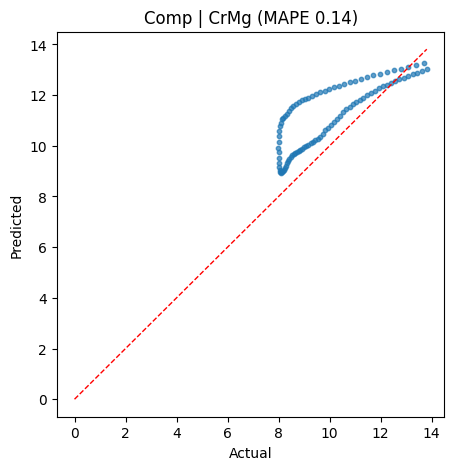

[Comp] Left-out: CrMg | Test MAPE: 0.1392
[Comp] CrNi | Epoch 10/100 Loss: 63.0964
[Comp] CrNi | Epoch 20/100 Loss: 25.4120
[Comp] CrNi | Epoch 30/100 Loss: 6.3239
[Comp] CrNi | Epoch 40/100 Loss: 2.2960
[Comp] CrNi | Epoch 50/100 Loss: 1.8560
[Comp] CrNi | Epoch 60/100 Loss: 1.7855
[Comp] CrNi | Epoch 70/100 Loss: 1.6740
[Comp] CrNi | Epoch 80/100 Loss: 1.5881
[Comp] CrNi | Epoch 90/100 Loss: 1.5681
[Comp] CrNi | Epoch 100/100 Loss: 1.4824


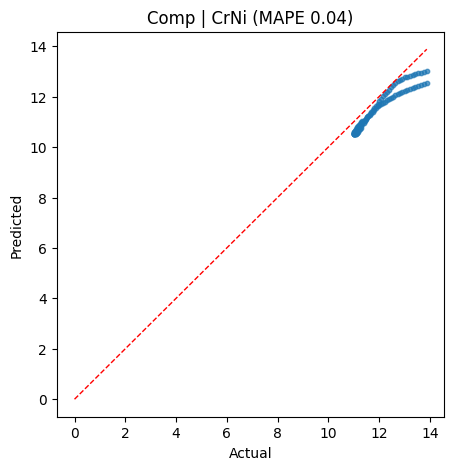

[Comp] Left-out: CrNi | Test MAPE: 0.0378
[Comp] CrV | Epoch 10/100 Loss: 69.7125
[Comp] CrV | Epoch 20/100 Loss: 31.5566
[Comp] CrV | Epoch 30/100 Loss: 8.2702
[Comp] CrV | Epoch 40/100 Loss: 2.5214
[Comp] CrV | Epoch 50/100 Loss: 1.9293
[Comp] CrV | Epoch 60/100 Loss: 1.7598
[Comp] CrV | Epoch 70/100 Loss: 1.6581
[Comp] CrV | Epoch 80/100 Loss: 1.5605
[Comp] CrV | Epoch 90/100 Loss: 1.5055
[Comp] CrV | Epoch 100/100 Loss: 1.3921


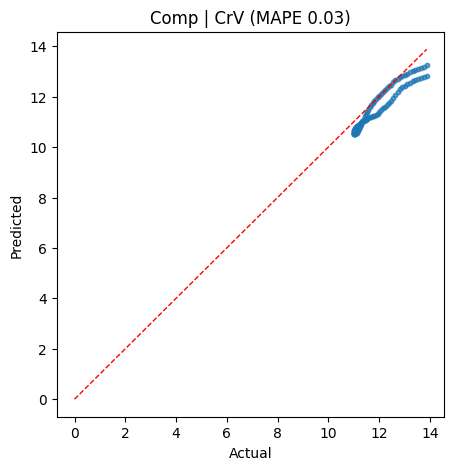

[Comp] Left-out: CrV | Test MAPE: 0.0326
[Comp] CuAl | Epoch 10/100 Loss: 70.6583
[Comp] CuAl | Epoch 20/100 Loss: 33.0557
[Comp] CuAl | Epoch 30/100 Loss: 9.2264
[Comp] CuAl | Epoch 40/100 Loss: 2.9178
[Comp] CuAl | Epoch 50/100 Loss: 2.1281
[Comp] CuAl | Epoch 60/100 Loss: 1.8164
[Comp] CuAl | Epoch 70/100 Loss: 1.7464
[Comp] CuAl | Epoch 80/100 Loss: 1.6388
[Comp] CuAl | Epoch 90/100 Loss: 1.6086
[Comp] CuAl | Epoch 100/100 Loss: 1.4991


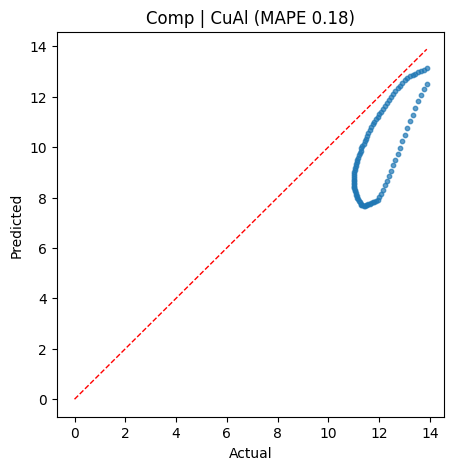

[Comp] Left-out: CuAl | Test MAPE: 0.1775
[Comp] CuMg | Epoch 10/100 Loss: 65.2359
[Comp] CuMg | Epoch 20/100 Loss: 28.7271
[Comp] CuMg | Epoch 30/100 Loss: 7.6359
[Comp] CuMg | Epoch 40/100 Loss: 2.5846
[Comp] CuMg | Epoch 50/100 Loss: 2.0187
[Comp] CuMg | Epoch 60/100 Loss: 1.8143
[Comp] CuMg | Epoch 70/100 Loss: 1.7648
[Comp] CuMg | Epoch 80/100 Loss: 1.6566
[Comp] CuMg | Epoch 90/100 Loss: 1.5763
[Comp] CuMg | Epoch 100/100 Loss: 1.5519


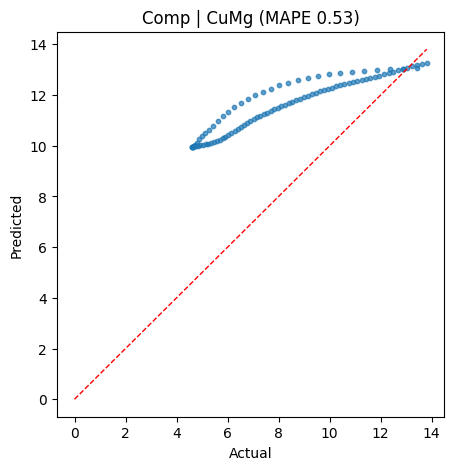

[Comp] Left-out: CuMg | Test MAPE: 0.5285
[Comp] CuNi | Epoch 10/100 Loss: 64.9528
[Comp] CuNi | Epoch 20/100 Loss: 30.3126
[Comp] CuNi | Epoch 30/100 Loss: 8.8358
[Comp] CuNi | Epoch 40/100 Loss: 2.9515
[Comp] CuNi | Epoch 50/100 Loss: 2.0970
[Comp] CuNi | Epoch 60/100 Loss: 1.8370
[Comp] CuNi | Epoch 70/100 Loss: 1.8613
[Comp] CuNi | Epoch 80/100 Loss: 1.6948
[Comp] CuNi | Epoch 90/100 Loss: 1.6580
[Comp] CuNi | Epoch 100/100 Loss: 1.5357


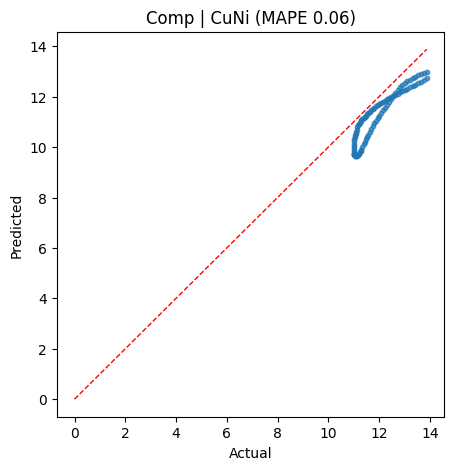

[Comp] Left-out: CuNi | Test MAPE: 0.0642
[Comp] CuSi | Epoch 10/100 Loss: 72.6332
[Comp] CuSi | Epoch 20/100 Loss: 34.5873
[Comp] CuSi | Epoch 30/100 Loss: 10.0640
[Comp] CuSi | Epoch 40/100 Loss: 2.9969
[Comp] CuSi | Epoch 50/100 Loss: 1.9581
[Comp] CuSi | Epoch 60/100 Loss: 1.7820
[Comp] CuSi | Epoch 70/100 Loss: 1.7835
[Comp] CuSi | Epoch 80/100 Loss: 1.6452
[Comp] CuSi | Epoch 90/100 Loss: 1.5019
[Comp] CuSi | Epoch 100/100 Loss: 1.5640


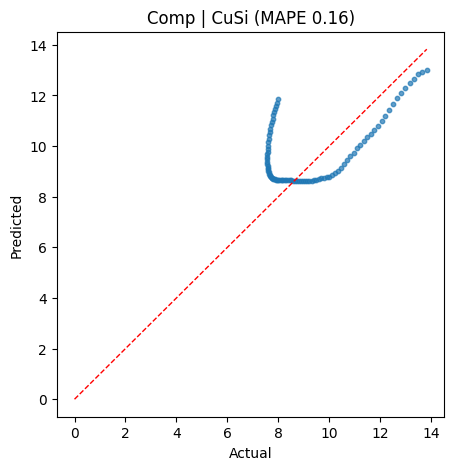

[Comp] Left-out: CuSi | Test MAPE: 0.1557
[Comp] CuZr | Epoch 10/100 Loss: 72.6129
[Comp] CuZr | Epoch 20/100 Loss: 35.3036
[Comp] CuZr | Epoch 30/100 Loss: 9.8480
[Comp] CuZr | Epoch 40/100 Loss: 2.7704
[Comp] CuZr | Epoch 50/100 Loss: 1.9592
[Comp] CuZr | Epoch 60/100 Loss: 1.8077
[Comp] CuZr | Epoch 70/100 Loss: 1.6808
[Comp] CuZr | Epoch 80/100 Loss: 1.6649
[Comp] CuZr | Epoch 90/100 Loss: 1.5206
[Comp] CuZr | Epoch 100/100 Loss: 1.4579


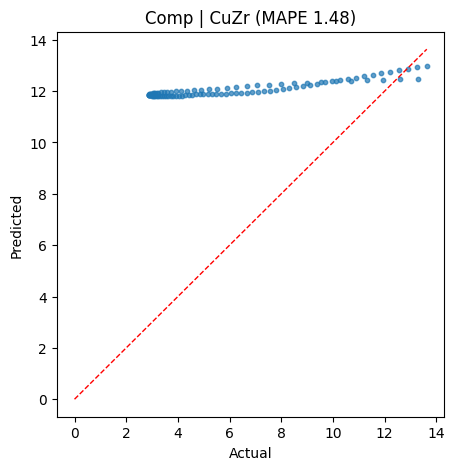

[Comp] Left-out: CuZr | Test MAPE: 1.4769
[Comp] FeAl | Epoch 10/100 Loss: 74.5712
[Comp] FeAl | Epoch 20/100 Loss: 35.4684
[Comp] FeAl | Epoch 30/100 Loss: 9.7566
[Comp] FeAl | Epoch 40/100 Loss: 2.7819
[Comp] FeAl | Epoch 50/100 Loss: 2.0378
[Comp] FeAl | Epoch 60/100 Loss: 1.8284
[Comp] FeAl | Epoch 70/100 Loss: 1.7338
[Comp] FeAl | Epoch 80/100 Loss: 1.6771
[Comp] FeAl | Epoch 90/100 Loss: 1.6190
[Comp] FeAl | Epoch 100/100 Loss: 1.4800


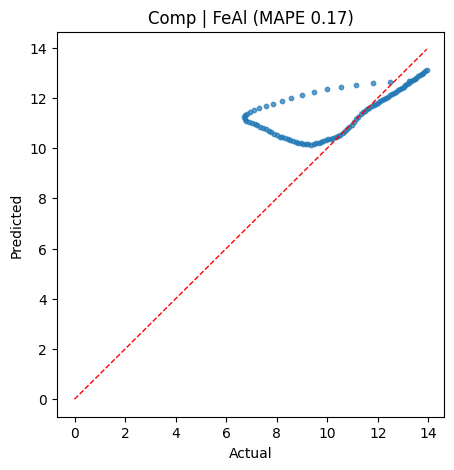

[Comp] Left-out: FeAl | Test MAPE: 0.1737
[Comp] GeMg | Epoch 10/100 Loss: 76.8408
[Comp] GeMg | Epoch 20/100 Loss: 38.7073
[Comp] GeMg | Epoch 30/100 Loss: 12.4501
[Comp] GeMg | Epoch 40/100 Loss: 3.5777
[Comp] GeMg | Epoch 50/100 Loss: 2.2073
[Comp] GeMg | Epoch 60/100 Loss: 1.9016
[Comp] GeMg | Epoch 70/100 Loss: 1.9108
[Comp] GeMg | Epoch 80/100 Loss: 1.7180
[Comp] GeMg | Epoch 90/100 Loss: 1.7706
[Comp] GeMg | Epoch 100/100 Loss: 1.7141


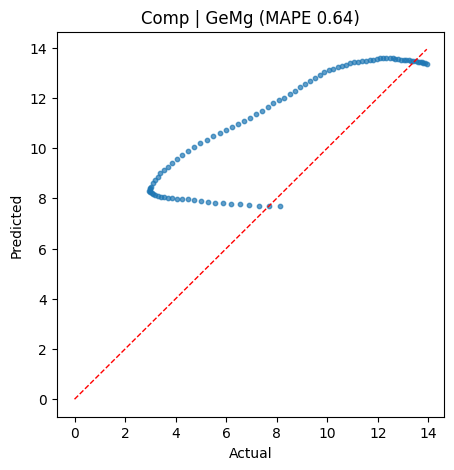

[Comp] Left-out: GeMg | Test MAPE: 0.6431
[Comp] HfAl | Epoch 10/100 Loss: 75.5717
[Comp] HfAl | Epoch 20/100 Loss: 40.7332
[Comp] HfAl | Epoch 30/100 Loss: 12.6635
[Comp] HfAl | Epoch 40/100 Loss: 3.3507
[Comp] HfAl | Epoch 50/100 Loss: 2.1424
[Comp] HfAl | Epoch 60/100 Loss: 1.9782
[Comp] HfAl | Epoch 70/100 Loss: 1.8790
[Comp] HfAl | Epoch 80/100 Loss: 1.7063
[Comp] HfAl | Epoch 90/100 Loss: 1.6654
[Comp] HfAl | Epoch 100/100 Loss: 1.5986


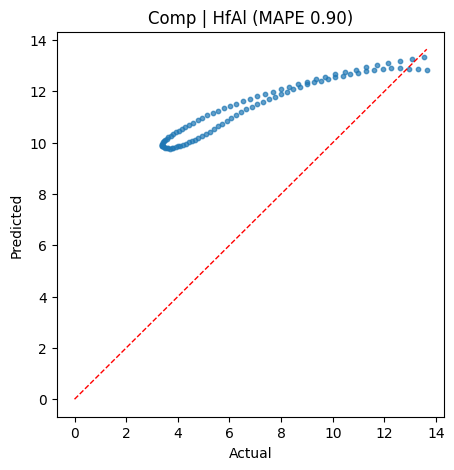

[Comp] Left-out: HfAl | Test MAPE: 0.9024
[Comp] HfFe | Epoch 10/100 Loss: 66.6531
[Comp] HfFe | Epoch 20/100 Loss: 31.8737
[Comp] HfFe | Epoch 30/100 Loss: 9.3107
[Comp] HfFe | Epoch 40/100 Loss: 2.8956
[Comp] HfFe | Epoch 50/100 Loss: 1.9630
[Comp] HfFe | Epoch 60/100 Loss: 1.8635
[Comp] HfFe | Epoch 70/100 Loss: 1.7253
[Comp] HfFe | Epoch 80/100 Loss: 1.6756
[Comp] HfFe | Epoch 90/100 Loss: 1.5866
[Comp] HfFe | Epoch 100/100 Loss: 1.5414


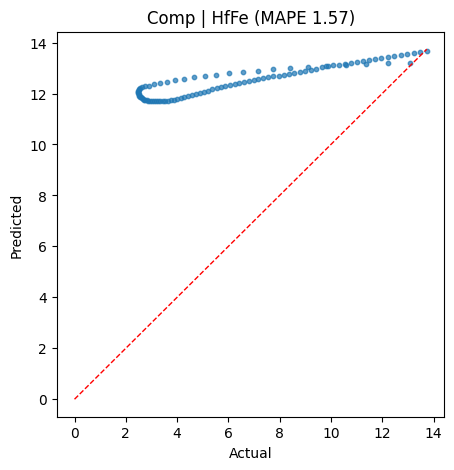

[Comp] Left-out: HfFe | Test MAPE: 1.5702
[Comp] HfMg | Epoch 10/100 Loss: 78.3625
[Comp] HfMg | Epoch 20/100 Loss: 41.8378
[Comp] HfMg | Epoch 30/100 Loss: 13.8305
[Comp] HfMg | Epoch 40/100 Loss: 3.8596
[Comp] HfMg | Epoch 50/100 Loss: 2.1508
[Comp] HfMg | Epoch 60/100 Loss: 1.8690
[Comp] HfMg | Epoch 70/100 Loss: 1.8004
[Comp] HfMg | Epoch 80/100 Loss: 1.7763
[Comp] HfMg | Epoch 90/100 Loss: 1.6530
[Comp] HfMg | Epoch 100/100 Loss: 1.6010


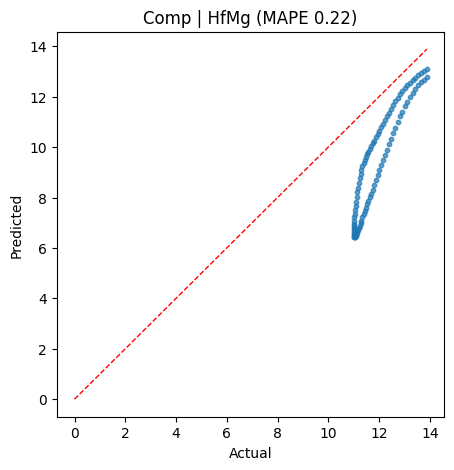

[Comp] Left-out: HfMg | Test MAPE: 0.2175
[Comp] HfTi | Epoch 10/100 Loss: 78.8257
[Comp] HfTi | Epoch 20/100 Loss: 40.0568
[Comp] HfTi | Epoch 30/100 Loss: 11.9466
[Comp] HfTi | Epoch 40/100 Loss: 3.2232
[Comp] HfTi | Epoch 50/100 Loss: 1.9847
[Comp] HfTi | Epoch 60/100 Loss: 1.8643
[Comp] HfTi | Epoch 70/100 Loss: 1.7266
[Comp] HfTi | Epoch 80/100 Loss: 1.6694
[Comp] HfTi | Epoch 90/100 Loss: 1.6225
[Comp] HfTi | Epoch 100/100 Loss: 1.4638


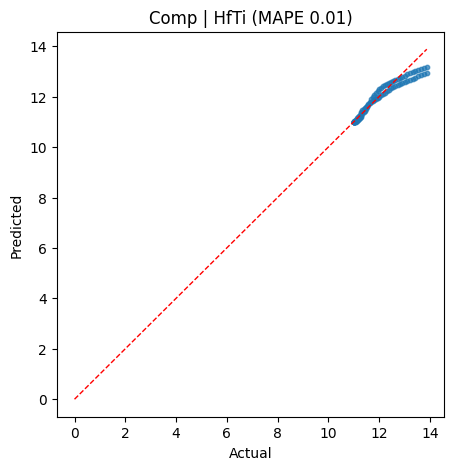

[Comp] Left-out: HfTi | Test MAPE: 0.0138
[Comp] HfY | Epoch 10/100 Loss: 82.0922
[Comp] HfY | Epoch 20/100 Loss: 46.3716
[Comp] HfY | Epoch 30/100 Loss: 16.0568
[Comp] HfY | Epoch 40/100 Loss: 4.2413
[Comp] HfY | Epoch 50/100 Loss: 2.3074
[Comp] HfY | Epoch 60/100 Loss: 2.0013
[Comp] HfY | Epoch 70/100 Loss: 1.8458
[Comp] HfY | Epoch 80/100 Loss: 1.8915
[Comp] HfY | Epoch 90/100 Loss: 1.7764
[Comp] HfY | Epoch 100/100 Loss: 1.6307


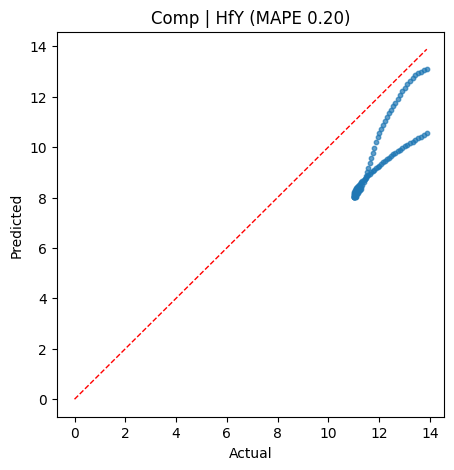

[Comp] Left-out: HfY | Test MAPE: 0.2018
[Comp] HfZr | Epoch 10/100 Loss: 72.8950
[Comp] HfZr | Epoch 20/100 Loss: 34.4104
[Comp] HfZr | Epoch 30/100 Loss: 9.7027
[Comp] HfZr | Epoch 40/100 Loss: 3.0761
[Comp] HfZr | Epoch 50/100 Loss: 2.1561
[Comp] HfZr | Epoch 60/100 Loss: 1.9886
[Comp] HfZr | Epoch 70/100 Loss: 1.8214
[Comp] HfZr | Epoch 80/100 Loss: 1.7942
[Comp] HfZr | Epoch 90/100 Loss: 1.7453
[Comp] HfZr | Epoch 100/100 Loss: 1.6463


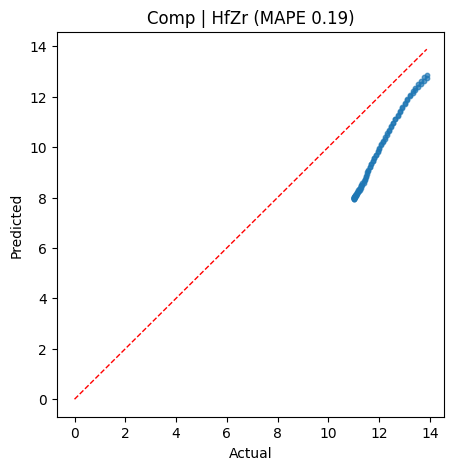

[Comp] Left-out: HfZr | Test MAPE: 0.1892
[Comp] MnAg | Epoch 10/100 Loss: 75.4796
[Comp] MnAg | Epoch 20/100 Loss: 38.1913
[Comp] MnAg | Epoch 30/100 Loss: 11.8285
[Comp] MnAg | Epoch 40/100 Loss: 3.1916
[Comp] MnAg | Epoch 50/100 Loss: 2.1747
[Comp] MnAg | Epoch 60/100 Loss: 1.9212
[Comp] MnAg | Epoch 70/100 Loss: 1.8874
[Comp] MnAg | Epoch 80/100 Loss: 1.7907
[Comp] MnAg | Epoch 90/100 Loss: 1.7248
[Comp] MnAg | Epoch 100/100 Loss: 1.6289


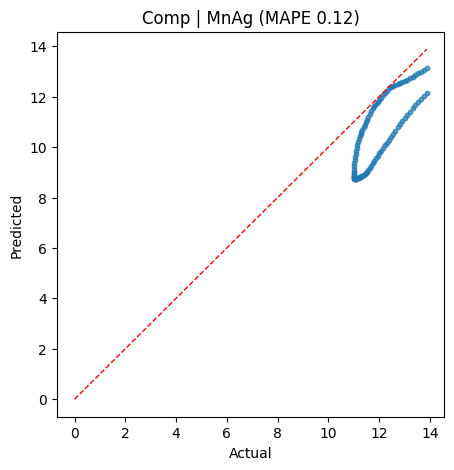

[Comp] Left-out: MnAg | Test MAPE: 0.1223
[Comp] MnAl | Epoch 10/100 Loss: 69.9073
[Comp] MnAl | Epoch 20/100 Loss: 32.2963
[Comp] MnAl | Epoch 30/100 Loss: 9.4375
[Comp] MnAl | Epoch 40/100 Loss: 2.9591
[Comp] MnAl | Epoch 50/100 Loss: 2.1818
[Comp] MnAl | Epoch 60/100 Loss: 1.9639
[Comp] MnAl | Epoch 70/100 Loss: 1.8940
[Comp] MnAl | Epoch 80/100 Loss: 1.7572
[Comp] MnAl | Epoch 90/100 Loss: 1.7814
[Comp] MnAl | Epoch 100/100 Loss: 1.6460


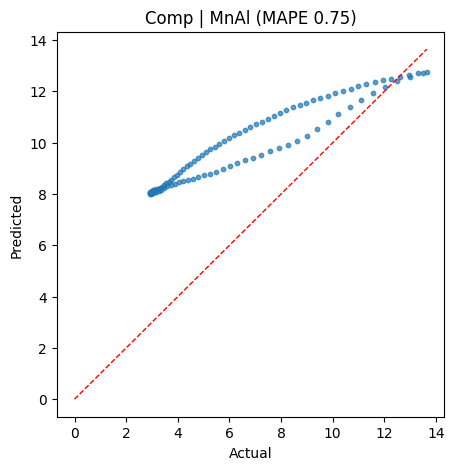

[Comp] Left-out: MnAl | Test MAPE: 0.7547
[Comp] MnMg | Epoch 10/100 Loss: 68.8751
[Comp] MnMg | Epoch 20/100 Loss: 31.5650
[Comp] MnMg | Epoch 30/100 Loss: 8.5230
[Comp] MnMg | Epoch 40/100 Loss: 2.5662
[Comp] MnMg | Epoch 50/100 Loss: 1.9816
[Comp] MnMg | Epoch 60/100 Loss: 1.8459
[Comp] MnMg | Epoch 70/100 Loss: 1.7895
[Comp] MnMg | Epoch 80/100 Loss: 1.6480
[Comp] MnMg | Epoch 90/100 Loss: 1.6075
[Comp] MnMg | Epoch 100/100 Loss: 1.5069


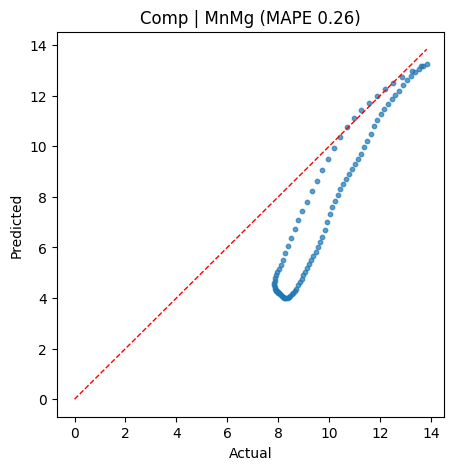

[Comp] Left-out: MnMg | Test MAPE: 0.2596
[Comp] MoCu | Epoch 10/100 Loss: 76.3335
[Comp] MoCu | Epoch 20/100 Loss: 38.4507
[Comp] MoCu | Epoch 30/100 Loss: 11.3833
[Comp] MoCu | Epoch 40/100 Loss: 2.9719
[Comp] MoCu | Epoch 50/100 Loss: 1.9952
[Comp] MoCu | Epoch 60/100 Loss: 1.8829
[Comp] MoCu | Epoch 70/100 Loss: 1.7387
[Comp] MoCu | Epoch 80/100 Loss: 1.6399
[Comp] MoCu | Epoch 90/100 Loss: 1.6466
[Comp] MoCu | Epoch 100/100 Loss: 1.5092


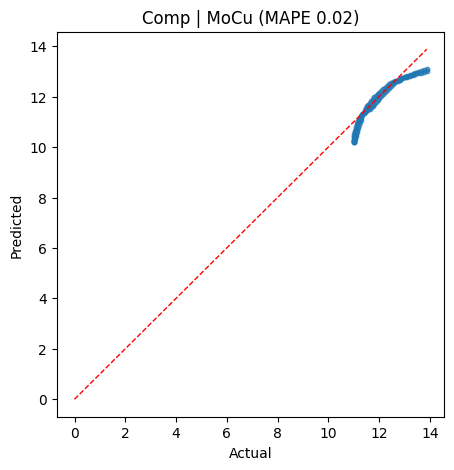

[Comp] Left-out: MoCu | Test MAPE: 0.0246
[Comp] MoMg | Epoch 10/100 Loss: 72.2229
[Comp] MoMg | Epoch 20/100 Loss: 32.8628
[Comp] MoMg | Epoch 30/100 Loss: 9.0233
[Comp] MoMg | Epoch 40/100 Loss: 2.8039
[Comp] MoMg | Epoch 50/100 Loss: 2.0301
[Comp] MoMg | Epoch 60/100 Loss: 1.8555
[Comp] MoMg | Epoch 70/100 Loss: 1.7580
[Comp] MoMg | Epoch 80/100 Loss: 1.6335
[Comp] MoMg | Epoch 90/100 Loss: 1.5657
[Comp] MoMg | Epoch 100/100 Loss: 1.5448


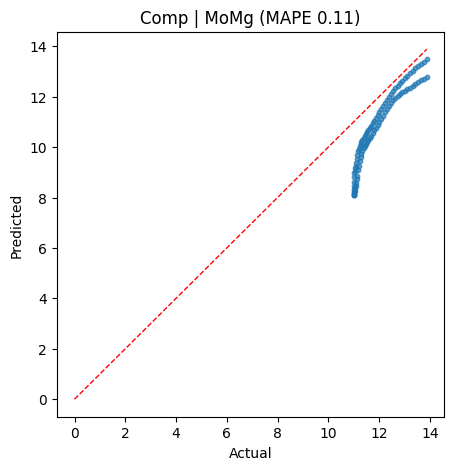

[Comp] Left-out: MoMg | Test MAPE: 0.1067
[Comp] MoTi | Epoch 10/100 Loss: 73.4989
[Comp] MoTi | Epoch 20/100 Loss: 36.9673
[Comp] MoTi | Epoch 30/100 Loss: 10.8716
[Comp] MoTi | Epoch 40/100 Loss: 2.9567
[Comp] MoTi | Epoch 50/100 Loss: 2.0700
[Comp] MoTi | Epoch 60/100 Loss: 1.9330
[Comp] MoTi | Epoch 70/100 Loss: 1.9376
[Comp] MoTi | Epoch 80/100 Loss: 1.6444
[Comp] MoTi | Epoch 90/100 Loss: 1.7202
[Comp] MoTi | Epoch 100/100 Loss: 1.6362


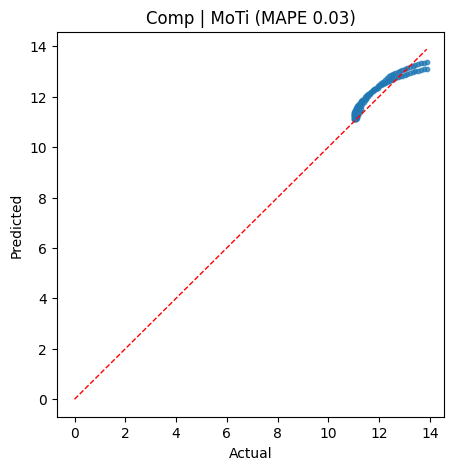

[Comp] Left-out: MoTi | Test MAPE: 0.0281
[Comp] MoZr | Epoch 10/100 Loss: 81.1568
[Comp] MoZr | Epoch 20/100 Loss: 45.1327
[Comp] MoZr | Epoch 30/100 Loss: 16.1358
[Comp] MoZr | Epoch 40/100 Loss: 4.3546
[Comp] MoZr | Epoch 50/100 Loss: 2.3875
[Comp] MoZr | Epoch 60/100 Loss: 2.0290
[Comp] MoZr | Epoch 70/100 Loss: 1.7817
[Comp] MoZr | Epoch 80/100 Loss: 1.7486
[Comp] MoZr | Epoch 90/100 Loss: 1.8145
[Comp] MoZr | Epoch 100/100 Loss: 1.6419


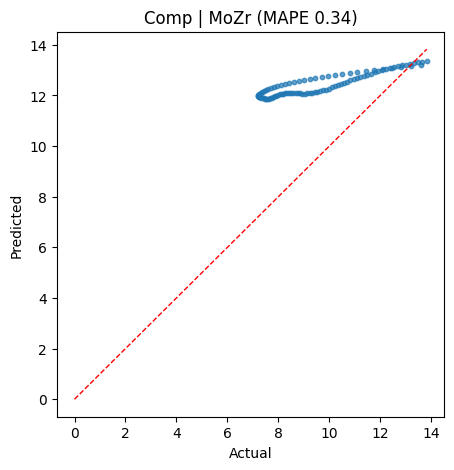

[Comp] Left-out: MoZr | Test MAPE: 0.3382
[Comp] NbMg | Epoch 10/100 Loss: 78.5454
[Comp] NbMg | Epoch 20/100 Loss: 37.8730
[Comp] NbMg | Epoch 30/100 Loss: 11.3376
[Comp] NbMg | Epoch 40/100 Loss: 3.1659
[Comp] NbMg | Epoch 50/100 Loss: 2.0645
[Comp] NbMg | Epoch 60/100 Loss: 1.8143
[Comp] NbMg | Epoch 70/100 Loss: 1.7831
[Comp] NbMg | Epoch 80/100 Loss: 1.6844
[Comp] NbMg | Epoch 90/100 Loss: 1.6215
[Comp] NbMg | Epoch 100/100 Loss: 1.5316


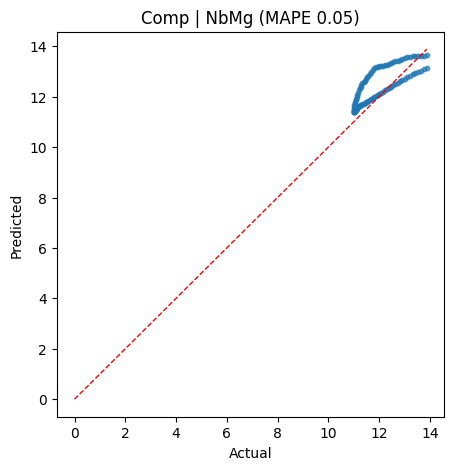

[Comp] Left-out: NbMg | Test MAPE: 0.0481
[Comp] NiMg | Epoch 10/100 Loss: 85.8253
[Comp] NiMg | Epoch 20/100 Loss: 45.1780
[Comp] NiMg | Epoch 30/100 Loss: 13.8249
[Comp] NiMg | Epoch 40/100 Loss: 3.4645
[Comp] NiMg | Epoch 50/100 Loss: 2.0464
[Comp] NiMg | Epoch 60/100 Loss: 1.8300
[Comp] NiMg | Epoch 70/100 Loss: 1.7359
[Comp] NiMg | Epoch 80/100 Loss: 1.6167
[Comp] NiMg | Epoch 90/100 Loss: 1.4817
[Comp] NiMg | Epoch 100/100 Loss: 1.5012


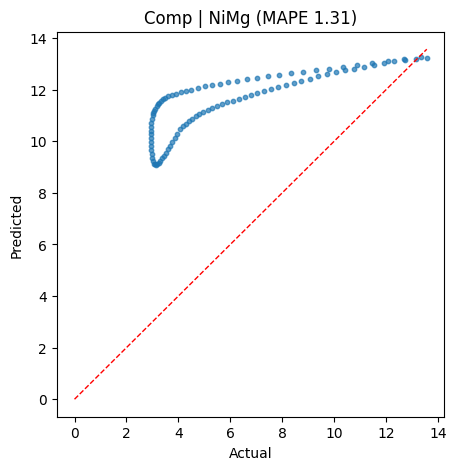

[Comp] Left-out: NiMg | Test MAPE: 1.3077
[Comp] PdFe | Epoch 10/100 Loss: 60.3062
[Comp] PdFe | Epoch 20/100 Loss: 24.8216
[Comp] PdFe | Epoch 30/100 Loss: 6.6097
[Comp] PdFe | Epoch 40/100 Loss: 2.5326
[Comp] PdFe | Epoch 50/100 Loss: 1.9226
[Comp] PdFe | Epoch 60/100 Loss: 1.7104
[Comp] PdFe | Epoch 70/100 Loss: 1.6605
[Comp] PdFe | Epoch 80/100 Loss: 1.5991
[Comp] PdFe | Epoch 90/100 Loss: 1.4905
[Comp] PdFe | Epoch 100/100 Loss: 1.4891


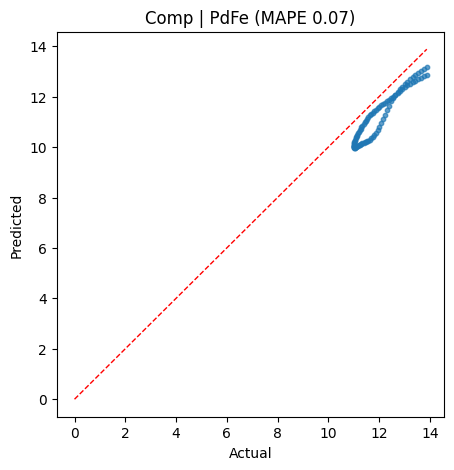

[Comp] Left-out: PdFe | Test MAPE: 0.0671
[Comp] PdMg | Epoch 10/100 Loss: 73.1057
[Comp] PdMg | Epoch 20/100 Loss: 36.4663
[Comp] PdMg | Epoch 30/100 Loss: 11.8169
[Comp] PdMg | Epoch 40/100 Loss: 3.5945
[Comp] PdMg | Epoch 50/100 Loss: 2.2895
[Comp] PdMg | Epoch 60/100 Loss: 2.0080
[Comp] PdMg | Epoch 70/100 Loss: 1.8801
[Comp] PdMg | Epoch 80/100 Loss: 1.8251
[Comp] PdMg | Epoch 90/100 Loss: 1.7378
[Comp] PdMg | Epoch 100/100 Loss: 1.7000


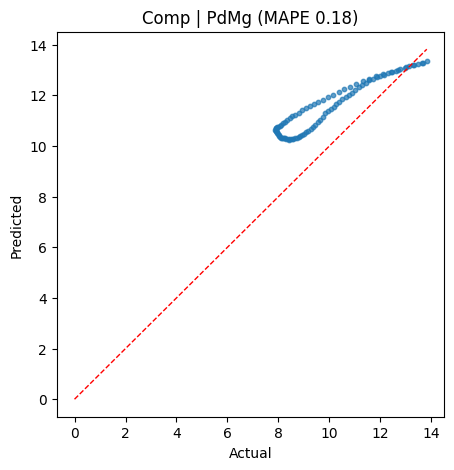

[Comp] Left-out: PdMg | Test MAPE: 0.1810
[Comp] PdSi | Epoch 10/100 Loss: 71.0732
[Comp] PdSi | Epoch 20/100 Loss: 34.5348
[Comp] PdSi | Epoch 30/100 Loss: 10.2257
[Comp] PdSi | Epoch 40/100 Loss: 3.0748
[Comp] PdSi | Epoch 50/100 Loss: 2.0058
[Comp] PdSi | Epoch 60/100 Loss: 1.9101
[Comp] PdSi | Epoch 70/100 Loss: 1.7786
[Comp] PdSi | Epoch 80/100 Loss: 1.7804
[Comp] PdSi | Epoch 90/100 Loss: 1.6579
[Comp] PdSi | Epoch 100/100 Loss: 1.6071


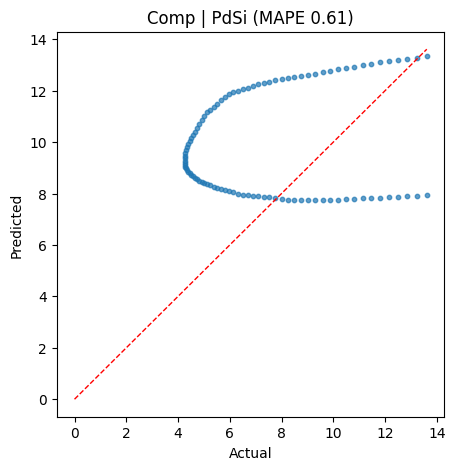

[Comp] Left-out: PdSi | Test MAPE: 0.6088
[Comp] PtGe | Epoch 10/100 Loss: 88.2173
[Comp] PtGe | Epoch 20/100 Loss: 46.0037
[Comp] PtGe | Epoch 30/100 Loss: 14.2068
[Comp] PtGe | Epoch 40/100 Loss: 3.5298
[Comp] PtGe | Epoch 50/100 Loss: 2.1576
[Comp] PtGe | Epoch 60/100 Loss: 1.9129
[Comp] PtGe | Epoch 70/100 Loss: 1.7809
[Comp] PtGe | Epoch 80/100 Loss: 1.7378
[Comp] PtGe | Epoch 90/100 Loss: 1.6235
[Comp] PtGe | Epoch 100/100 Loss: 1.5852


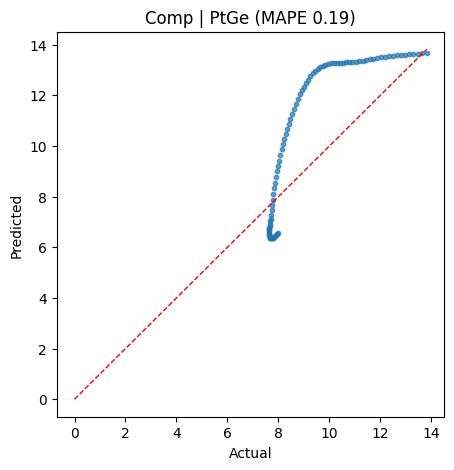

[Comp] Left-out: PtGe | Test MAPE: 0.1913
[Comp] PtMg | Epoch 10/100 Loss: 71.6909
[Comp] PtMg | Epoch 20/100 Loss: 34.9027
[Comp] PtMg | Epoch 30/100 Loss: 10.4675
[Comp] PtMg | Epoch 40/100 Loss: 3.0511
[Comp] PtMg | Epoch 50/100 Loss: 2.0899
[Comp] PtMg | Epoch 60/100 Loss: 1.9669
[Comp] PtMg | Epoch 70/100 Loss: 1.7691
[Comp] PtMg | Epoch 80/100 Loss: 1.6141
[Comp] PtMg | Epoch 90/100 Loss: 1.6074
[Comp] PtMg | Epoch 100/100 Loss: 1.5705


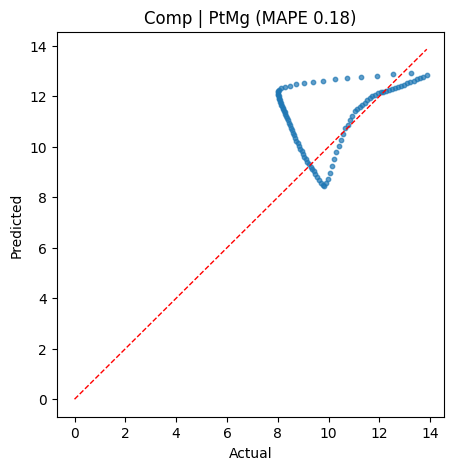

[Comp] Left-out: PtMg | Test MAPE: 0.1783
[Comp] SnMg | Epoch 10/100 Loss: 77.5398
[Comp] SnMg | Epoch 20/100 Loss: 41.9660
[Comp] SnMg | Epoch 30/100 Loss: 14.0066
[Comp] SnMg | Epoch 40/100 Loss: 3.7022
[Comp] SnMg | Epoch 50/100 Loss: 2.3590
[Comp] SnMg | Epoch 60/100 Loss: 2.0211
[Comp] SnMg | Epoch 70/100 Loss: 1.8642
[Comp] SnMg | Epoch 80/100 Loss: 1.7596
[Comp] SnMg | Epoch 90/100 Loss: 1.7041
[Comp] SnMg | Epoch 100/100 Loss: 1.6477


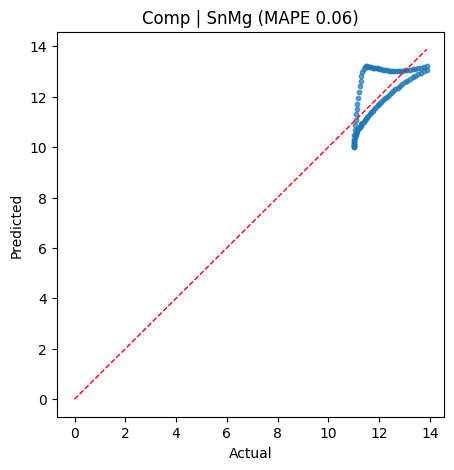

[Comp] Left-out: SnMg | Test MAPE: 0.0554
[Comp] TaMg | Epoch 10/100 Loss: 67.2334
[Comp] TaMg | Epoch 20/100 Loss: 31.8309
[Comp] TaMg | Epoch 30/100 Loss: 9.2371
[Comp] TaMg | Epoch 40/100 Loss: 2.8898
[Comp] TaMg | Epoch 50/100 Loss: 2.1350
[Comp] TaMg | Epoch 60/100 Loss: 1.9312
[Comp] TaMg | Epoch 70/100 Loss: 1.8460
[Comp] TaMg | Epoch 80/100 Loss: 1.7442
[Comp] TaMg | Epoch 90/100 Loss: 1.6170
[Comp] TaMg | Epoch 100/100 Loss: 1.5695


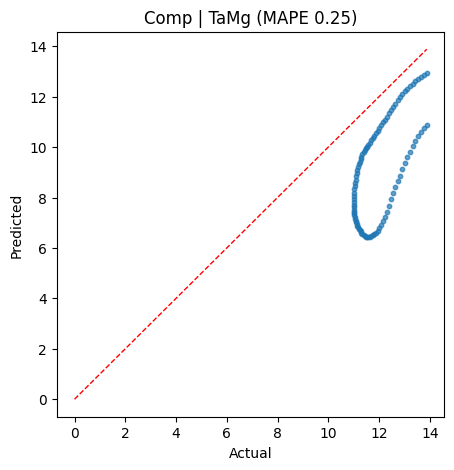

[Comp] Left-out: TaMg | Test MAPE: 0.2473
[Comp] TaMn | Epoch 10/100 Loss: 72.3019
[Comp] TaMn | Epoch 20/100 Loss: 33.4376
[Comp] TaMn | Epoch 30/100 Loss: 9.6956
[Comp] TaMn | Epoch 40/100 Loss: 2.9606
[Comp] TaMn | Epoch 50/100 Loss: 2.1054
[Comp] TaMn | Epoch 60/100 Loss: 1.9973
[Comp] TaMn | Epoch 70/100 Loss: 1.7886
[Comp] TaMn | Epoch 80/100 Loss: 1.7356
[Comp] TaMn | Epoch 90/100 Loss: 1.6789
[Comp] TaMn | Epoch 100/100 Loss: 1.6646


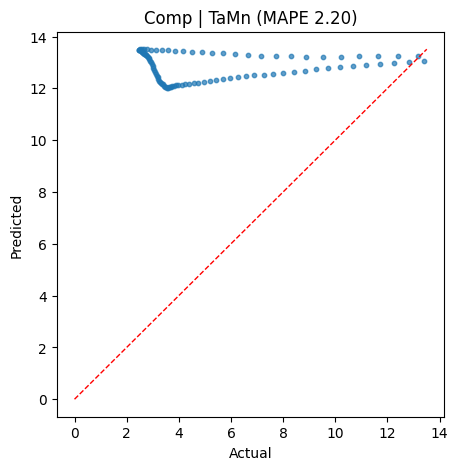

[Comp] Left-out: TaMn | Test MAPE: 2.1974
[Comp] TiMg | Epoch 10/100 Loss: 75.3908
[Comp] TiMg | Epoch 20/100 Loss: 36.0116
[Comp] TiMg | Epoch 30/100 Loss: 9.5620
[Comp] TiMg | Epoch 40/100 Loss: 2.5859
[Comp] TiMg | Epoch 50/100 Loss: 1.9138
[Comp] TiMg | Epoch 60/100 Loss: 1.7694
[Comp] TiMg | Epoch 70/100 Loss: 1.7156
[Comp] TiMg | Epoch 80/100 Loss: 1.5825
[Comp] TiMg | Epoch 90/100 Loss: 1.5126
[Comp] TiMg | Epoch 100/100 Loss: 1.4983


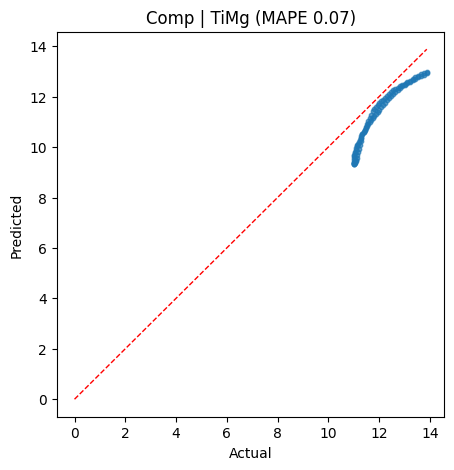

[Comp] Left-out: TiMg | Test MAPE: 0.0702
[Comp] TiZr | Epoch 10/100 Loss: 73.7783
[Comp] TiZr | Epoch 20/100 Loss: 34.1685
[Comp] TiZr | Epoch 30/100 Loss: 9.0702
[Comp] TiZr | Epoch 40/100 Loss: 2.5130
[Comp] TiZr | Epoch 50/100 Loss: 1.8509
[Comp] TiZr | Epoch 60/100 Loss: 1.7378
[Comp] TiZr | Epoch 70/100 Loss: 1.6731
[Comp] TiZr | Epoch 80/100 Loss: 1.5408
[Comp] TiZr | Epoch 90/100 Loss: 1.5192
[Comp] TiZr | Epoch 100/100 Loss: 1.4811


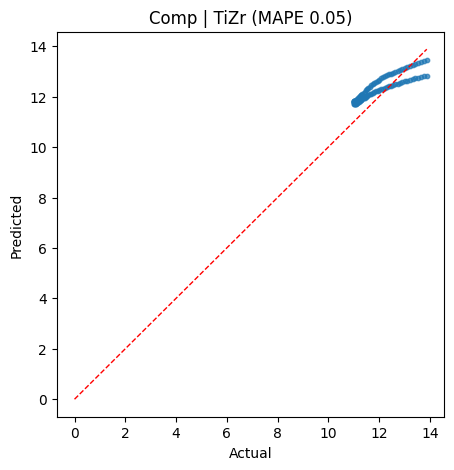

[Comp] Left-out: TiZr | Test MAPE: 0.0463
[Comp] VCu | Epoch 10/100 Loss: 88.1021
[Comp] VCu | Epoch 20/100 Loss: 49.8654
[Comp] VCu | Epoch 30/100 Loss: 19.0358
[Comp] VCu | Epoch 40/100 Loss: 5.4198
[Comp] VCu | Epoch 50/100 Loss: 2.6031
[Comp] VCu | Epoch 60/100 Loss: 2.2066
[Comp] VCu | Epoch 70/100 Loss: 2.0487
[Comp] VCu | Epoch 80/100 Loss: 1.9402
[Comp] VCu | Epoch 90/100 Loss: 1.9330
[Comp] VCu | Epoch 100/100 Loss: 1.8373


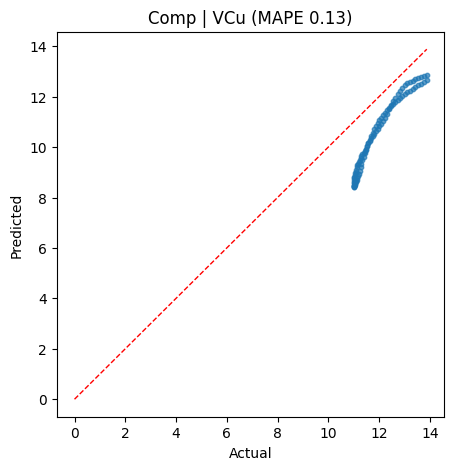

[Comp] Left-out: VCu | Test MAPE: 0.1255
[Comp] VHf | Epoch 10/100 Loss: 78.0273
[Comp] VHf | Epoch 20/100 Loss: 40.5643
[Comp] VHf | Epoch 30/100 Loss: 13.6818
[Comp] VHf | Epoch 40/100 Loss: 3.7585
[Comp] VHf | Epoch 50/100 Loss: 2.1919
[Comp] VHf | Epoch 60/100 Loss: 1.9819
[Comp] VHf | Epoch 70/100 Loss: 1.8679
[Comp] VHf | Epoch 80/100 Loss: 1.7586
[Comp] VHf | Epoch 90/100 Loss: 1.7236
[Comp] VHf | Epoch 100/100 Loss: 1.5992


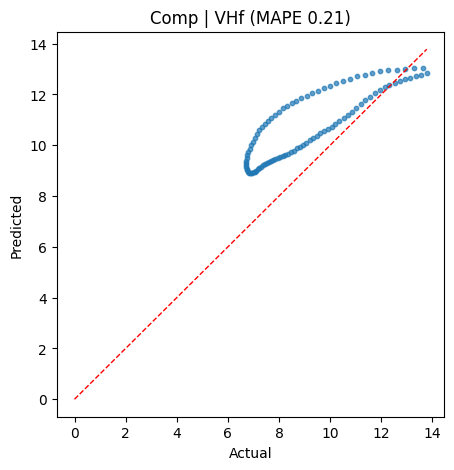

[Comp] Left-out: VHf | Test MAPE: 0.2116
[Comp] VMg | Epoch 10/100 Loss: 74.7848
[Comp] VMg | Epoch 20/100 Loss: 35.1767
[Comp] VMg | Epoch 30/100 Loss: 9.9506
[Comp] VMg | Epoch 40/100 Loss: 2.9135
[Comp] VMg | Epoch 50/100 Loss: 2.0905
[Comp] VMg | Epoch 60/100 Loss: 1.8615
[Comp] VMg | Epoch 70/100 Loss: 1.8149
[Comp] VMg | Epoch 80/100 Loss: 1.6674
[Comp] VMg | Epoch 90/100 Loss: 1.6013
[Comp] VMg | Epoch 100/100 Loss: 1.5779


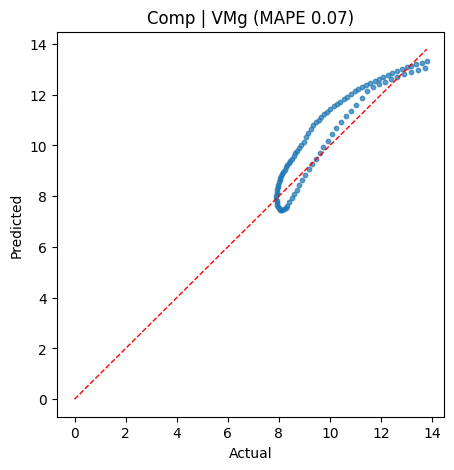

[Comp] Left-out: VMg | Test MAPE: 0.0701
[Comp] VNi | Epoch 10/100 Loss: 72.5663
[Comp] VNi | Epoch 20/100 Loss: 34.6038
[Comp] VNi | Epoch 30/100 Loss: 9.8728
[Comp] VNi | Epoch 40/100 Loss: 2.8810
[Comp] VNi | Epoch 50/100 Loss: 2.0074
[Comp] VNi | Epoch 60/100 Loss: 1.9111
[Comp] VNi | Epoch 70/100 Loss: 1.7675
[Comp] VNi | Epoch 80/100 Loss: 1.6883
[Comp] VNi | Epoch 90/100 Loss: 1.7244
[Comp] VNi | Epoch 100/100 Loss: 1.6678


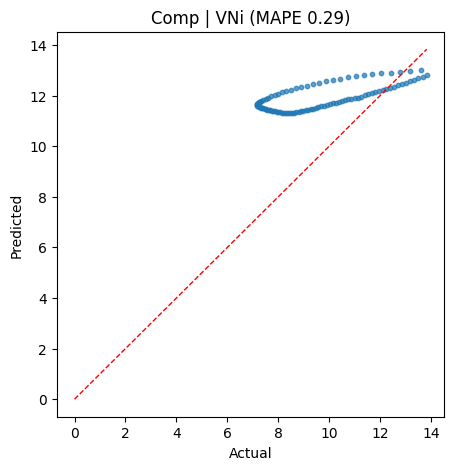

[Comp] Left-out: VNi | Test MAPE: 0.2934
[Comp] VSi | Epoch 10/100 Loss: 72.2334
[Comp] VSi | Epoch 20/100 Loss: 35.0661
[Comp] VSi | Epoch 30/100 Loss: 10.3815
[Comp] VSi | Epoch 40/100 Loss: 3.0342
[Comp] VSi | Epoch 50/100 Loss: 2.0748
[Comp] VSi | Epoch 60/100 Loss: 1.8447
[Comp] VSi | Epoch 70/100 Loss: 1.7732
[Comp] VSi | Epoch 80/100 Loss: 1.7015
[Comp] VSi | Epoch 90/100 Loss: 1.6232
[Comp] VSi | Epoch 100/100 Loss: 1.5860


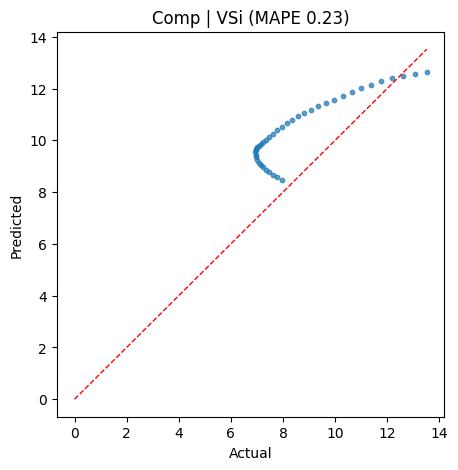

[Comp] Left-out: VSi | Test MAPE: 0.2345
[Comp] VSn | Epoch 10/100 Loss: 73.2908
[Comp] VSn | Epoch 20/100 Loss: 35.2414
[Comp] VSn | Epoch 30/100 Loss: 10.8181
[Comp] VSn | Epoch 40/100 Loss: 3.3792
[Comp] VSn | Epoch 50/100 Loss: 2.2948
[Comp] VSn | Epoch 60/100 Loss: 2.0056
[Comp] VSn | Epoch 70/100 Loss: 1.8407
[Comp] VSn | Epoch 80/100 Loss: 1.7902
[Comp] VSn | Epoch 90/100 Loss: 1.7219
[Comp] VSn | Epoch 100/100 Loss: 1.7190


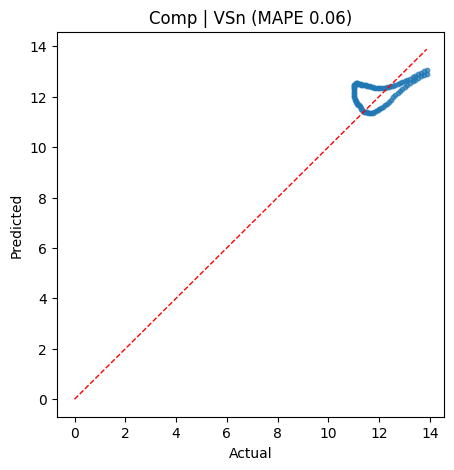

[Comp] Left-out: VSn | Test MAPE: 0.0591
[Comp] VTi | Epoch 10/100 Loss: 75.8532
[Comp] VTi | Epoch 20/100 Loss: 36.8723
[Comp] VTi | Epoch 30/100 Loss: 10.3090
[Comp] VTi | Epoch 40/100 Loss: 2.9445
[Comp] VTi | Epoch 50/100 Loss: 2.0576
[Comp] VTi | Epoch 60/100 Loss: 1.8868
[Comp] VTi | Epoch 70/100 Loss: 1.7923
[Comp] VTi | Epoch 80/100 Loss: 1.6286
[Comp] VTi | Epoch 90/100 Loss: 1.6227
[Comp] VTi | Epoch 100/100 Loss: 1.5235


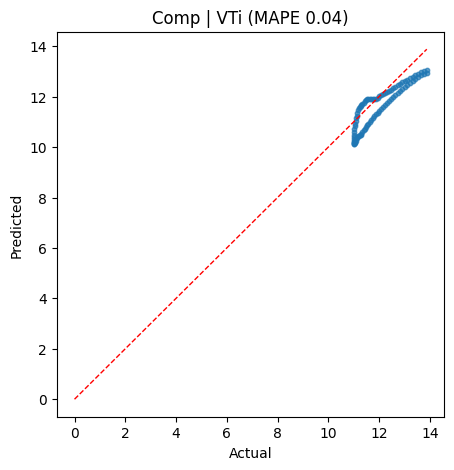

[Comp] Left-out: VTi | Test MAPE: 0.0426
[Comp] VY | Epoch 10/100 Loss: 79.9313
[Comp] VY | Epoch 20/100 Loss: 37.1036
[Comp] VY | Epoch 30/100 Loss: 10.4225
[Comp] VY | Epoch 40/100 Loss: 2.9785
[Comp] VY | Epoch 50/100 Loss: 2.0215
[Comp] VY | Epoch 60/100 Loss: 1.8418
[Comp] VY | Epoch 70/100 Loss: 1.7472
[Comp] VY | Epoch 80/100 Loss: 1.6405
[Comp] VY | Epoch 90/100 Loss: 1.6062
[Comp] VY | Epoch 100/100 Loss: 1.4983


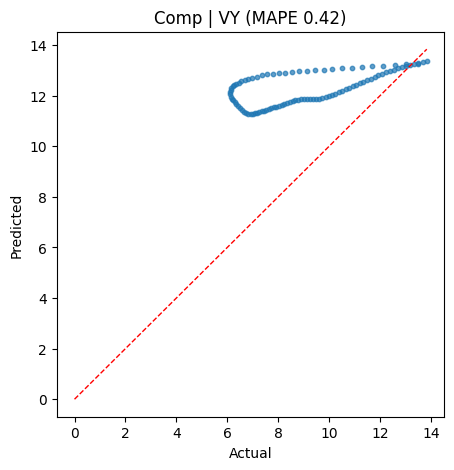

[Comp] Left-out: VY | Test MAPE: 0.4229
[Comp] WMg | Epoch 10/100 Loss: 78.9097
[Comp] WMg | Epoch 20/100 Loss: 40.4006
[Comp] WMg | Epoch 30/100 Loss: 11.2869
[Comp] WMg | Epoch 40/100 Loss: 2.7775
[Comp] WMg | Epoch 50/100 Loss: 1.9714
[Comp] WMg | Epoch 60/100 Loss: 1.8004
[Comp] WMg | Epoch 70/100 Loss: 1.5965
[Comp] WMg | Epoch 80/100 Loss: 1.6470
[Comp] WMg | Epoch 90/100 Loss: 1.4834
[Comp] WMg | Epoch 100/100 Loss: 1.4313


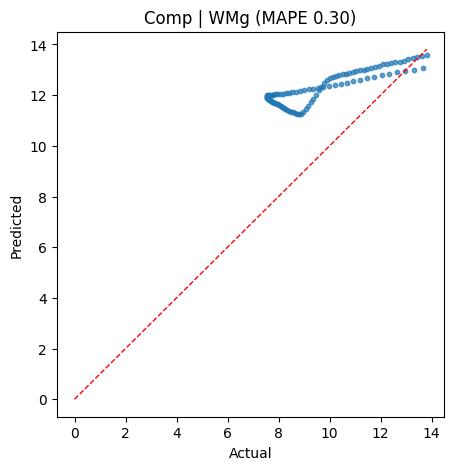

[Comp] Left-out: WMg | Test MAPE: 0.2989
[Comp] WNb | Epoch 10/100 Loss: 79.6251
[Comp] WNb | Epoch 20/100 Loss: 45.6085
[Comp] WNb | Epoch 30/100 Loss: 15.9718
[Comp] WNb | Epoch 40/100 Loss: 4.3131
[Comp] WNb | Epoch 50/100 Loss: 2.3498
[Comp] WNb | Epoch 60/100 Loss: 2.1687
[Comp] WNb | Epoch 70/100 Loss: 1.9624
[Comp] WNb | Epoch 80/100 Loss: 1.9081
[Comp] WNb | Epoch 90/100 Loss: 1.8849
[Comp] WNb | Epoch 100/100 Loss: 1.7566


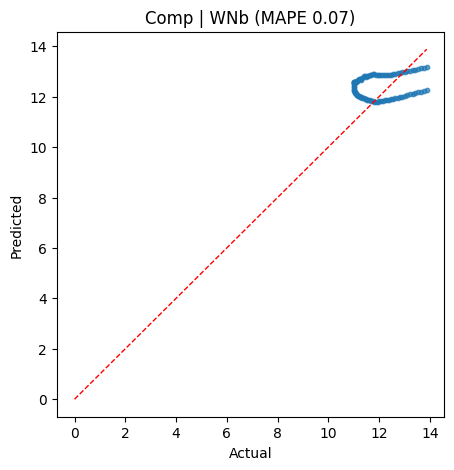

[Comp] Left-out: WNb | Test MAPE: 0.0747
Comp mean MAPE: 0.3092
test
[Random] AgAl | Epoch 10/100 Loss: 74.8648
[Random] AgAl | Epoch 20/100 Loss: 39.0707
[Random] AgAl | Epoch 30/100 Loss: 15.6848
[Random] AgAl | Epoch 40/100 Loss: 9.2044
[Random] AgAl | Epoch 50/100 Loss: 8.5706
[Random] AgAl | Epoch 60/100 Loss: 8.4631
[Random] AgAl | Epoch 70/100 Loss: 8.2342
[Random] AgAl | Epoch 80/100 Loss: 8.3204
[Random] AgAl | Epoch 90/100 Loss: 8.2209
[Random] AgAl | Epoch 100/100 Loss: 8.1937


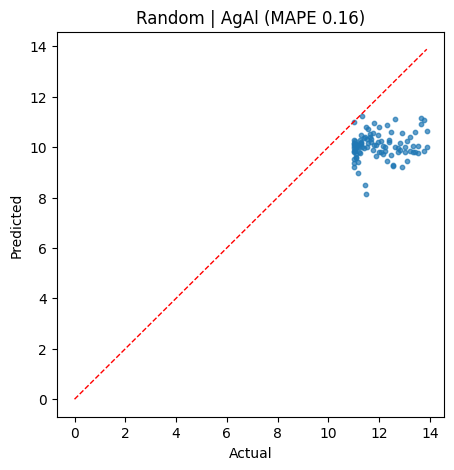

[Random] Left-out: AgAl | Test MAPE: 0.1566
[Random] AlMg | Epoch 10/100 Loss: 82.2268
[Random] AlMg | Epoch 20/100 Loss: 46.0479
[Random] AlMg | Epoch 30/100 Loss: 18.9263
[Random] AlMg | Epoch 40/100 Loss: 9.9223
[Random] AlMg | Epoch 50/100 Loss: 8.5271
[Random] AlMg | Epoch 60/100 Loss: 8.3682
[Random] AlMg | Epoch 70/100 Loss: 8.2886
[Random] AlMg | Epoch 80/100 Loss: 8.1587
[Random] AlMg | Epoch 90/100 Loss: 8.1769
[Random] AlMg | Epoch 100/100 Loss: 7.9616


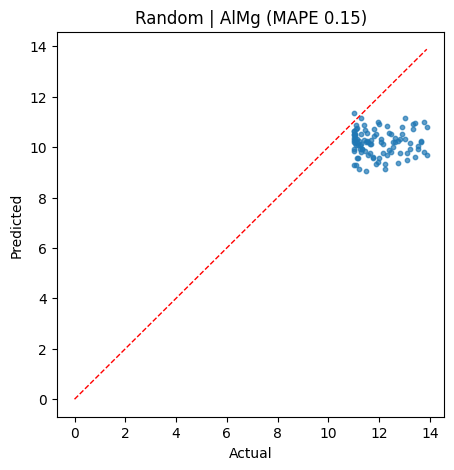

[Random] Left-out: AlMg | Test MAPE: 0.1473
[Random] AlNi | Epoch 10/100 Loss: 82.4012
[Random] AlNi | Epoch 20/100 Loss: 44.7576
[Random] AlNi | Epoch 30/100 Loss: 17.5210
[Random] AlNi | Epoch 40/100 Loss: 9.5150
[Random] AlNi | Epoch 50/100 Loss: 8.6005
[Random] AlNi | Epoch 60/100 Loss: 8.4167
[Random] AlNi | Epoch 70/100 Loss: 8.2038
[Random] AlNi | Epoch 80/100 Loss: 8.3467
[Random] AlNi | Epoch 90/100 Loss: 8.1810
[Random] AlNi | Epoch 100/100 Loss: 8.1313


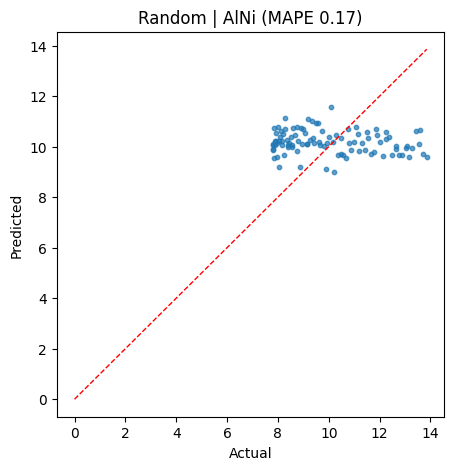

[Random] Left-out: AlNi | Test MAPE: 0.1733
[Random] AlTi | Epoch 10/100 Loss: 80.2473
[Random] AlTi | Epoch 20/100 Loss: 43.6228
[Random] AlTi | Epoch 30/100 Loss: 17.4681
[Random] AlTi | Epoch 40/100 Loss: 9.3212
[Random] AlTi | Epoch 50/100 Loss: 8.4801
[Random] AlTi | Epoch 60/100 Loss: 8.2780
[Random] AlTi | Epoch 70/100 Loss: 8.4464
[Random] AlTi | Epoch 80/100 Loss: 8.1898
[Random] AlTi | Epoch 90/100 Loss: 8.0761
[Random] AlTi | Epoch 100/100 Loss: 7.9367


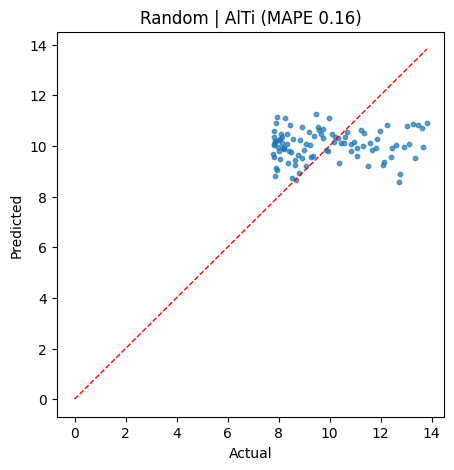

[Random] Left-out: AlTi | Test MAPE: 0.1618
[Random] AlV | Epoch 10/100 Loss: 78.2633
[Random] AlV | Epoch 20/100 Loss: 41.0254
[Random] AlV | Epoch 30/100 Loss: 16.0288
[Random] AlV | Epoch 40/100 Loss: 9.2557
[Random] AlV | Epoch 50/100 Loss: 8.4814
[Random] AlV | Epoch 60/100 Loss: 8.3004
[Random] AlV | Epoch 70/100 Loss: 8.1332
[Random] AlV | Epoch 80/100 Loss: 8.0770
[Random] AlV | Epoch 90/100 Loss: 8.1278
[Random] AlV | Epoch 100/100 Loss: 7.9356


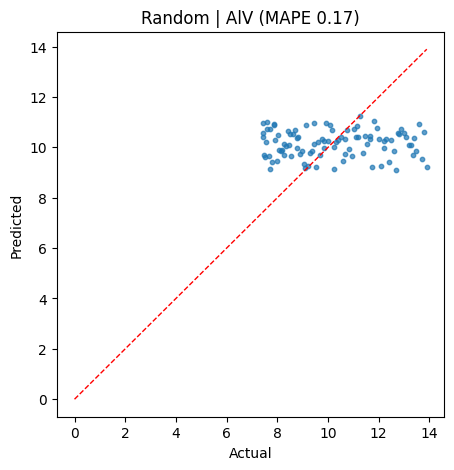

[Random] Left-out: AlV | Test MAPE: 0.1686
[Random] AuAl | Epoch 10/100 Loss: 81.6172
[Random] AuAl | Epoch 20/100 Loss: 45.1786
[Random] AuAl | Epoch 30/100 Loss: 18.0801
[Random] AuAl | Epoch 40/100 Loss: 9.4429
[Random] AuAl | Epoch 50/100 Loss: 8.5916
[Random] AuAl | Epoch 60/100 Loss: 8.3525
[Random] AuAl | Epoch 70/100 Loss: 8.2591
[Random] AuAl | Epoch 80/100 Loss: 8.2169
[Random] AuAl | Epoch 90/100 Loss: 8.2164
[Random] AuAl | Epoch 100/100 Loss: 8.1824


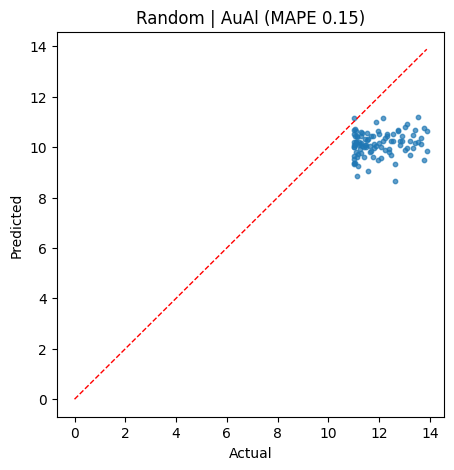

[Random] Left-out: AuAl | Test MAPE: 0.1509
[Random] AuCr | Epoch 10/100 Loss: 73.5371
[Random] AuCr | Epoch 20/100 Loss: 37.2420
[Random] AuCr | Epoch 30/100 Loss: 14.7543
[Random] AuCr | Epoch 40/100 Loss: 9.1966
[Random] AuCr | Epoch 50/100 Loss: 8.4733
[Random] AuCr | Epoch 60/100 Loss: 8.3052
[Random] AuCr | Epoch 70/100 Loss: 8.1383
[Random] AuCr | Epoch 80/100 Loss: 8.1044
[Random] AuCr | Epoch 90/100 Loss: 8.1634
[Random] AuCr | Epoch 100/100 Loss: 7.9099


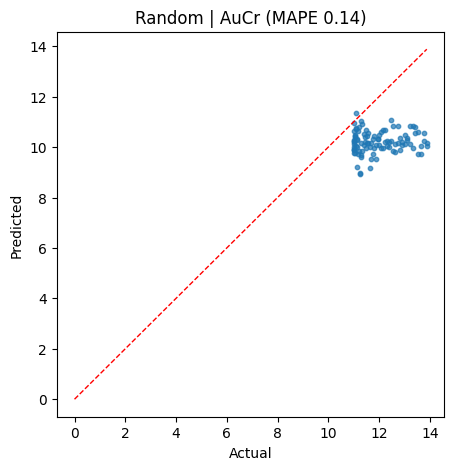

[Random] Left-out: AuCr | Test MAPE: 0.1443
[Random] AuHf | Epoch 10/100 Loss: 70.3826
[Random] AuHf | Epoch 20/100 Loss: 34.8578
[Random] AuHf | Epoch 30/100 Loss: 13.7268
[Random] AuHf | Epoch 40/100 Loss: 8.7860
[Random] AuHf | Epoch 50/100 Loss: 8.2671
[Random] AuHf | Epoch 60/100 Loss: 8.2511
[Random] AuHf | Epoch 70/100 Loss: 8.1532
[Random] AuHf | Epoch 80/100 Loss: 8.1579
[Random] AuHf | Epoch 90/100 Loss: 8.0630
[Random] AuHf | Epoch 100/100 Loss: 8.0113


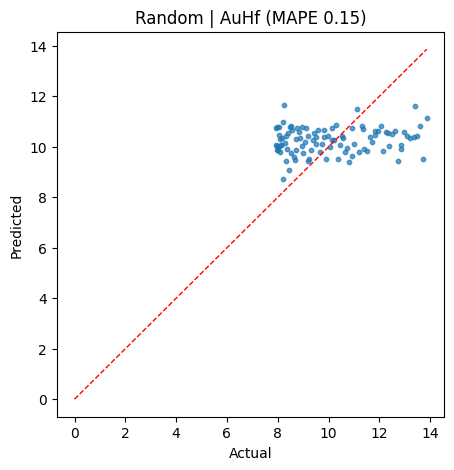

[Random] Left-out: AuHf | Test MAPE: 0.1526
[Random] AuMg | Epoch 10/100 Loss: 66.8770
[Random] AuMg | Epoch 20/100 Loss: 31.3256
[Random] AuMg | Epoch 30/100 Loss: 12.0081
[Random] AuMg | Epoch 40/100 Loss: 8.6911
[Random] AuMg | Epoch 50/100 Loss: 8.2226
[Random] AuMg | Epoch 60/100 Loss: 8.1407
[Random] AuMg | Epoch 70/100 Loss: 8.0333
[Random] AuMg | Epoch 80/100 Loss: 7.9883
[Random] AuMg | Epoch 90/100 Loss: 7.9077
[Random] AuMg | Epoch 100/100 Loss: 7.8602


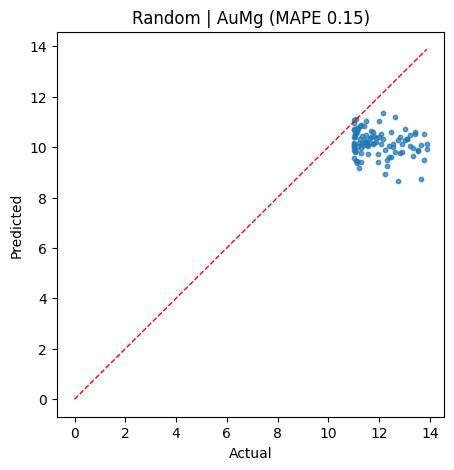

[Random] Left-out: AuMg | Test MAPE: 0.1469
[Random] CoMg | Epoch 10/100 Loss: 83.0164
[Random] CoMg | Epoch 20/100 Loss: 44.5611
[Random] CoMg | Epoch 30/100 Loss: 17.5702
[Random] CoMg | Epoch 40/100 Loss: 9.3003
[Random] CoMg | Epoch 50/100 Loss: 8.1295
[Random] CoMg | Epoch 60/100 Loss: 7.9211
[Random] CoMg | Epoch 70/100 Loss: 7.8144
[Random] CoMg | Epoch 80/100 Loss: 7.8710
[Random] CoMg | Epoch 90/100 Loss: 7.6960
[Random] CoMg | Epoch 100/100 Loss: 7.7457


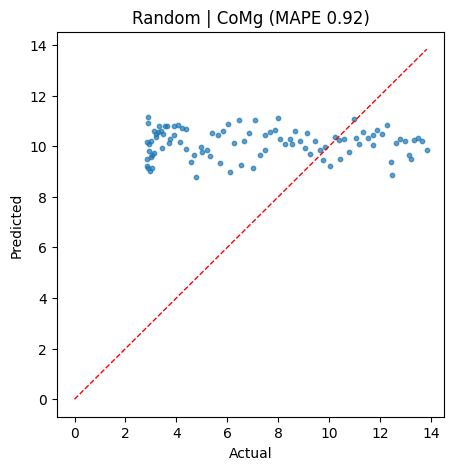

[Random] Left-out: CoMg | Test MAPE: 0.9192
[Random] CrAl | Epoch 10/100 Loss: 74.6309
[Random] CrAl | Epoch 20/100 Loss: 37.8803
[Random] CrAl | Epoch 30/100 Loss: 14.6251
[Random] CrAl | Epoch 40/100 Loss: 9.0392
[Random] CrAl | Epoch 50/100 Loss: 8.4455
[Random] CrAl | Epoch 60/100 Loss: 8.3272
[Random] CrAl | Epoch 70/100 Loss: 8.4599
[Random] CrAl | Epoch 80/100 Loss: 8.0714
[Random] CrAl | Epoch 90/100 Loss: 8.2204
[Random] CrAl | Epoch 100/100 Loss: 7.9107


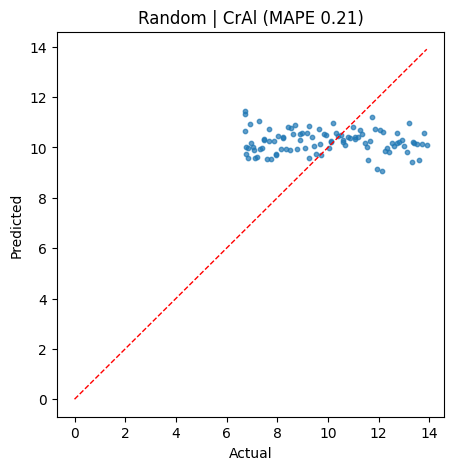

[Random] Left-out: CrAl | Test MAPE: 0.2102
[Random] CrCo | Epoch 10/100 Loss: 80.3756
[Random] CrCo | Epoch 20/100 Loss: 42.0011
[Random] CrCo | Epoch 30/100 Loss: 16.0184
[Random] CrCo | Epoch 40/100 Loss: 9.0120
[Random] CrCo | Epoch 50/100 Loss: 8.4719
[Random] CrCo | Epoch 60/100 Loss: 8.3443
[Random] CrCo | Epoch 70/100 Loss: 8.0444
[Random] CrCo | Epoch 80/100 Loss: 7.9299
[Random] CrCo | Epoch 90/100 Loss: 8.0787
[Random] CrCo | Epoch 100/100 Loss: 8.0288


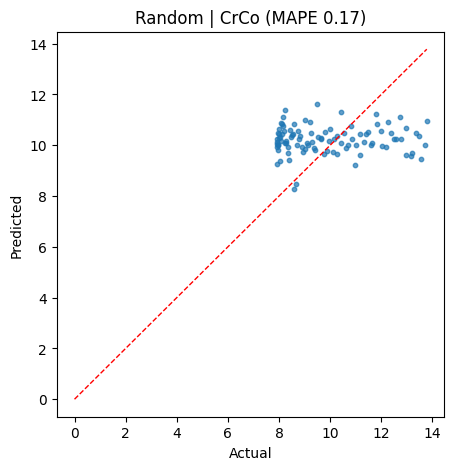

[Random] Left-out: CrCo | Test MAPE: 0.1658
[Random] CrMg | Epoch 10/100 Loss: 72.2829
[Random] CrMg | Epoch 20/100 Loss: 37.3295
[Random] CrMg | Epoch 30/100 Loss: 15.1723
[Random] CrMg | Epoch 40/100 Loss: 8.9575
[Random] CrMg | Epoch 50/100 Loss: 8.3783
[Random] CrMg | Epoch 60/100 Loss: 8.2709
[Random] CrMg | Epoch 70/100 Loss: 8.1300
[Random] CrMg | Epoch 80/100 Loss: 8.3161
[Random] CrMg | Epoch 90/100 Loss: 7.9533
[Random] CrMg | Epoch 100/100 Loss: 7.9925


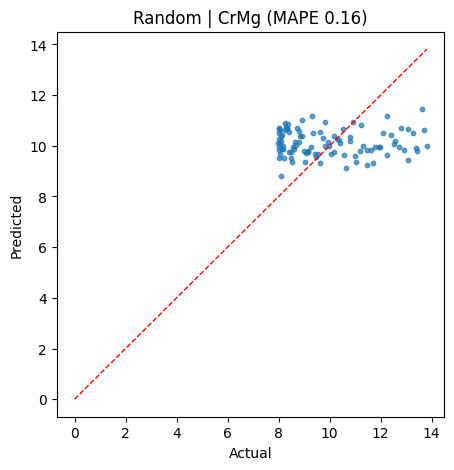

[Random] Left-out: CrMg | Test MAPE: 0.1598
[Random] CrNi | Epoch 10/100 Loss: 68.4570
[Random] CrNi | Epoch 20/100 Loss: 32.1255
[Random] CrNi | Epoch 30/100 Loss: 12.5477
[Random] CrNi | Epoch 40/100 Loss: 8.6578
[Random] CrNi | Epoch 50/100 Loss: 8.2870
[Random] CrNi | Epoch 60/100 Loss: 8.2420
[Random] CrNi | Epoch 70/100 Loss: 8.1160
[Random] CrNi | Epoch 80/100 Loss: 7.9711
[Random] CrNi | Epoch 90/100 Loss: 7.8861
[Random] CrNi | Epoch 100/100 Loss: 7.8006


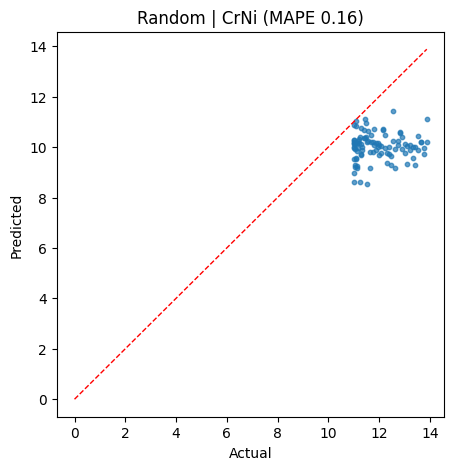

[Random] Left-out: CrNi | Test MAPE: 0.1590
[Random] CrV | Epoch 10/100 Loss: 75.8815
[Random] CrV | Epoch 20/100 Loss: 38.1655
[Random] CrV | Epoch 30/100 Loss: 14.3400
[Random] CrV | Epoch 40/100 Loss: 8.9162
[Random] CrV | Epoch 50/100 Loss: 8.3335
[Random] CrV | Epoch 60/100 Loss: 8.3371
[Random] CrV | Epoch 70/100 Loss: 8.4092
[Random] CrV | Epoch 80/100 Loss: 8.1471
[Random] CrV | Epoch 90/100 Loss: 8.1299
[Random] CrV | Epoch 100/100 Loss: 7.9443


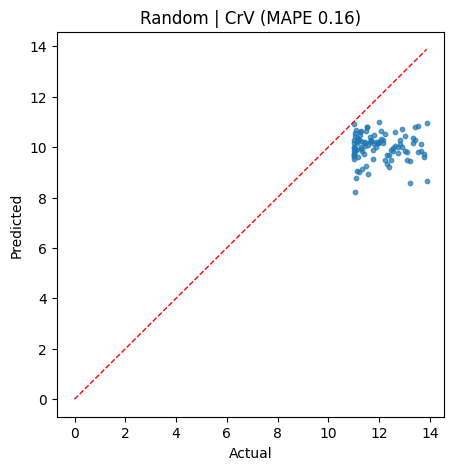

[Random] Left-out: CrV | Test MAPE: 0.1612
[Random] CuAl | Epoch 10/100 Loss: 81.7883
[Random] CuAl | Epoch 20/100 Loss: 44.5830
[Random] CuAl | Epoch 30/100 Loss: 18.0067
[Random] CuAl | Epoch 40/100 Loss: 9.5934
[Random] CuAl | Epoch 60/100 Loss: 8.3886
[Random] CuAl | Epoch 70/100 Loss: 8.2531
[Random] CuAl | Epoch 80/100 Loss: 8.1482
[Random] CuAl | Epoch 90/100 Loss: 8.1293
[Random] CuAl | Epoch 100/100 Loss: 8.0572


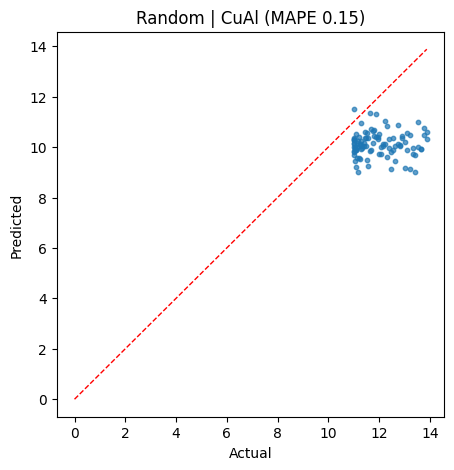

[Random] Left-out: CuAl | Test MAPE: 0.1520
[Random] CuMg | Epoch 10/100 Loss: 84.6919
[Random] CuMg | Epoch 20/100 Loss: 48.4903
[Random] CuMg | Epoch 30/100 Loss: 19.4274
[Random] CuMg | Epoch 40/100 Loss: 9.9347
[Random] CuMg | Epoch 50/100 Loss: 8.5877
[Random] CuMg | Epoch 60/100 Loss: 8.2196
[Random] CuMg | Epoch 70/100 Loss: 8.2101
[Random] CuMg | Epoch 80/100 Loss: 8.1299
[Random] CuMg | Epoch 90/100 Loss: 8.1151
[Random] CuMg | Epoch 100/100 Loss: 7.9967


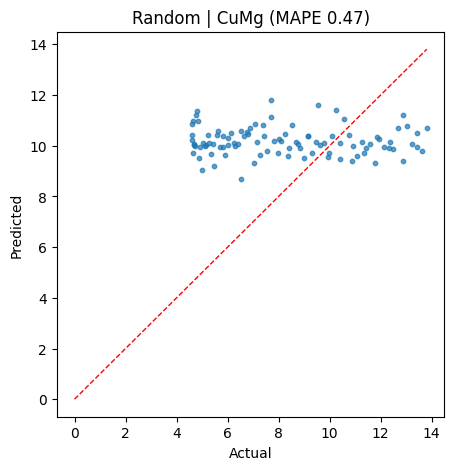

[Random] Left-out: CuMg | Test MAPE: 0.4708
[Random] CuNi | Epoch 10/100 Loss: 77.4222
[Random] CuNi | Epoch 20/100 Loss: 40.8424
[Random] CuNi | Epoch 30/100 Loss: 16.2652
[Random] CuNi | Epoch 40/100 Loss: 9.3070
[Random] CuNi | Epoch 50/100 Loss: 8.4632
[Random] CuNi | Epoch 60/100 Loss: 8.4328
[Random] CuNi | Epoch 70/100 Loss: 8.1499
[Random] CuNi | Epoch 80/100 Loss: 8.1647
[Random] CuNi | Epoch 90/100 Loss: 8.1045
[Random] CuNi | Epoch 100/100 Loss: 8.1746


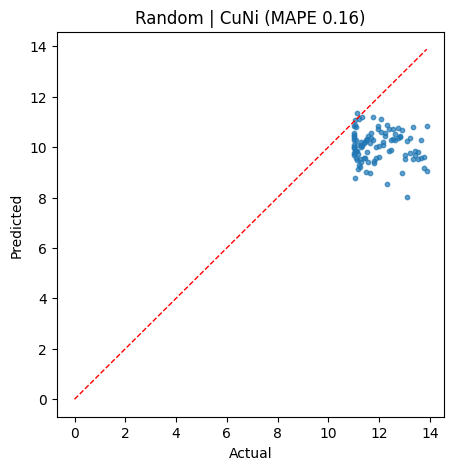

[Random] Left-out: CuNi | Test MAPE: 0.1568
[Random] CuSi | Epoch 10/100 Loss: 79.9637
[Random] CuSi | Epoch 20/100 Loss: 43.4548
[Random] CuSi | Epoch 30/100 Loss: 17.6607
[Random] CuSi | Epoch 40/100 Loss: 9.7048
[Random] CuSi | Epoch 50/100 Loss: 8.5605
[Random] CuSi | Epoch 60/100 Loss: 8.4161
[Random] CuSi | Epoch 70/100 Loss: 8.3748
[Random] CuSi | Epoch 80/100 Loss: 8.1271
[Random] CuSi | Epoch 90/100 Loss: 8.0899
[Random] CuSi | Epoch 100/100 Loss: 8.0537


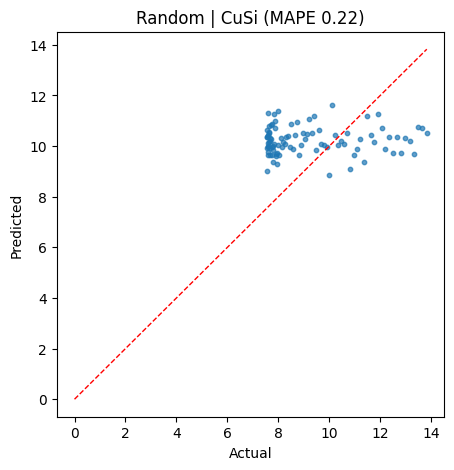

[Random] Left-out: CuSi | Test MAPE: 0.2233
[Random] CuZr | Epoch 10/100 Loss: 83.1408
[Random] CuZr | Epoch 20/100 Loss: 45.1030
[Random] CuZr | Epoch 30/100 Loss: 18.3476
[Random] CuZr | Epoch 40/100 Loss: 9.4683
[Random] CuZr | Epoch 50/100 Loss: 8.3160
[Random] CuZr | Epoch 60/100 Loss: 7.9989
[Random] CuZr | Epoch 70/100 Loss: 7.8347
[Random] CuZr | Epoch 80/100 Loss: 7.7302
[Random] CuZr | Epoch 90/100 Loss: 7.7152
[Random] CuZr | Epoch 100/100 Loss: 7.6990


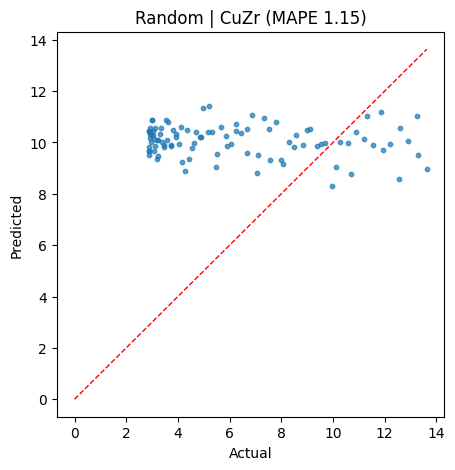

[Random] Left-out: CuZr | Test MAPE: 1.1460
[Random] FeAl | Epoch 10/100 Loss: 78.7710
[Random] FeAl | Epoch 20/100 Loss: 40.4118
[Random] FeAl | Epoch 30/100 Loss: 15.0335
[Random] FeAl | Epoch 40/100 Loss: 8.9586
[Random] FeAl | Epoch 50/100 Loss: 8.4308
[Random] FeAl | Epoch 60/100 Loss: 8.4043
[Random] FeAl | Epoch 70/100 Loss: 8.2497
[Random] FeAl | Epoch 80/100 Loss: 8.2272
[Random] FeAl | Epoch 90/100 Loss: 8.0850
[Random] FeAl | Epoch 100/100 Loss: 8.0486


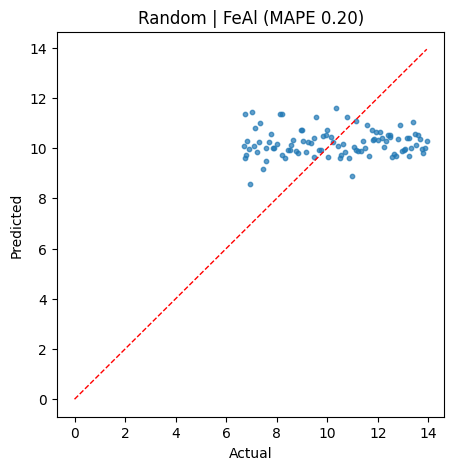

[Random] Left-out: FeAl | Test MAPE: 0.2028
[Random] GeMg | Epoch 10/100 Loss: 81.1276
[Random] GeMg | Epoch 20/100 Loss: 43.5091
[Random] GeMg | Epoch 30/100 Loss: 16.7994
[Random] GeMg | Epoch 40/100 Loss: 9.1275
[Random] GeMg | Epoch 50/100 Loss: 8.2363
[Random] GeMg | Epoch 60/100 Loss: 8.1155
[Random] GeMg | Epoch 70/100 Loss: 8.0431
[Random] GeMg | Epoch 80/100 Loss: 8.0635
[Random] GeMg | Epoch 90/100 Loss: 7.9550
[Random] GeMg | Epoch 100/100 Loss: 7.8329


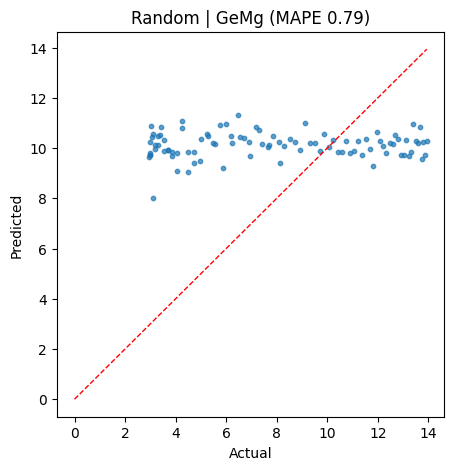

[Random] Left-out: GeMg | Test MAPE: 0.7914
[Random] HfAl | Epoch 10/100 Loss: 90.4989
[Random] HfAl | Epoch 20/100 Loss: 53.0185
[Random] HfAl | Epoch 30/100 Loss: 22.6010
[Random] HfAl | Epoch 40/100 Loss: 10.4650
[Random] HfAl | Epoch 50/100 Loss: 8.3544
[Random] HfAl | Epoch 60/100 Loss: 8.2002
[Random] HfAl | Epoch 70/100 Loss: 8.0353
[Random] HfAl | Epoch 80/100 Loss: 8.0581
[Random] HfAl | Epoch 90/100 Loss: 7.9574
[Random] HfAl | Epoch 100/100 Loss: 7.9664


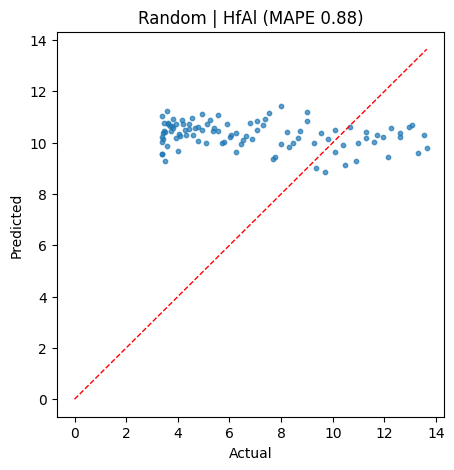

[Random] Left-out: HfAl | Test MAPE: 0.8758
[Random] HfFe | Epoch 10/100 Loss: 72.6142
[Random] HfFe | Epoch 20/100 Loss: 37.3714
[Random] HfFe | Epoch 30/100 Loss: 14.8163
[Random] HfFe | Epoch 40/100 Loss: 8.7056


In [ ]:
for name, df in [("PI", df_pi), ("EP", df_ep), ("Comp", df_comp), ("Random", df_rand)]:
    print("test")
    mean_mape, mapes, per_sys = run_loop_gpu_cached(df, name, epochs=100, batch_size=512, lr=1e-3, device=device)
    print(f"{name} mean MAPE: {mean_mape:.4f}")
    #plot_pred_vs_actual(per_sys, n=6)
    #plot_error_hist(per_sys)

In [ ]:
pi_mean_mape, pi_mapes, pi_per_sys = run_loop(df_pi, "PI", epochs=50, batch_size=32, lr=1e-3, device=device)

In [ ]:
ep_mean_mape, ep_mapes, ep_per_sys = run_loop(df_ep, "EP", epochs=50, batch_size=32, lr=1e-3)

In [ ]:
comp_mean_mape, comp_mapes, comp_per_sys = run_loop(df_comp, "Comp", epochs=50, batch_size=32, lr=1e-3)

In [ ]:
rand_mean_mape, rand_mapes, rand_per_sys = run_loop(df_rand, "Random", epochs=50, batch_size=32, lr=1e-3)